# Formation RNAseq CEA - juin 2023

*Enseignantes : Sandrine Caburet et Claire Vandiedonck*

Session IFB : 5 CPU + 21 GB de RAM

# Part 10 : Exploratory analysis of normalized read counts and visualization of DGE analysis


    0 - Getting started
        0. 1 - Setting up this R session on IFB core cluster  
        0. 2 - Parameters to be set or modified by the user   
    1 - Loading input data and metadata   
    2 - Principal Component Analysis   
    3 - Clustering and Heatmaps
    4 - Correlograms
    5 - Saving our results for later use: RData file

---
## **Before going further**

<div class="alert alert-block alert-danger"><b>Caution:</b> 
Before starting the analysis, save a backup copy of this notebok : in the left-hand panel, right-click on this file and select "Duplicate"<br>
You can also make backups during the analysis. Don't forget to save your notebook regularly: <kbd>Ctrl</kbd> + <kbd>S</kbd> or click on the 💾 icon.
</div>

<div class="alert alert-block alert-warning"><b>Warning:</b>You are strongly advised to run the cells in the indicated order. If you want to rerun cells above, you can just restart the kernel to start at 1 again. </div>

---
---
## 0. Getting started

---
### 0.1 - Setting up this R session on IFB core cluster
---

<em>loaded JupyterLab</em> : Version 3.5.0

#### **0.1-a. Jupyter session**

In [1]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/sys/dash {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,ReqMem,NodeList,Elapsed,State -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

[1] "=== Cell launched on Wed Jun 26 14:32:24 CEST 2024 ==="                         
[2] "          40386420      fast sys/dash scaburet  R    5:09:35      1 cpu-node-51"
[3] "=== Current IFB session size: Medium (5CPU, 21 GB) ==="                         
[4] "JobID         AllocCPUS     ReqMem        NodeList    Elapsed      State "      
[5] "------------ ---------- ---------- --------------- ---------- ---------- "      
[6] "40386420              7        33G     cpu-node-51   05:09:35    RUNNING "      


__

#### **0.1-b. R session**

Next we load into this R session the various tools that we will use.   
If a R 4.2 library folder is not already included in the available libPaths, Code cell 2 will add it. This way, required packages that are not already present on the server will be installed in your home.

In [2]:
## Code cell 2 ##

# verification of the paths to the R librairies
.libPaths()

# creation of the directory if it was not created in previous analyses, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create("~/R/x86_64-conda-linux-gnu-library/4.2", recursive = TRUE, showWarnings = FALSE)

# in the case your home directory is not in libPaths
.libPaths('~/R/x86_64-conda-linux-gnu-library/4.2')

# verification of its addition:
.libPaths()

[1] "/shared/ifbstor1/home/scaburet/R/x86_64-conda-linux-gnu-library/4.2"
[2] "/shared/ifbstor1/software/miniconda/envs/r-4.2.3/lib/R/library"

[1] "/shared/ifbstor1/home/scaburet/R/x86_64-conda-linux-gnu-library/4.2"
[2] "/shared/ifbstor1/software/miniconda/envs/r-4.2.3/lib/R/library"

***DO NOT worry*** if you see a large red output! It contains a warning message, including for functions from different packages sharing the same names. If some packages are required but not yet installed on the server, you will also see a message when the relevant packages are installed in your home directory ("~/R/x86_64-conda-linux-gnu-library/4.2").

In [3]:
## Code cell 3 ##

# list the required libraries from the CRAN repository
requiredLib <- c(
    "ggfortify",
    "ggrepel",
    "RColorBrewer",
    "ggplot2",
    "stringr",
    "matrixStats",
    "corrplot",
    "BiocManager",
    "FactoMineR",
    "factoextra"
)

# list the required libraries from the Bioconductor project
requiredBiocLib <- c(
    "DESeq2",
    "ComplexHeatmap")


# install required libraries if not yet installed
for (lib in requiredLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
    install.packages(lib, quiet = TRUE, repos = "https://cloud.r-project.org")
  }
}
for( lib in requiredBiocLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
  BiocManager::install(lib, quiet = TRUE, update = FALSE)
  }
}

# load libraries
message("Loading required libraries")
for (lib in requiredLib) {
  library(lib, character.only = TRUE)}
for (lib in requiredBiocLib) {
  library(lib, character.only = TRUE)}

# remove variables from the R session if they are no longer necessary 
rm(lib, requiredLib, requiredBiocLib)



corrplot 0.92 loaded

Bioconductor version '3.16' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    I, expand.grid, unname



Attaching package: 'MatrixGenerics'



In [4]:
## Code cell 4 ##   

cat("Here is my R session with the loaded packages:\n")
sessionInfo()

Here is my R session with the loaded packages:


R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /shared/ifbstor1/software/miniconda/envs/r-4.2.3/lib/libopenblasp-r0.3.21.so

locale:
[1] C

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.14.0       DESeq2_1.38.3              
 [3] SummarizedExperiment_1.28.0 Biobase_2.62.0             
 [5] MatrixGenerics_1.10.0       GenomicRanges_1.50.2       
 [7] GenomeInfoDb_1.34.9         IRanges_2.32.0             
 [9] S4Vectors_0.36.2            BiocGenerics_0.44.0        
[11] factoextra_1.0.7            FactoMineR_2.11            
[13] BiocManager_1.30.23         corrplot_0.92              
[15] matrixStats_1.3.0           stringr_1.5.1              
[17] RColorBrewer_1.1-3          ggrepel_0.9.5              
[19] ggfortify_0.4.17            ggplot2_3.5.1              

l

---

### 0.2 - Parameters to be set or modified by the user
---

- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, and the folder where you work as the `myfolder` variable:

<div class="alert alert-block alert-warning"> <b> Warning on working directory: </b><br>In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened for the <b> fisrt time </b>. Even if you move it ton another directory, it keeps the original working diretory unless you set it again with the function <code>setwd()</code>.</div>

In [5]:
## Code cell 5 ##

gohome <- "/shared/projects/2413_rnaseq_cea/"
gohome

myfolder <- getwd()
myfolder

[1] "/shared/projects/2413_rnaseq_cea/"

[1] "/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet"

- With a `/` at the end, define the path to the folder where the results of this analysis will be stored. As it is a logical step usually performed together with the normalisation by `DESeq2`, we can stay in the same output folder :

In [6]:
## Code cell 6 ##

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
# we can skip this step as the folder is already created
# dir.create(paste(myfolder,"/Results/deseq2/", sep = ""), recursive = TRUE)

# storing the path to this output folder in a variable
deseq2folder <- paste(myfolder,"/Results/deseq2/", sep = "")
deseq2folder

# listing the content of the folder
print(system(paste("ls -hlt", deseq2folder), intern = TRUE) )

[1] "/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet/Results/deseq2/"

[1] "total 13M"                                                                                  
[2] "-rw-rw----+ 1 scaburet scaburet 4.6M Jun 26 11:26 deseq2.RData"                             
[3] "-rw-rw----+ 1 scaburet scaburet 1.7M Jun 26 11:26 deseq2_all_genes.RData"                   
[4] "-rw-rw----+ 1 scaburet scaburet 2.4K Jun 26 11:26 DESeq2_significant_genes-0_00001-down.tsv"
[5] "-rw-rw----+ 1 scaburet scaburet 4.8K Jun 26 11:26 DESeq2_significant_genes-0_00001-up.tsv"  
[6] "-rw-rw----+ 1 scaburet scaburet 1.6M Jun 26 11:12 DESeq2_significant_genes-0_05.tsv"        
[7] "-rw-rw----+ 1 scaburet scaburet 4.7M Jun 23 23:03 deseq2-final.RData"                       


- Last, we specify the size of the graphical outputs that will be used for all the plots in the notebook.    
This setting could be modified at will for each plot. 

In [7]:
## Code cell 7 ##

options(repr.plot.width = 15, repr.plot.height = 8) # for figure display in the notebook

---
---
## 1 - Input data
---

### 1.1 - Loading input data and metadata
---

We now need to retrieve the **normalized data** and **differential expression analysis data** that we generated in the previous session.   
As we stored it in a global Rdata objet at the end of Pipe_09, we can simply reload all our information by opening this Rdata object.  

In [9]:
## Code cell 8 ##

rdata <- paste0(deseq2folder, "deseq2.RData") # generate the path of the deseq2 data
rdata # check the path
load(rdata, verbose = TRUE) # load the path and ask to write what is loaded
rm(rdata) # remove the path of deseq2 data, no longer needed

[1] "/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet/Results/deseq2/deseq2.RData"

Loading objects:
  rlog.dds2.annot
  res2_dHet_dHetRag_sig_ranked_annot
  gencode
  samples
  upGenes
  downGenes


We can now list all the object we currently have in our session: 

In [10]:
## Code cell 9 ##

ls() 

[1] "deseq2folder"                       "downGenes"                         
 [3] "gencode"                            "gohome"                            
 [5] "myfolder"                           "res2_dHet_dHetRag_sig_ranked_annot"
 [7] "rlog.dds2.annot"                    "samples"                           
 [9] "session_parameters"                 "upGenes"

In [33]:
samples

SampleID    SampleName                Condition
dHet_B-ALL_686_rep1       SRR12730403 dHet_B-ALL_686_rep1       dHet     
dHet_B-ALL_686_rep2       SRR12730404 dHet_B-ALL_686_rep2       dHet     
dHet_B-ALL_713_rep1       SRR12730405 dHet_B-ALL_713_rep1       dHet     
dHet_B-ALL_713_rep2       SRR12730406 dHet_B-ALL_713_rep2       dHet     
dHet_B-ALL_760_rep1       SRR12730407 dHet_B-ALL_760_rep1       dHet     
dHet_B-ALL_760_rep2       SRR12730408 dHet_B-ALL_760_rep2       dHet     
dHet_FetalLiver_proB_rep1 SRR12730409 dHet_FetalLiver_proB_rep1 dHetRag  
dHet_FetalLiver_proB_rep2 SRR12730410 dHet_FetalLiver_proB_rep2 dHetRag  
dHet_FetalLiver_proB_rep3 SRR12730411 dHet_FetalLiver_proB_rep3 dHetRag  
wt_BoneMar_proB_rep1      SRR12730412 wt_BoneMar_proB_rep1      WT       
wt_BoneMar_proB_rep2      SRR12730413 wt_BoneMar_proB_rep2      WT       
                          Genotype                GEO_Accession..exp.
dHet_B-ALL_686_rep1       Ebf1+/- Pax5+/-         GSM4805160         
dHet_B-ALL_686_rep2       Ebf1+/- Pax5+/-         GSM4805161         
dHet_B-ALL_713_rep1       Ebf1+/- Pax5+/-         GSM4805162         
dHet_B-ALL_713_rep2       Ebf1+/- Pax5+/-         GSM4805163         
dHet_B-ALL_760_rep1       Ebf1+/- Pax5+/-         GSM4805164         
dHet_B-ALL_760_rep2       Ebf1+/- Pax5+/-         GSM4805165         
dHet_FetalLiver_proB_rep1 Ebf1+/- Pax5+/- Rag2-/- GSM4805166         
dHet_FetalLiver_proB_rep2 Ebf1+/- Pax5+/- Rag2-/- GSM4805167         
dHet_FetalLiver_proB_rep3 Ebf1+/- Pax5+/- Rag2-/- GSM4805168         
wt_BoneMar_proB_rep1      Ebf1+/+ Pax5+/+ Rag2+/+ GSM4805169         
wt_BoneMar_proB_rep2      Ebf1+/+ Pax5+/+ Rag2+/+ GSM4805170         
                          Sample.Name
dHet_B-ALL_686_rep1       GSM4805160 
dHet_B-ALL_686_rep2       GSM4805161 
dHet_B-ALL_713_rep1       GSM4805162 
dHet_B-ALL_713_rep2       GSM4805163 
dHet_B-ALL_760_rep1       GSM4805164 
dHet_B-ALL_760_rep2       GSM4805165 
dHet_FetalLiver_proB_rep1 GSM4805166 
dHet_FetalLiver_proB_rep2 GSM4805167 
dHet_FetalLiver_proB_rep3 GSM4805168 
wt_BoneMar_proB_rep1      GSM4805169 
wt_BoneMar_proB_rep2      GSM4805170 
                          source_name                                                                         
dHet_B-ALL_686_rep1       Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate1
dHet_B-ALL_686_rep2       Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate2
dHet_B-ALL_713_rep1       Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate1
dHet_B-ALL_713_rep2       Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate2
dHet_B-ALL_760_rep1       Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\\,Replicate1
dHet_B-ALL_760_rep2       Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\\,Replicate2
dHet_FetalLiver_proB_rep1 Ebf1+/- Pax5+/- dHet fetal liver proB cells\\,Replicate1                            
dHet_FetalLiver_proB_rep2 Ebf1+/- Pax5+/- dHet fetal liver proB cells\\,Replicate2                            
dHet_FetalLiver_proB_rep3 Ebf1+/- Pax5+/- dHet fetal liver proB cells\\,Replicate3                            
wt_BoneMar_proB_rep1      wt proB cells\\, Replicate1                                                         
wt_BoneMar_proB_rep2      wt proB cells\\, Replicate2                                                         
                          SRA.Study Strain  
dHet_B-ALL_686_rep1       SRP285633 C57BL/6J
dHet_B-ALL_686_rep2       SRP285633 C57BL/6J
dHet_B-ALL_713_rep1       SRP285633 C57BL/6J
dHet_B-ALL_713_rep2       SRP285633 C57BL/6J
dHet_B-ALL_760_rep1       SRP285633 C57BL/6J
dHet_B-ALL_760_rep2       SRP285633 C57BL/6J
dHet_FetalLiver_proB_rep1 SRP285633 C57BL/6J
dHet_FetalLiver_proB_rep2 SRP285633 C57BL/6J
dHet_FetalLiver_proB_rep3 SRP285633 C57BL/6J
wt_BoneMar_proB_rep1      SRP285633 C57BL/6J
wt_BoneMar_proB

=> We can now see our session contains the four following dataframes:

- `rlog.dds2.annot`: the dataframe containing all normalized read counts using the rlog method implemented in DESeq2, annotated with the genes names.
- `res2_dHet_dHetRag_sig_ranked_annot`: the output of the DE analysis between dHet and dHetRag condition with the significantly DE genes, ranked by increasing pvalues and annotated.
- `samples`:  the metadata dataframe containing the information about the samples, in particular the conditions of the experiment.
- `genecode` : the Gencode annotation GTF file of the mouse genome (vM35) we imported also in Pipe09.


---
### 1.2 - Preparing "rlog" norm data for the exploratory analyses
---

In parts 2 to 5 of the current notebook, we will run exploratory analyses on the rlog normalized data. What we need for this is the `rlog.dds2.annot` object, that contains the normalized read counts, with the Ensembl Gene ID in the first column, and the gene name in the 19th column:

In [11]:
## Code cell 10 ##

head(rlog.dds2.annot) 
str(rlog.dds2.annot)

ensemblID             dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2
1 ENSMUSG00000025902.14  2.79304049          1.81549622        
2 ENSMUSG00000104238.2  -0.09021838         -0.08772794        
3 ENSMUSG00000102269.2   1.58287052          1.78910047        
4 ENSMUSG00000098104.2   7.49185409          7.56594425        
5 ENSMUSG00000102175.2   1.03730098          1.32367604        
6 ENSMUSG00000103922.2   6.33118241          6.55309964        
  dHet_B-ALL_713_rep1 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1
1  6.29070228          6.09468679         6.8864018          
2 -0.08588542         -0.08661565         0.1831222          
3  1.65122950          1.41704819         1.6209785          
4  7.92605006          7.74132379         7.7445271          
5  1.21626302          1.51718869         1.0402541          
6  6.52521864          6.27418798         6.7202852          
  dHet_B-ALL_760_rep2 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2
1 7.2603992            1.93132119                1.93466381              
2 0.7787548           -0.08507899               -0.08499663              
3 1.8875758            1.73223396                1.58998943              
4 7.5521564            8.17829270                7.28098828              
5 1.3282378            1.04368392                1.04378812              
6 6.0214489            6.03723997                5.71305280              
  dHet_FetalLiver_proB_rep3 ... chr  annotation start   end     strand
1  1.91549040               ... chr1 HAVANA     4561154 4567577 -     
2 -0.08546441               ... chr1 HAVANA     4566774 4569781 +     
3  1.50497826               ... chr1 HAVANA     4593128 4596960 +     
4  7.76238661               ... chr1 HAVANA     4758157 4759626 -     
5  1.36784518               ... chr1 HAVANA     4762442 4763647 -     
6  5.98925608               ... chr1 HAVANA     4841354 4842422 +     
  gene_type            gene_name level    mgi_id      havana_gene         
1 protein_coding       Sox17      level 2 MGI:107543  OTTMUSG00000050014.7
2 lncRNA               Gm37587    level 2 MGI:5610815 OTTMUSG00000050024.2
3 processed_pseudogene Gm7357     level 2 MGI:3643257 OTTMUSG00000050025.1
4 processed_pseudogene Gm6085     level 2 MGI:3646770 OTTMUSG00000043092.1
5 processed_pseudogene Gm6119     level 2 MGI:3644547 OTTMUSG00000050009.1
6 processed_pseudogene Gm6123     level 2 MGI:3647047 OTTMUSG00000050042.1

'data.frame':	24432 obs. of  22 variables:
 $ ensemblID                : 'AsIs' chr  "ENSMUSG00000025902.14" "ENSMUSG00000104238.2" "ENSMUSG00000102269.2" "ENSMUSG00000098104.2" ...
 $ dHet_B-ALL_686_rep1      : num  2.793 -0.0902 1.5829 7.4919 1.0373 ...
 $ dHet_B-ALL_686_rep2      : num  1.8155 -0.0877 1.7891 7.5659 1.3237 ...
 $ dHet_B-ALL_713_rep1      : num  6.2907 -0.0859 1.6512 7.9261 1.2163 ...
 $ dHet_B-ALL_713_rep2      : num  6.0947 -0.0866 1.417 7.7413 1.5172 ...
 $ dHet_B-ALL_760_rep1      : num  6.886 0.183 1.621 7.745 1.04 ...
 $ dHet_B-ALL_760_rep2      : num  7.26 0.779 1.888 7.552 1.328 ...
 $ dHet_FetalLiver_proB_rep1: num  1.9313 -0.0851 1.7322 8.1783 1.0437 ...
 $ dHet_FetalLiver_proB_rep2: num  1.935 -0.085 1.59 7.281 1.044 ...
 $ dHet_FetalLiver_proB_rep3: num  1.9155 -0.0855 1.505 7.7624 1.3678 ...
 $ wt_BoneMar_proB_rep1     : num  1.7226 -0.0896 1.593 7.9172 1.3872 ...
 $ wt_BoneMar_proB_rep2     : num  2.3084 -0.0881 1.6745 7.8631 1.1895 ...
 $ chr           

In [13]:
## Code cell 11 ##

head(rlog.dds2.annot[ , 19])
head(rlog.dds2.annot[,"gene_name"]) #the two commands are equivalent since column 19 name is "gene_name"

[1] "Sox17"   "Gm37587" "Gm7357"  "Gm6085"  "Gm6119"  "Gm6123"

[1] "Sox17"   "Gm37587" "Gm7357"  "Gm6085"  "Gm6119"  "Gm6123"

We notice below that the number of gene_names is smaller than the number of ensembl ID, 16 genes having the same name but two different geneIDs.

In [14]:
## Code cell 12 ##

length(unique(rlog.dds2.annot$ensemblID))
length(unique(rlog.dds2.annot$gene_name))
table(table(rlog.dds2.annot$gene_name)) # contingency table of gene_wise contingency tables
dup_genes <- names(which(table(rlog.dds2.annot$gene_name) == 2)) # to get the gene_names of the 16 gene_names with two ensemblID
subset(rlog.dds2.annot, gene_name %in% dup_genes)[, c("ensemblID", "gene_name")]

[1] 24432

[1] 24416


    1     2 
24400    16 

ensemblID             gene_name    
129   ENSMUSG00000026064.17 Ptp4a1       
130   ENSMUSG00000117310.3  Ptp4a1       
1260  ENSMUSG00000102548.2  Gm16701      
1261  ENSMUSG00000097823.3  Gm16701      
3263  ENSMUSG00000121504.1  Ppp4r1l-ps   
3264  ENSMUSG00000055897.16 Ppp4r1l-ps   
3627  ENSMUSG00000121776.1  Gm6793       
6844  ENSMUSG00000121595.1  4930522L14Rik
6846  ENSMUSG00000072762.10 4930522L14Rik
10283 ENSMUSG00000109685.2  Gvin-ps1     
10284 ENSMUSG00000086513.4  Gvin-ps1     
10417 ENSMUSG00000121724.1  Ppp1ccb      
10418 ENSMUSG00000100153.4  Ppp1ccb      
10529 ENSMUSG00000030695.17 Aldoa        
10531 ENSMUSG00000114515.3  Aldoa        
10973 ENSMUSG00000121345.1  2610005L07Rik
10974 ENSMUSG00000071793.14 2610005L07Rik
11865 ENSMUSG00000092086.3  Gm6793       
13632 ENSMUSG00000087014.2  Gm16364      
13633 ENSMUSG00000086915.9  Gm16364      
15347 ENSMUSG00000020807.16 4933427D14Rik
15348 ENSMUSG00000107877.3  4933427D14Rik
16199 ENSMUSG00000057286.7  St6galnac2   
16200 ENSMUSG00000110170.2  St6galnac2   
18367 ENSMUSG00000121855.1  Lrrc70       
18368 ENSMUSG00000118423.3  Lrrc70       
19729 ENSMUSG00000121583.1  Zftraf1      
19730 ENSMUSG00000053929.19 Zftraf1      
21555 ENSMUSG00000121503.1  H2-K2        
21556 ENSMUSG00000067203.11 H2-K2        
22427 ENSMUSG00000117869.2  Snhg4        
22428 ENSMUSG00000117694.2  Snhg4

<div class="alert alert-block alert-warning"> <b> <u>Caution on gene names: </u></b><br>
One may be tempted to keep working only using gene_names, but as you can see from the previous cell, it happens quite often that some genes have several distinct IDs. Since the mapping and counts per features was performed on Ensembl IDs, it is strongly advised to keep working on them. However, for nice plots, it is often easier to display gene_names. </il>
    </ol></div>


For furher in-depth exploratory analyses, we will only use the columns with the normalised counts as input, so we may store it in a specific lighter object, `norm_counts`, together with the column with "Ensembl IDs", that we put in the first column, and the column with "gene_name" in a second column.

In [15]:
## Code cell 13 ##

#norm_counts <- rlog.dds2.annot[,c(19, 2:12)]
# or sidem in a more explicit way:
norm_counts <- rlog.dds2.annot[,c("ensemblID", "gene_name",
                                  "dHet_B-ALL_686_rep1", "dHet_B-ALL_686_rep2",
                                  "dHet_B-ALL_713_rep1", "dHet_B-ALL_713_rep2",
                                 "dHet_B-ALL_760_rep1", "dHet_B-ALL_760_rep2",
                                 "dHet_FetalLiver_proB_rep1",  "dHet_FetalLiver_proB_rep2", "dHet_FetalLiver_proB_rep3",
                                  "wt_BoneMar_proB_rep1", "wt_BoneMar_proB_rep2")]
dim(norm_counts)
head(norm_counts, n = 5)
summary(norm_counts[, -c(1:2)]) # useless to do summary on the first two columns that contains qualitative data

[1] 24432    13

ensemblID             gene_name dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2
1 ENSMUSG00000025902.14 Sox17      2.79304049          1.81549622        
2 ENSMUSG00000104238.2  Gm37587   -0.09021838         -0.08772794        
3 ENSMUSG00000102269.2  Gm7357     1.58287052          1.78910047        
4 ENSMUSG00000098104.2  Gm6085     7.49185409          7.56594425        
5 ENSMUSG00000102175.2  Gm6119     1.03730098          1.32367604        
  dHet_B-ALL_713_rep1 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1
1  6.29070228          6.09468679         6.8864018          
2 -0.08588542         -0.08661565         0.1831222          
3  1.65122950          1.41704819         1.6209785          
4  7.92605006          7.74132379         7.7445271          
5  1.21626302          1.51718869         1.0402541          
  dHet_B-ALL_760_rep2 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2
1 7.2603992            1.93132119                1.93466381              
2 0.7787548           -0.08507899               -0.08499663              
3 1.8875758            1.73223396                1.58998943              
4 7.5521564            8.17829270                7.28098828              
5 1.3282378            1.04368392                1.04378812              
  dHet_FetalLiver_proB_rep3 wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
1  1.91549040                1.72255191           2.30844035         
2 -0.08546441               -0.08958484          -0.08811938         
3  1.50497826                1.59297925           1.67453739         
4  7.76238661                7.91715956           7.86305936         
5  1.36784518                1.38720409           1.18951441

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   :-0.8128     Min.   :-0.8115     Min.   :-0.8105    
 1st Qu.: 2.2497     1st Qu.: 2.2565     1st Qu.: 2.2819    
 Median : 5.8141     Median : 5.8691     Median : 5.8700    
 Mean   : 6.4882     Mean   : 6.5112     Mean   : 6.5237    
 3rd Qu.:10.8095     3rd Qu.:10.8727     3rd Qu.:10.8949    
 Max.   :19.1125     Max.   :19.0747     Max.   :19.8296    
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   :-0.8109     Min.   :-0.8115     Min.   :-0.8113    
 1st Qu.: 2.2970     1st Qu.: 2.1102     1st Qu.: 2.1776    
 Median : 5.9650     Median : 5.6234     Median : 5.7804    
 Mean   : 6.5454     Mean   : 6.4374     Mean   : 6.4771    
 3rd Qu.:10.9103     3rd Qu.:10.8983     3rd Qu.:10.9070    
 Max.   :19.7704     Max.   :18.8850     Max.   :18.6924    
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   :-0.8091           Min.   :-0.8087           Min.   :-0.810

We remove the `rlog.dds2.annot` to use less memory. If at some point we need other gene info, they are still present in the gencode object.

In [16]:
## Code cell 14 ##

rm(rlog.dds2.annot)
ls()

[1] "deseq2folder"                       "downGenes"                         
 [3] "dup_genes"                          "gencode"                           
 [5] "gohome"                             "myfolder"                          
 [7] "norm_counts"                        "res2_dHet_dHetRag_sig_ranked_annot"
 [9] "samples"                            "session_parameters"                
[11] "upGenes"

In order to have all the visualisation in a single session, we can plot again the distribution of normalised reads *(already done in Pipe08)*:

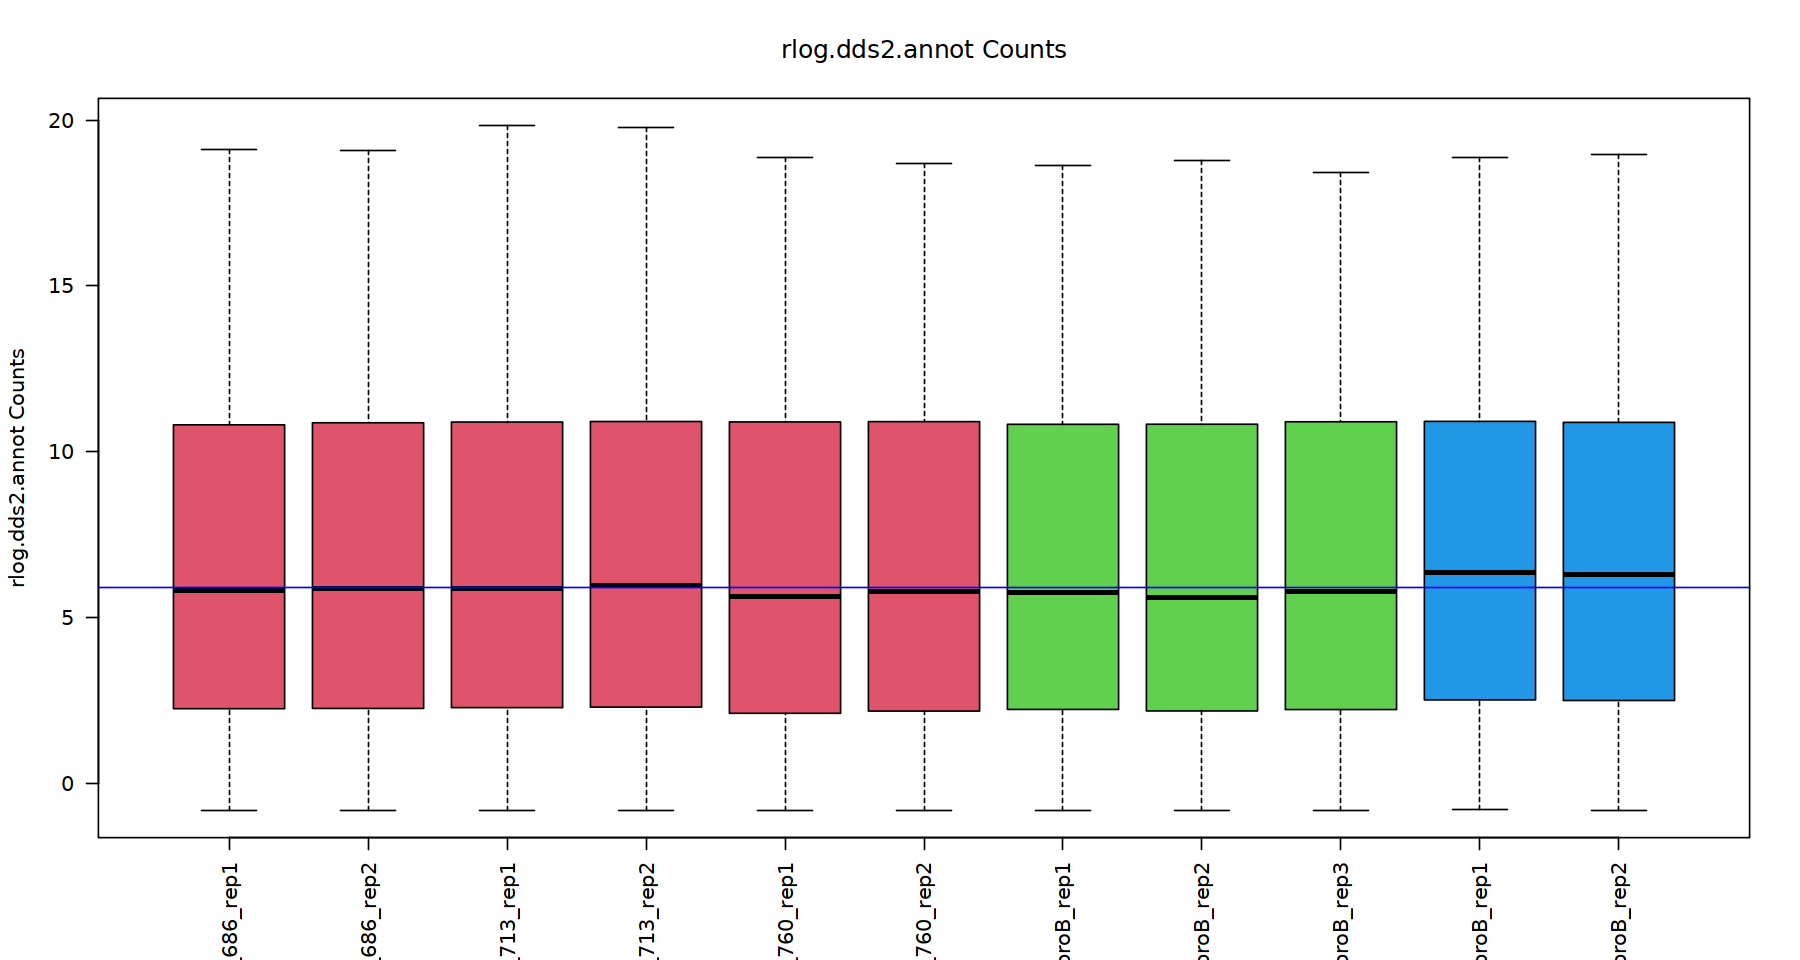

In [17]:
## Code cell 15 ##

# make a colour vector
conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# Check distributions of samples using boxplots, using only the columns with read counts
boxplot(norm_counts[, 3:13], # or can do -c(1:2)
        xlab = "",
        ylab = "rlog.dds2.annot Counts",
        las = 2,
        col = conditionColor,
        main = "rlog.dds2.annot Counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h = median(as.matrix(norm_counts[ , -c(1:2)])), col = "blue")

---
---
## 2 - Principal Component Analysis
---

### 2.1 - PCA on all genes with R base functions
---

#### **2.1-a. Run the PCA**

We performed a first PCA before normalising the data (in Pipe_08), we are now going to see if the normalisation of the read counts enables a better reduction of dimensionality.    
Here, we run again the PCA the same way we did in Pipe_08, but this time on norm data: 

In [19]:
## Code cell 16 ##

# run PCA
PCAdata <- prcomp(t(norm_counts[, -c(1:2)])) # we get rid of the first tow columns of norm_counts that do not contain norm data
summary(PCAdata)

Importance of components:
                           PC1     PC2     PC3      PC4      PC5      PC6
Standard deviation     69.5344 60.2802 44.2752 31.37421 25.31233 19.16228
Proportion of Variance  0.3708  0.2787  0.1503  0.07549  0.04914  0.02816
Cumulative Proportion   0.3708  0.6495  0.7998  0.87527  0.92441  0.95257
                           PC7      PC8      PC9   PC10      PC11
Standard deviation     14.5775 13.58860 11.05387 9.9568 5.887e-14
Proportion of Variance  0.0163  0.01416  0.00937 0.0076 0.000e+00
Cumulative Proportion   0.9689  0.98303  0.99240 1.0000 1.000e+00

#### **2.1-b. Scree plot**

When looking at the summary of the PCA just above, we can see the proportion of the ***inertia*** *(total variance)* explained by each ***eigen vector*** *(other name for PC axis)*. 

The quality of the ACP can be detemined by looking at these proportions.  The higher inertia is explained, the better is the ACP (it means that we maintain at most the shape of the original scatter plot).

To evaluate this quality, we can draw a **scree plot**, that provides a visualisation of the part of variance described in the successive Principal Components (eigen vectors). The first components are always the ones describing the largest part of variance, but a scree plot is a good way to see how many components could be interesting to explore (look at the inflection point).

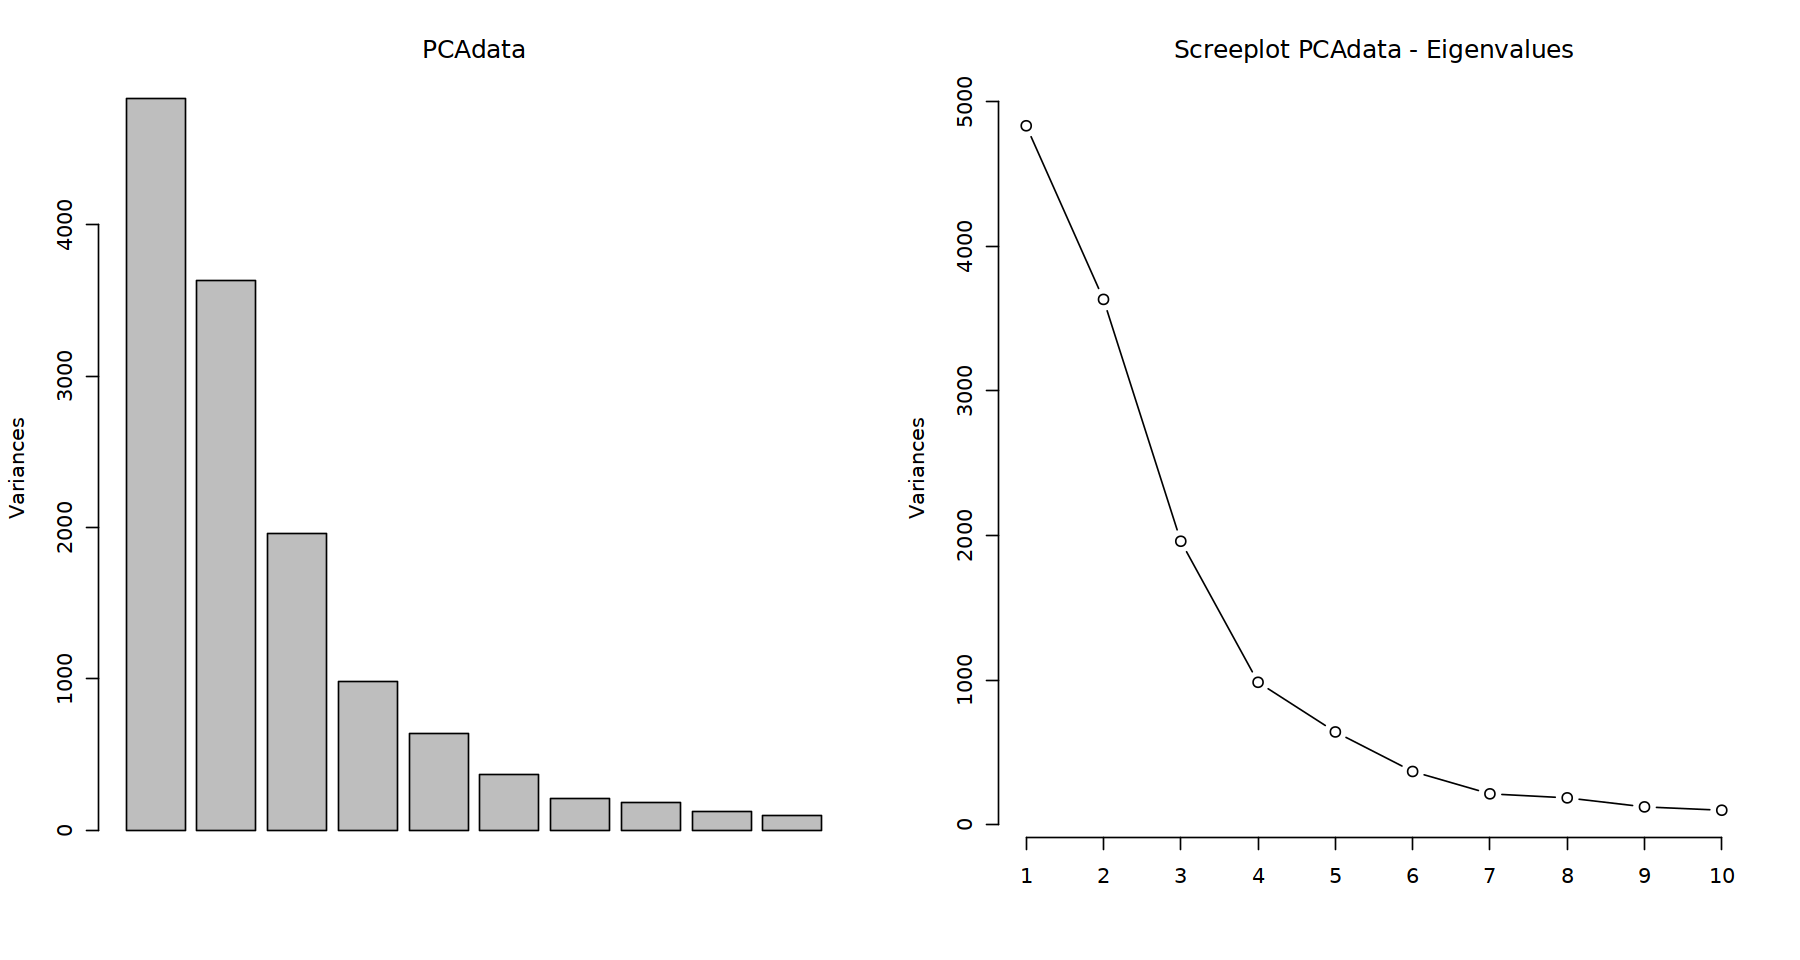

In [20]:
## Code cell 17 ##

# to display the two scree plots side by side
layout(matrix(1:2, ncol = 2))

screeplot(PCAdata) # barplot representation
screeplot(PCAdata, type = "lines", main = "Screeplot PCAdata - Eigenvalues") # same but with a line

Here we see that the first three components explain most of the inertia. We will see further down another package to draw nicer scree plots.

#### **2.1-c. PCA plots**

Now we plot the PCA for the first 2 dimensions, and a second one for the third and fourth PC:

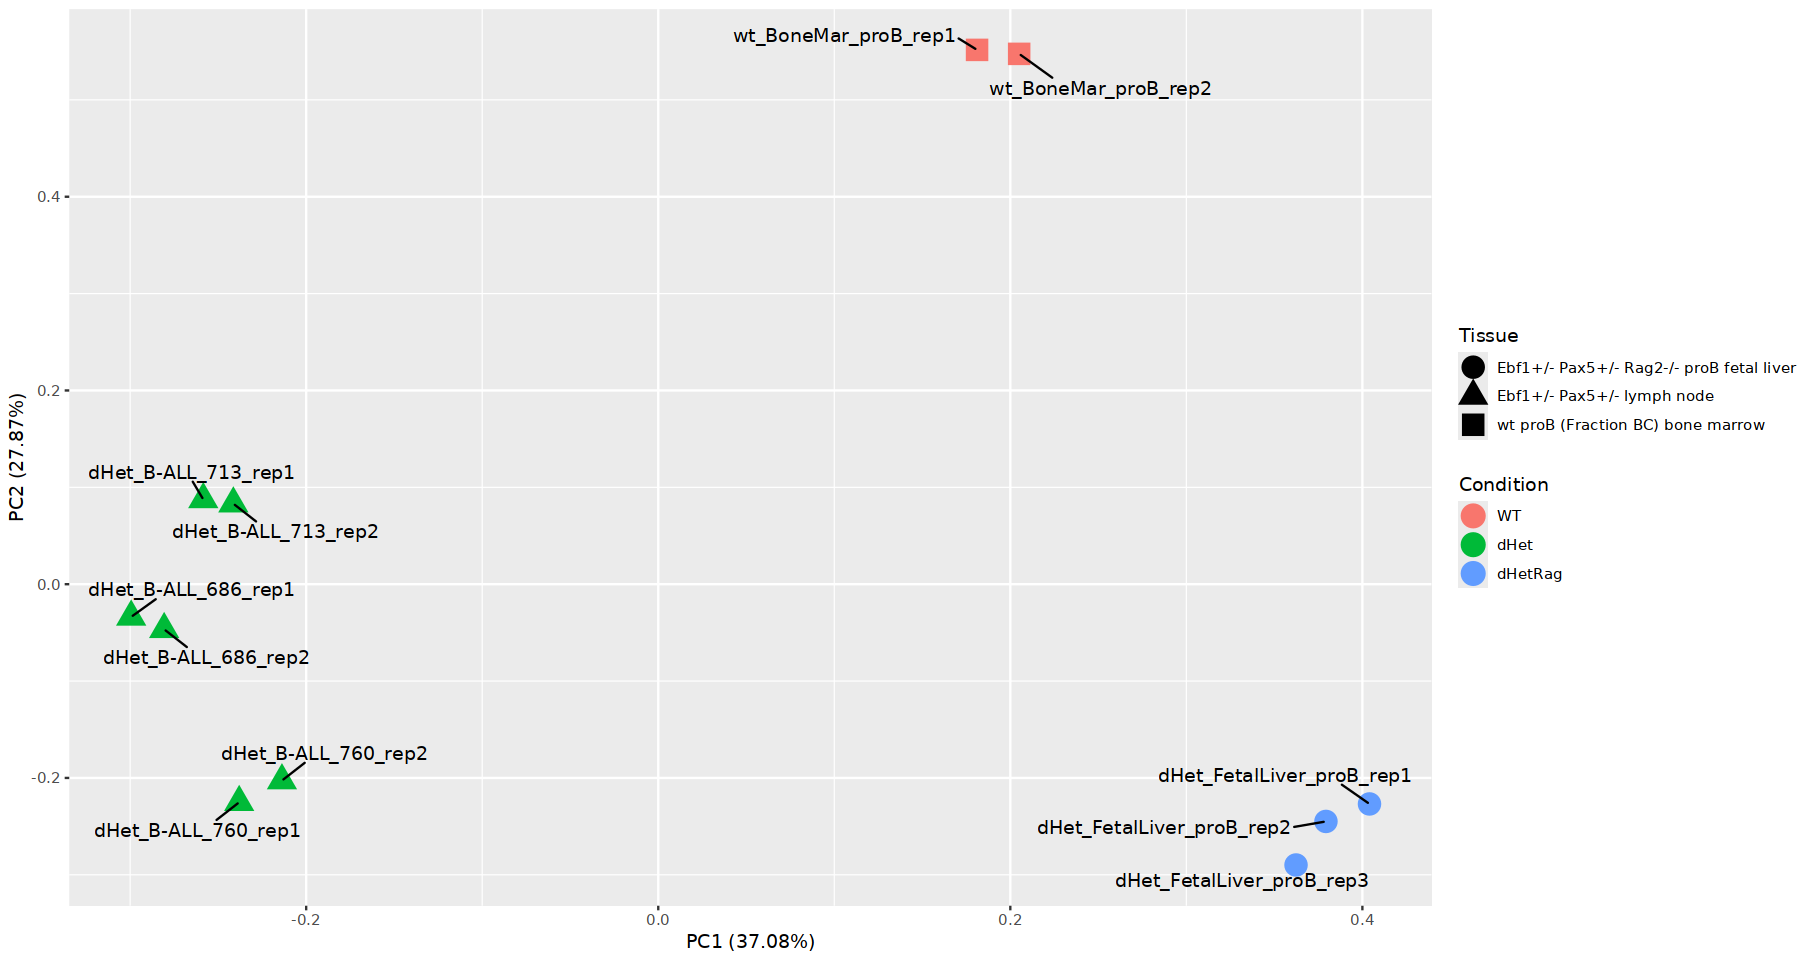

In [21]:
## Code cell 18 ##

autoplot(PCAdata,
         data = samples, 
         colour = "Condition", 
         shape = "Tissue",
         size = 6) +
        geom_text_repel(aes(x = PC1, y = PC2, label = SampleName), box.padding = 0.8)


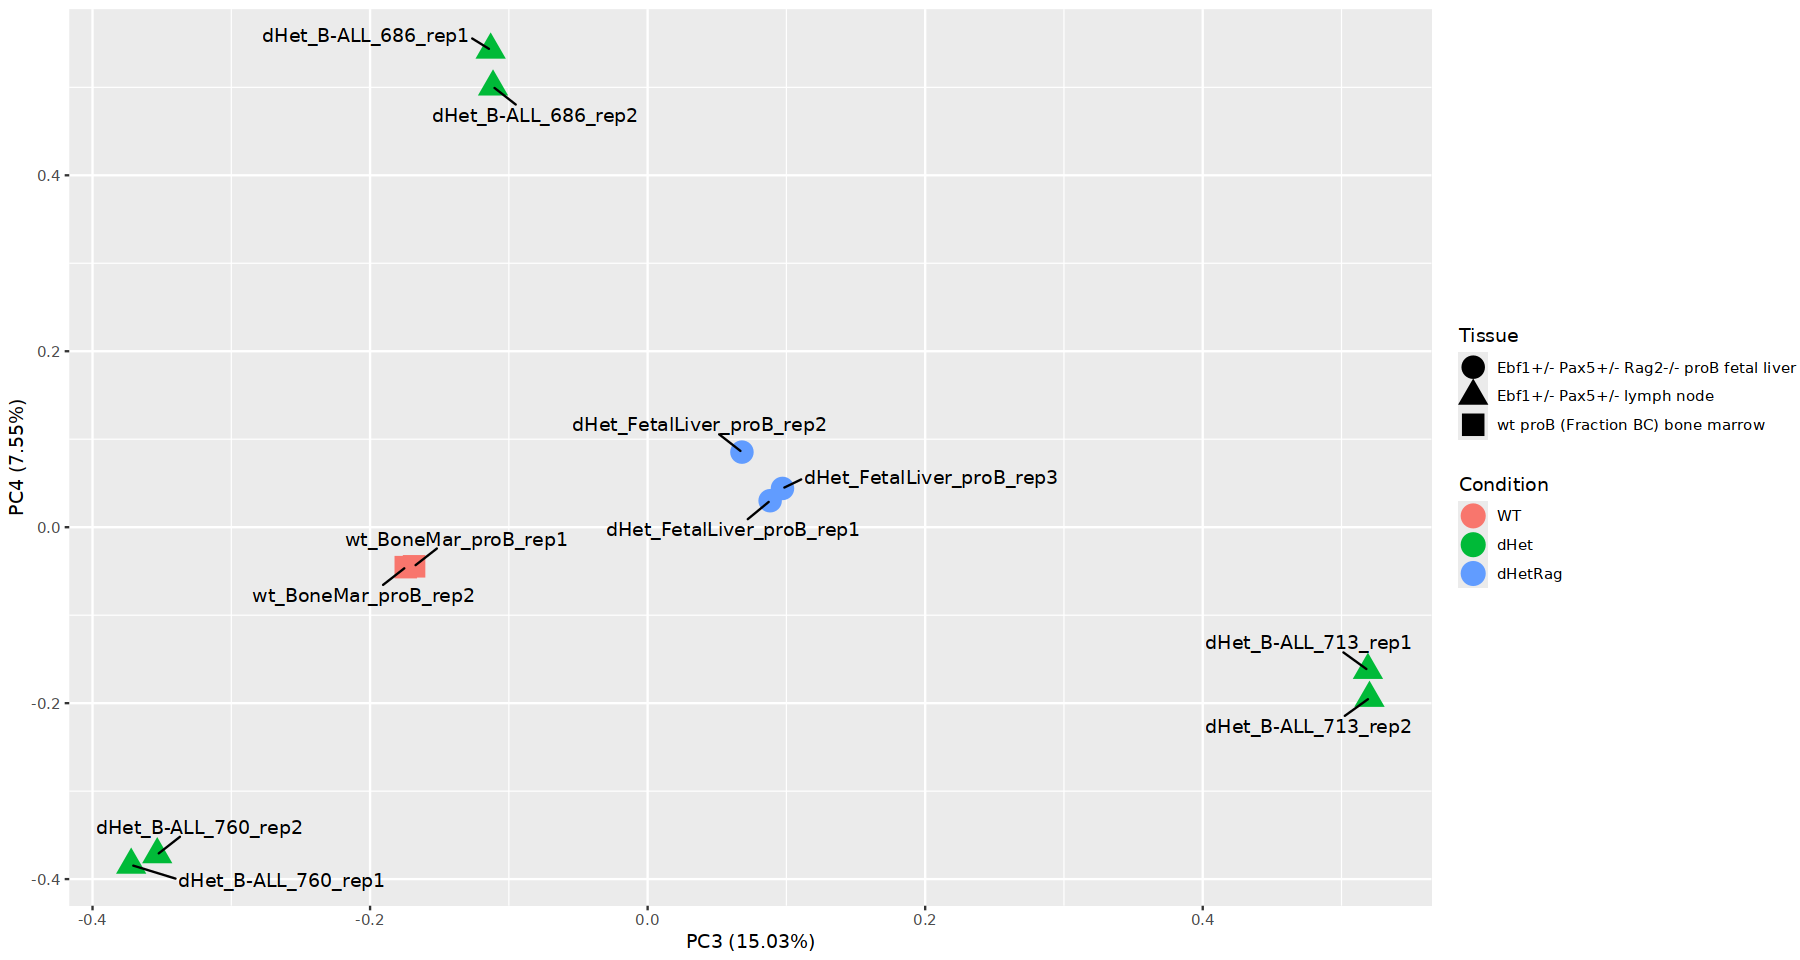

In [22]:
## Code cell 19 ##

autoplot(PCAdata,
         x = 3,    # PC3
         y = 4,    # PC4
         data = samples, 
         colour = "Condition", 
         shape = "Tissue",
         size = 6) +
    geom_text_repel(aes(x = PC3, y = PC4, label = SampleName), box.padding = 0.8)


We can see that, now that we look at the normalised data, PC1 separates clearly the leukemic cells from the non-leukemic cells, and that PC2 separates clearly the dHet cells from the WT ones. Again PC3 and PC4 seem to  separate the various mice, and to group the replicates.   
    

<div class="alert alert-block alert-info"><b>To go furher:</b><br> We will see in sections 2.2 and 2.3 which other plots can be drawn.</div>

---
### 2.2 - PCA on the most variant genes with R base functions
---

#### **2.2-a. Initial number of genes**

*based on ensembl IDs* in our data:

In [23]:
## Code cell 20 ##

length(unique(norm_counts$ensemblID))

[1] 24432

#### __2.2-b - Selection of the **most variable genes**__

<div class="alert alert-block alert-warning"> <b><u> Warning on PCA: </u></b><br><br>

Although we can see a nice separation for our dataset, <b>it is not recommended to use all the genes to perform a PCA </b>, even if we limit to expressed genes. Indeed, the differences between the conditions are likely to be due to a more limited number of genes that do vary because of the conditions in a way that is truly meaningful biologically. <br>  
    <b>So the genes under consideration for a PCA are usually restricted to the most variant ones</b>, i.e the 1000 most variable genes, or the top 5 or 10 %. Two main descriptive statistic values can be used to look at the gene-wise variation : <ol>
    <li><b> the variance </b> (or standard deviation (sd)) of each gene <il>
    <li><b> the coefficient of variation (CV) </b>(<i>i.e sd/mean</i>) of each gene: the most recommanded one to account for the risk of <b><i>'heteroskedasticity'</i></b> (when variance is correlated to the mean, which is not fine to keep doing analyses). Indeed, the coefficient of variation (CV) is a relative measure of variability that indicates the size of a standard deviation in relation to its mean. It is a standardized, unitless measure that allows you to compare variability between disparate groups and characteristics. It is also recommended to use the CV instead of variance when the variables under consideration in the dataset are very different and present large differences in ranges (such as age and dosages, for example). Then the ranges of variations of the different variable conditions have to be scaled. <il>   
</div>    

Here, we are going to select the top 50 genes, on the basis of their variances. Indeed, all considered variables have the same scale (expression levels of the 50 genes). In addition, with the rlog normalization performed by DESeq2, the variance has been stabilized in the model to have homoskedastik data. But we provide you below the code to generate the coefficient of variation for your own analyses.



- using the **coefficient of variation**: we provide the way to compute the CV for reference, but we go on with the variance (in Code cell 22). 



- using the **variance**:

We first compute the variance of all genes, using the `rowVars()` function of the ***matrixStats*** package *(or directly with the R base `apply()` function passing the `var()` function as an argument)*. We also verify that no gene has a null variance:

In [24]:
## Code cell 22 ##

var_genes <- matrixStats::rowVars(as.matrix(norm_counts[ , 3:13]))
#var_genes <- apply(X = norm_counts[, 3:13], MARGIN = 1, FUN = var, na.rm = TRUE) # simmilar way to generate var_genes

head(var_genes)
str(var_genes)
summary(var_genes)

[1] 5.49198140 0.07053780 0.01696256 0.06103877 0.02888587 0.08694377

 num [1:24432] 5.492 0.0705 0.017 0.061 0.0289 ...


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00101  0.05130  0.12783  0.53372  0.35546 21.68080 

We add these variance values to the norm_counts dataframe as a new `var` variable.

In [25]:
## Code cell 23 ##

norm_counts$var <- var_genes
head(norm_counts)

ensemblID             gene_name dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2
1 ENSMUSG00000025902.14 Sox17      2.79304049          1.81549622        
2 ENSMUSG00000104238.2  Gm37587   -0.09021838         -0.08772794        
3 ENSMUSG00000102269.2  Gm7357     1.58287052          1.78910047        
4 ENSMUSG00000098104.2  Gm6085     7.49185409          7.56594425        
5 ENSMUSG00000102175.2  Gm6119     1.03730098          1.32367604        
6 ENSMUSG00000103922.2  Gm6123     6.33118241          6.55309964        
  dHet_B-ALL_713_rep1 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1
1  6.29070228          6.09468679         6.8864018          
2 -0.08588542         -0.08661565         0.1831222          
3  1.65122950          1.41704819         1.6209785          
4  7.92605006          7.74132379         7.7445271          
5  1.21626302          1.51718869         1.0402541          
6  6.52521864          6.27418798         6.7202852          
  dHet_B-ALL_760_rep2 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2
1 7.2603992            1.93132119                1.93466381              
2 0.7787548           -0.08507899               -0.08499663              
3 1.8875758            1.73223396                1.58998943              
4 7.5521564            8.17829270                7.28098828              
5 1.3282378            1.04368392                1.04378812              
6 6.0214489            6.03723997                5.71305280              
  dHet_FetalLiver_proB_rep3 wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
1  1.91549040                1.72255191           2.30844035         
2 -0.08546441               -0.08958484          -0.08811938         
3  1.50497826                1.59297925           1.67453739         
4  7.76238661                7.91715956           7.86305936         
5  1.36784518                1.38720409           1.18951441         
6  5.98925608                6.36704382           6.33498377         
  var       
1 5.49198140
2 0.07053780
3 0.01696256
4 0.06103877
5 0.02888587
6 0.08694377

We sort `norm_counts` on decreasing values of the variance and we add a variable with the rank of the variances.

In [26]:
## Code cell 24 ##

norm_counts <- norm_counts[order(norm_counts$var, decreasing = TRUE),]
norm_counts$rank_var <- 1:nrow(norm_counts)
head(norm_counts)

ensemblID             gene_name dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2
24078 ENSMUSG00000086503.5  Xist       2.746673            2.545051          
15687 ENSMUSG00000072553.11 Gm525     11.221808           11.295811          
13030 ENSMUSG00000032554.16 Trf       14.730692           14.584968          
24378 ENSMUSG00000069049.12 Eif2s3y   11.502397           11.343371          
21581 ENSMUSG00000036594.16 H2-Aa     11.411295           11.397837          
24381 ENSMUSG00000069045.12 Ddx3y     11.972783           11.724160          
      dHet_B-ALL_713_rep1 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1
24078  3.715644            3.054969           11.415092          
15687 14.807659           14.687359           15.866592          
13030 10.458431           10.391838           14.611324          
24378 11.866886           11.843213            3.397107          
21581 13.426328           13.392835            9.452638          
24381 11.745637           11.782772            3.521080          
      dHet_B-ALL_760_rep2 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2
24078 12.177744           12.569900                  2.733470                
15687 15.301316            5.240706                  5.376705                
13030 14.306987            5.316195                  4.494202                
24378  3.421102            3.588793                 11.648114                
21581  9.493174            3.992827                  3.998148                
24381  3.854028            3.712401                 11.950747                
      dHet_FetalLiver_proB_rep3 wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
24078 12.950594                  4.103681             2.935180           
15687  5.512983                  8.348987             8.426962           
13030  4.326974                 12.674413            12.897071           
24378  3.563483                 11.991653            11.531310           
21581  3.967642                 14.133778            13.623318           
24381  5.092793                 12.109824            11.973701           
      var      rank_var
24078 21.68080 1       
15687 17.67689 2       
13030 17.65311 3       
24378 17.07881 4       
21581 16.62016 5       
24381 15.84686 6

We now select only the top 50 most variable genes.

In [27]:
## Code cell 25 ##

top50var <- norm_counts[1:50,]
head(top50var)

ensemblID             gene_name dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2
24078 ENSMUSG00000086503.5  Xist       2.746673            2.545051          
15687 ENSMUSG00000072553.11 Gm525     11.221808           11.295811          
13030 ENSMUSG00000032554.16 Trf       14.730692           14.584968          
24378 ENSMUSG00000069049.12 Eif2s3y   11.502397           11.343371          
21581 ENSMUSG00000036594.16 H2-Aa     11.411295           11.397837          
24381 ENSMUSG00000069045.12 Ddx3y     11.972783           11.724160          
      dHet_B-ALL_713_rep1 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1
24078  3.715644            3.054969           11.415092          
15687 14.807659           14.687359           15.866592          
13030 10.458431           10.391838           14.611324          
24378 11.866886           11.843213            3.397107          
21581 13.426328           13.392835            9.452638          
24381 11.745637           11.782772            3.521080          
      dHet_B-ALL_760_rep2 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2
24078 12.177744           12.569900                  2.733470                
15687 15.301316            5.240706                  5.376705                
13030 14.306987            5.316195                  4.494202                
24378  3.421102            3.588793                 11.648114                
21581  9.493174            3.992827                  3.998148                
24381  3.854028            3.712401                 11.950747                
      dHet_FetalLiver_proB_rep3 wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
24078 12.950594                  4.103681             2.935180           
15687  5.512983                  8.348987             8.426962           
13030  4.326974                 12.674413            12.897071           
24378  3.563483                 11.991653            11.531310           
21581  3.967642                 14.133778            13.623318           
24381  5.092793                 12.109824            11.973701           
      var      rank_var
24078 21.68080 1       
15687 17.67689 2       
13030 17.65311 3       
24378 17.07881 4       
21581 16.62016 5       
24381 15.84686 6

We verify the size of the `top50var`dataframe, and if we have indeed unique ensemblIDs. 

In [28]:
## Code cell 26 ##

str(top50var)
dim(top50var)
length(unique(top50var$ensemblID))

head(top50var, n = 5)

'data.frame':	50 obs. of  15 variables:
 $ ensemblID                : 'AsIs' chr  "ENSMUSG00000086503.5" "ENSMUSG00000072553.11" "ENSMUSG00000032554.16" "ENSMUSG00000069049.12" ...
 $ gene_name                : chr  "Xist" "Gm525" "Trf" "Eif2s3y" ...
 $ dHet_B-ALL_686_rep1      : num  2.75 11.22 14.73 11.5 11.41 ...
 $ dHet_B-ALL_686_rep2      : num  2.55 11.3 14.58 11.34 11.4 ...
 $ dHet_B-ALL_713_rep1      : num  3.72 14.81 10.46 11.87 13.43 ...
 $ dHet_B-ALL_713_rep2      : num  3.05 14.69 10.39 11.84 13.39 ...
 $ dHet_B-ALL_760_rep1      : num  11.42 15.87 14.61 3.4 9.45 ...
 $ dHet_B-ALL_760_rep2      : num  12.18 15.3 14.31 3.42 9.49 ...
 $ dHet_FetalLiver_proB_rep1: num  12.57 5.24 5.32 3.59 3.99 ...
 $ dHet_FetalLiver_proB_rep2: num  2.73 5.38 4.49 11.65 4 ...
 $ dHet_FetalLiver_proB_rep3: num  12.95 5.51 4.33 3.56 3.97 ...
 $ wt_BoneMar_proB_rep1     : num  4.1 8.35 12.67 11.99 14.13 ...
 $ wt_BoneMar_proB_rep2     : num  2.94 8.43 12.9 11.53 13.62 ...
 $ var                  

[1] 50 15

[1] 50

ensemblID             gene_name dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2
24078 ENSMUSG00000086503.5  Xist       2.746673            2.545051          
15687 ENSMUSG00000072553.11 Gm525     11.221808           11.295811          
13030 ENSMUSG00000032554.16 Trf       14.730692           14.584968          
24378 ENSMUSG00000069049.12 Eif2s3y   11.502397           11.343371          
21581 ENSMUSG00000036594.16 H2-Aa     11.411295           11.397837          
      dHet_B-ALL_713_rep1 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1
24078  3.715644            3.054969           11.415092          
15687 14.807659           14.687359           15.866592          
13030 10.458431           10.391838           14.611324          
24378 11.866886           11.843213            3.397107          
21581 13.426328           13.392835            9.452638          
      dHet_B-ALL_760_rep2 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2
24078 12.177744           12.569900                  2.733470                
15687 15.301316            5.240706                  5.376705                
13030 14.306987            5.316195                  4.494202                
24378  3.421102            3.588793                 11.648114                
21581  9.493174            3.992827                  3.998148                
      dHet_FetalLiver_proB_rep3 wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
24078 12.950594                  4.103681             2.935180           
15687  5.512983                  8.348987             8.426962           
13030  4.326974                 12.674413            12.897071           
24378  3.563483                 11.991653            11.531310           
21581  3.967642                 14.133778            13.623318           
      var      rank_var
24078 21.68080 1       
15687 17.67689 2       
13030 17.65311 3       
24378 17.07881 4       
21581 16.62016 5

We also notice these 50 genes have a unique gene_name and sort the dataframe by gene name.

In [29]:
## Code cell 27 ##

length(unique(top50var$gene_name))
top50var <- top50var[order(top50var$gene_name, decreasing = TRUE),]
head(top50var)

[1] 50

ensemblID             gene_name dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2
24078 ENSMUSG00000086503.5  Xist       2.746673            2.545051          
24380 ENSMUSG00000068457.15 Uty       10.771582           10.080841          
13876 ENSMUSG00000033427.15 Upb1       1.031205            1.857411          
17553 ENSMUSG00000091682.4  Trgc3      1.464698            1.647351          
17554 ENSMUSG00000076752.3  Trgc2      5.005345            5.244513          
13030 ENSMUSG00000032554.16 Trf       14.730692           14.584968          
      dHet_B-ALL_713_rep1 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1
24078  3.715644            3.054969           11.415092          
24380 10.574867           10.067801            3.090502          
13876  1.675849            2.777745            1.850854          
17553  7.281517            7.128790            1.641378          
17554  5.668985            5.482718            4.643928          
13030 10.458431           10.391838           14.611324          
      dHet_B-ALL_760_rep2 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2
24078 12.177744           12.569900                  2.733470                
24380  3.303381            3.277964                 10.358659                
13876  1.210811            1.343153                  1.347312                
17553  1.662663            3.323318                  6.458068                
17554  5.004666            8.477597                 10.129951                
13030 14.306987            5.316195                  4.494202                
      dHet_FetalLiver_proB_rep3 wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
24078 12.950594                  4.103681             2.935180           
24380  3.253234                 10.007461            10.261961           
13876  1.323412                 10.203933             9.661219           
17553 11.819052                  1.514601             1.620861           
17554 14.668171                  3.116446             3.391028           
13030  4.326974                 12.674413            12.897071           
      var      rank_var
24078 21.68080  1      
24380 12.78257 19      
13876 11.59125 40      
17553 12.27998 24      
17554 11.60969 39      
13030 17.65311  3

- looking at **the 50 most variable genes**

We can have a quick glance at those genes, to see if we recognize some of them... and indeed, the first one is interesting! :-D 

In [34]:
## Code cell 28 ##

top50var$gene_name

[1] "Xist"          "Uty"           "Upb1"          "Trgc3"        
 [5] "Trgc2"         "Trf"           "Tmem98"        "Tgfa"         
 [9] "Slc30a4"       "Siglech"       "Rnase11"       "Rnase10"      
[13] "Plxna2"        "Pcdh11x"       "Nyx"           "Ngp"          
[17] "Mrgpra1"       "Mpeg1"         "Ly86"          "Lrrc4c"       
[21] "Lpar1"         "Lgr5"          "Kdm5d"         "Jchain"       
[25] "Iglc1"         "Igkv6-23"      "Igkv6-15"      "Ighv5-2"      
[29] "Ighd4-1"       "Igha"          "Hs3st2"        "Hbb-bs"       
[33] "H2-Eb1"        "H2-Aa"         "Gng4"          "Gm57259"      
[37] "Gm525"         "Garem1"        "Ephb4"         "Eif2s3y"      
[41] "Efna5"         "Ddx3y"         "Ctsh"          "Crisp1"       
[45] "Cdh17"         "Cd74"          "Cd300c"        "Cd209a"       
[49] "Bahcc1"        "A630031M04Rik"

In order to use this dataframe for the next steps, we put the gene names as row names (instead of numbers). 

In [35]:
## Code cell 29 ##

row.names(top50var) <- top50var$gene_name

- **Are they differentially expressed?** 

Since we are curious, we may wonder where these top 50 variable genes fall within the DE analysis.

    - We first look at the DE object:

In [36]:
## Code cell 30 ##

str(res2_dHet_dHetRag_sig_ranked_annot)

'data.frame':	7374 obs. of  17 variables:
 $ ensemblID     : 'AsIs' chr  "ENSMUSG00000117613.3" "ENSMUSG00000024241.8" "ENSMUSG00000070348.6" "ENSMUSG00000021423.7" ...
 $ baseMean      : num  3233 11366 10922 5928 508 ...
 $ log2FoldChange: num  7.62 5.03 7.18 11.57 -4.02 ...
 $ lfcSE         : num  0.303 0.207 0.348 0.591 0.206 ...
 $ stat          : num  25.2 24.3 20.6 19.6 -19.5 ...
 $ pvalue        : num  1.04e-139 2.19e-130 1.42e-94 2.45e-85 6.71e-85 ...
 $ padj          : num  2.29e-135 2.41e-126 1.05e-90 1.35e-81 2.96e-81 ...
 $ chr           : chr  "chr18" "chr17" "chr7" "chr13" ...
 $ annotation    : chr  "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
 $ start         : num  1.53e+07 8.07e+07 1.44e+08 3.75e+07 9.11e+07 ...
 $ end           : num  1.54e+07 8.08e+07 1.44e+08 3.76e+07 9.13e+07 ...
 $ strand        : chr  "+" "-" "-" "+" ...
 $ gene_type     : chr  "lncRNA" "protein_coding" "protein_coding" "protein_coding" ...
 $ gene_name     : chr  "Gm2629" "Sos1" "Ccnd1" "Ly86" ...


    - We generate a new variable with the rank of each gene in the DE analysis:

In [37]:
## Code cell 31 ##

res2_dHet_dHetRag_sig_ranked_annot$rank_DE <- 1:nrow(res2_dHet_dHetRag_sig_ranked_annot)
str(res2_dHet_dHetRag_sig_ranked_annot)

'data.frame':	7374 obs. of  18 variables:
 $ ensemblID     : 'AsIs' chr  "ENSMUSG00000117613.3" "ENSMUSG00000024241.8" "ENSMUSG00000070348.6" "ENSMUSG00000021423.7" ...
 $ baseMean      : num  3233 11366 10922 5928 508 ...
 $ log2FoldChange: num  7.62 5.03 7.18 11.57 -4.02 ...
 $ lfcSE         : num  0.303 0.207 0.348 0.591 0.206 ...
 $ stat          : num  25.2 24.3 20.6 19.6 -19.5 ...
 $ pvalue        : num  1.04e-139 2.19e-130 1.42e-94 2.45e-85 6.71e-85 ...
 $ padj          : num  2.29e-135 2.41e-126 1.05e-90 1.35e-81 2.96e-81 ...
 $ chr           : chr  "chr18" "chr17" "chr7" "chr13" ...
 $ annotation    : chr  "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
 $ start         : num  1.53e+07 8.07e+07 1.44e+08 3.75e+07 9.11e+07 ...
 $ end           : num  1.54e+07 8.08e+07 1.44e+08 3.76e+07 9.13e+07 ...
 $ strand        : chr  "+" "-" "-" "+" ...
 $ gene_type     : chr  "lncRNA" "protein_coding" "protein_coding" "protein_coding" ...
 $ gene_name     : chr  "Gm2629" "Sos1" "Ccnd1" "Ly86" ...


    - We look at the rank of the 50 most variable genes in the DE analysis

In [38]:
## Code cell 32 ##

merge(top50var, res2_dHet_dHetRag_sig_ranked_annot[,-14],
      by = "ensemblID", all = FALSE, sort = FALSE) [,c("ensemblID", "gene_name", "rank_var", "rank_DE", "log2FoldChange", "padj")]

ensemblID             gene_name     rank_var rank_DE log2FoldChange
1  ENSMUSG00000076752.3  Trgc2         39        182     -9.057323    
2  ENSMUSG00000032554.16 Trf            3        169     12.387426    
3  ENSMUSG00000029999.15 Tgfa          50       1638     -9.923557    
4  ENSMUSG00000005802.13 Slc30a4       33         76     -8.190011    
5  ENSMUSG00000051504.19 Siglech       13       1158      8.841265    
6  ENSMUSG00000059648.4  Rnase11       47         90      7.887899    
7  ENSMUSG00000021872.9  Rnase10       31       1545      7.233226    
8  ENSMUSG00000026640.13 Plxna2        48        114     -9.327901    
9  ENSMUSG00000051228.6  Nyx           18         92    -12.648336    
10 ENSMUSG00000050650.8  Mrgpra1        9       5938      7.859858    
11 ENSMUSG00000046805.12 Mpeg1         43       1909      7.098470    
12 ENSMUSG00000021423.7  Ly86          14          4     11.566314    
13 ENSMUSG00000050587.15 Lrrc4c        15       1091     12.591386    
14 ENSMUSG00000038668.15 Lpar1         37        303     -8.229799    
15 ENSMUSG00000020140.16 Lgr5          20       4549     -5.508350    
16 ENSMUSG00000067149.7  Jchain        34         88      8.738507    
17 ENSMUSG00000105906.2  Iglc1         25        647      9.673249    
18 ENSMUSG00000095630.3  Igkv6-23      42       1304     10.460662    
19 ENSMUSG00000094797.2  Igkv6-15      27       1265      8.537611    
20 ENSMUSG00000076633.9  Ighv5-2       29       1825     11.848303    
21 ENSMUSG00000094028.2  Ighd4-1       16         38    -12.539438    
22 ENSMUSG00000095079.7  Igha          10        248     13.179514    
23 ENSMUSG00000046321.9  Hs3st2        12        118     38.745809    
24 ENSMUSG00000052305.7  Hbb-bs        41        498     13.543594    
25 ENSMUSG00000060586.12 H2-Eb1        17        268     12.708666    
26 ENSMUSG00000036594.16 H2-Aa          5        161     14.840539    
27 ENSMUSG00000021303.15 Gng4          44        560     -6.577396    
28 ENSMUSG00000120417.1  Gm57259       46         41      8.938152    
29 ENSMUSG00000072553.11 Gm525          2         55     11.431548    
30 ENSMUSG00000042680.9  Garem1         8         49    -13.195492    
31 ENSMUSG00000048915.13 Efna5         32       2808      8.177133    
32 ENSMUSG00000032359.15 Ctsh          38        885      8.512246    
33 ENSMUSG00000025431.5  Crisp1        22         31      7.519843    
34 ENSMUSG00000028217.12 Cdh17         49        213      6.679723    
35 ENSMUSG00000024610.17 Cd74          36        442      7.686227    
36 ENSMUSG00000031494.8  Cd209a        28       3411      8.880058    
37 ENSMUSG00000039741.17 Bahcc1        26          7     -9.950583    
38 ENSMUSG00000087470.4  A630031M04Rik 30        378     10.914078    
   padj        
1  1.664648e-19
2  5.178526e-20
3  3.122647e-06
4  2.322242e-30
5  1.357558e-07
6  5.928700e-28
7  1.861197e-06
8  2.318328e-25
9  1.222332e-27
10 1.827386e-02
11 1.160965e-05
12 1.347471e-81
13 8.716076e-08
14 1.964078e-14
15 4.391062e-03
16 4.852080e-28
17 2.488248e-10
18 4.287899e-07
19 3.215943e-07
20 7.397308e-06
21 4.114562e-45
22 4.331207e-16
23 5.458781e-25
24 1.019770e-11
25 1.576473e-15
26 1.125141e-20
27 5.498842e-11
28 2.063995e-42
29 1.986072e-35
30 4.219328e-37
31 1.958543e-04
32 8.354207e-09
33 5.253220e-48
34 1.558161e-17
35 2.240688e-12
36 7.211729e-04
37 6.663608e-80
38 2.750974e-13

We notice that Xist, the top var gene, is not among the DE genes...neither 11 other genes :

In [39]:
## Code cell 33 ##

setdiff(top50var$gene_name, res2_dHet_dHetRag_sig_ranked_annot$gene_name)

[1] "Xist"    "Uty"     "Upb1"    "Trgc3"   "Tmem98"  "Pcdh11x" "Ngp"    
 [8] "Kdm5d"   "Ephb4"   "Eif2s3y" "Ddx3y"   "Cd300c"

They may have been removed by DESeq2 during the DE analysis as they were considered as outliers...

Reciprocally, if we look at the top50 DE expressed genes, they are not all in the list of the most variable genes. Indeed, the most variable genes may vary whatever the conditions, while DE genes vary between conditions!

In [40]:
## Code cell 34 ##

top50DE <- res2_dHet_dHetRag_sig_ranked_annot[1:50, ]
setdiff(top50DE$gene_name, top50var$gene_name) # list the top50 DE genes that are not among the top50 var genes
merge(top50DE, norm_counts[, - 2], by = "ensemblID", all.x = TRUE, all.Y = TRUE, sort = FALSE)[,c("ensemblID", "gene_name", "rank_var", "rank_DE", "log2FoldChange", "padj")]

[1] "Gm2629"   "Sos1"     "Ccnd1"    "Cstpp1"   "Hexa"     "Gm12057" 
 [7] "Ighj4"    "Erc1"     "Mylk"     "Maged1"   "Ccdc166"  "Gm57087" 
[13] "Ighj1"    "Gpam"     "Eng"      "Ighm"     "Hdac5"    "Rassf4"  
[19] "Gpcpd1"   "Ass1"     "Mfsd10"   "Pglyrp2"  "Slc1a5"   "Gcnt1"   
[25] "Prickle3" "Ighj2"    "Sdr39u1"  "Il18rap"  "Gria2"    "Rtl6"    
[31] "Btla"     "Ryr2"     "Gm46597"  "Ston1"    "Spr"      "Slc39a11"
[37] "Fbxo30"   "H2-DMb1"  "Sh2d2a"   "Entrep3"  "Pcyt1a"   "Lcp1"    
[43] "Armcx3"   "Gimap7"

ensemblID             gene_name rank_var rank_DE log2FoldChange
1  ENSMUSG00000117613.3  Gm2629     177      1        7.619955    
2  ENSMUSG00000024241.8  Sos1       468      2        5.028573    
3  ENSMUSG00000070348.6  Ccnd1      212      3        7.178419    
4  ENSMUSG00000021423.7  Ly86        14      4       11.566314    
5  ENSMUSG00000040591.19 Cstpp1    1146      5       -4.017643    
6  ENSMUSG00000025232.9  Hexa      2659      6        2.658209    
7  ENSMUSG00000039741.17 Bahcc1      26      7       -9.950583    
8  ENSMUSG00000084081.4  Gm12057    155      8       -6.258479    
9  ENSMUSG00000076618.2  Ighj4     1579      9       -3.254071    
10 ENSMUSG00000030172.16 Erc1       409     10       -5.538294    
11 ENSMUSG00000022836.12 Mylk        96     11        8.419124    
12 ENSMUSG00000025151.17 Maged1     264     12       -5.815095    
13 ENSMUSG00000098176.3  Ccdc166   3490     13        2.237021    
14 ENSMUSG00000120365.1  Gm57087   1645     14        3.565482    
15 ENSMUSG00000076621.2  Ighj1      180     15       -6.923407    
16 ENSMUSG00000024978.12 Gpam      1339     16       -3.614440    
17 ENSMUSG00000026814.17 Eng       1238     17        4.116966    
18 ENSMUSG00000076617.10 Ighm      1883     18       -2.772907    
19 ENSMUSG00000008855.18 Hdac5     1319     19       -3.642608    
20 ENSMUSG00000042129.9  Rassf4     895     20        3.785175    
21 ENSMUSG00000027346.16 Gpcpd1    3550     21       -1.872512    
22 ENSMUSG00000076441.10 Ass1      3020     22        2.300048    
23 ENSMUSG00000001082.13 Mfsd10    4685     23        1.763326    
24 ENSMUSG00000079563.11 Pglyrp2   1331     24        3.180033    
25 ENSMUSG00000001918.18 Slc1a5    3156     25       -2.302495    
26 ENSMUSG00000038843.19 Gcnt1     2484     26        2.646497    
27 ENSMUSG00000031145.16 Prickle3  2890     27        2.553069    
28 ENSMUSG00000076620.3  Ighj2     1374     28       -3.659106    
29 ENSMUSG00000022223.10 Sdr39u1   2474     29        2.853057    
30 ENSMUSG00000026068.12 Il18rap    382     30        5.411386    
31 ENSMUSG00000025431.5  Crisp1      22     31        7.519843    
32 ENSMUSG00000033981.15 Gria2      527     32        5.491477    
33 ENSMUSG00000055745.5  Rtl6       901     33        4.532160    
34 ENSMUSG00000052013.16 Btla       916     34        4.351629    
35 ENSMUSG00000021313.18 Ryr2       127     35        5.343843    
36 ENSMUSG00000121244.1  Gm46597    203     36        8.580063    
37 ENSMUSG00000033855.16 Ston1      716     37        5.375392    
38 ENSMUSG00000094028.2  Ighd4-1     16     38      -12.539438    
39 ENSMUSG00000033735.10 Spr       5427     39        1.631408    
40 ENSMUSG00000041654.16 Slc39a11  4698     40        1.681230    
41 ENSMUSG00000120417.1  Gm57259     46     41        8.938152    
42 ENSMUSG00000047648.14 Fbxo30    1787     42       -3.224420    
43 ENSMUSG00000079547.5  H2-DMb1    402     43        5.922217    
44 ENSMUSG00000028071.13 Sh2d2a    2685     44        2.264367    
45 ENSMUSG00000032657.16 Entrep3   1013     45        4.527656    
46 ENSMUSG00000005615.16 Pcyt1a    2032     46       -3.013776    
47 ENSMUSG00000021998.17 Lcp1      5491     47        1.276269    
48 ENSMUSG00000049047.12 Armcx3     248     48       -5.993963    
49 ENSMUSG00000042680.9  Garem1       8     49      -13.195492    
50 ENSMUSG00000043931.11 Gimap7    1221     50        4.079687    
   padj         
1  2.289997e-135
2  2.405904e-126
3   1.045695e-90
4   1.347471e-81
5   2.955626e-81
6   1.549561e-80
7   6.663608e-80
8   1.188053e-77
9   3.519191e-77
10  1.246997e-75
11  3.346760e-73
12  4.939590e-70
13  5.106009e-70
14  2.274989e-68
15  7.173362e-68
16  2.583823e-66
17  8.408404e-66
18  1.233089e-64
19  3.147700e-63
20  6.835127e-59
21  1.038965e-56
22  5.018835e-56
23  7.349090e-56
24  1.022661e-54
25  2.345144e-51
26  1.314775e-50
27  1.481019e-50
28  1.254126e-48
29  1.688456e-48
30  3.622711e-48
31  5.253220e-48
32  6.446464e-48
33  8.084366e-47
34  8.55

We will further get gene expression data of "Gm2629" and "Sos1", the first and second genes in the DE analysis that are not among the top 50 var genes.

--
#### __2.2-c - PCA on the top 50 var genes__

We now use these top 50 variable genes to perform a proper PCA:

In [41]:
## Code cell 35 ##

# run PCA
PCAdata2 <- prcomp(t(top50var[, 3:13]))


* **Scree plot**

We display the corresponding scree plot :

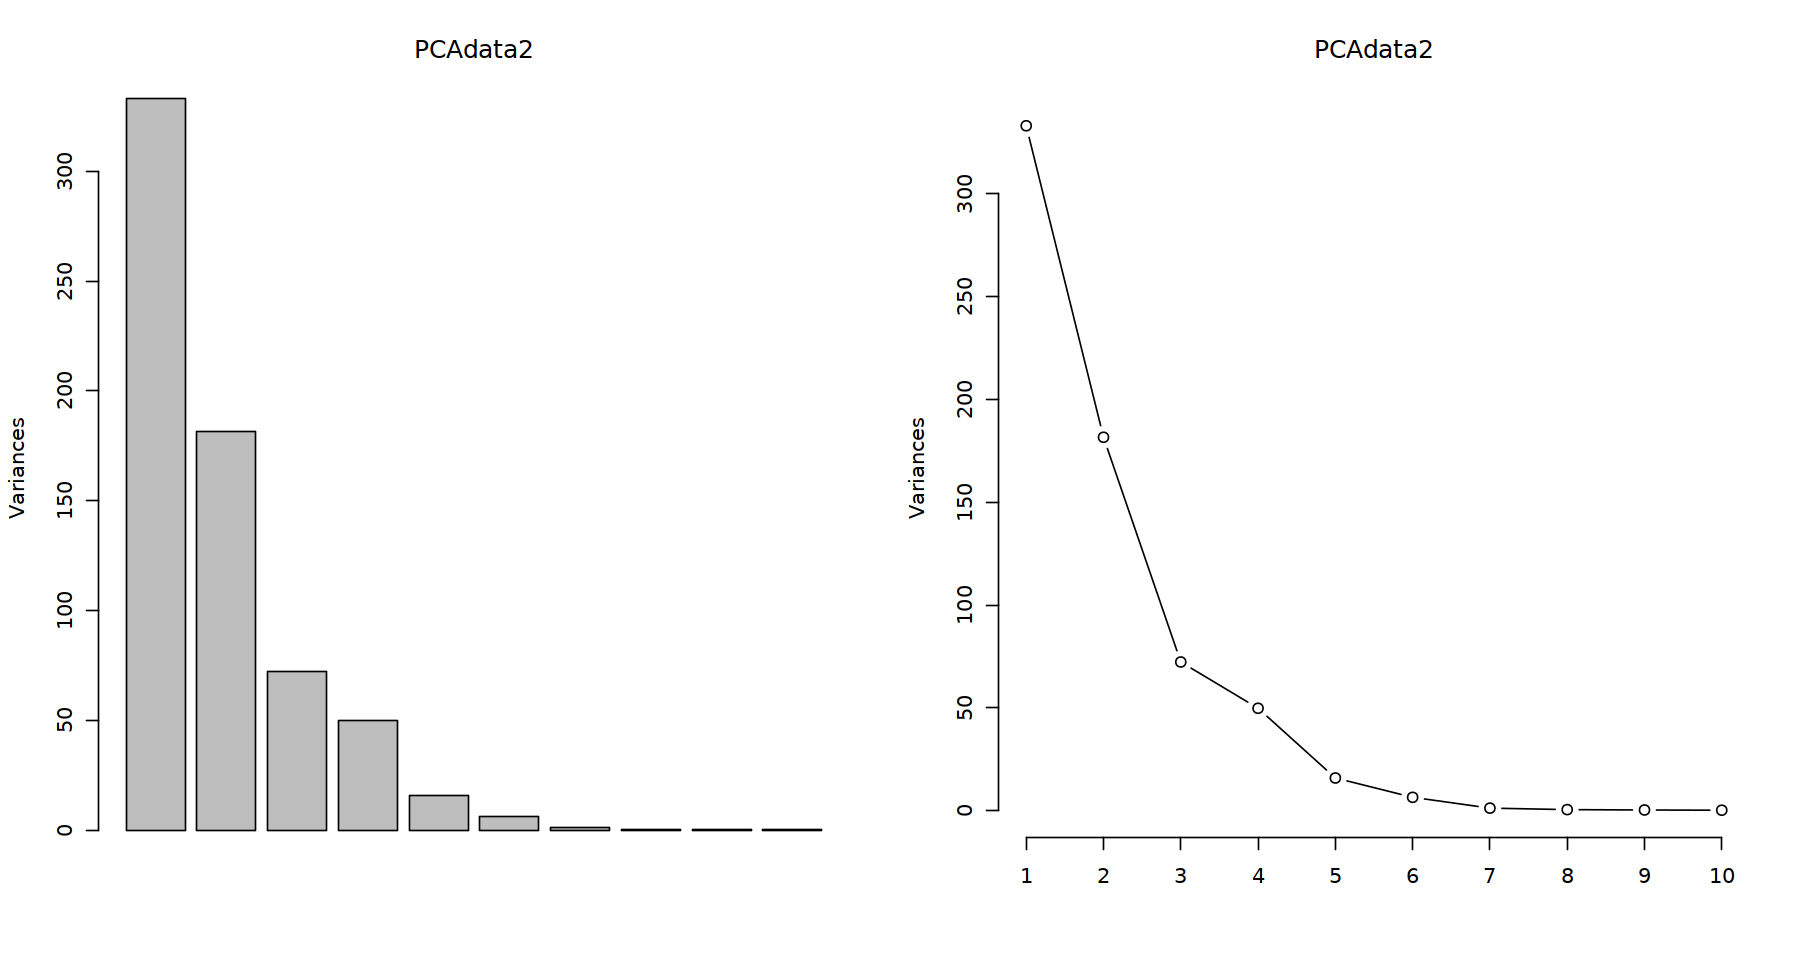

In [42]:
## Code cell 36 ##

# to display the two scree plots side by side
layout(matrix(1:2, ncol = 2))

screeplot(PCAdata2)
screeplot(PCAdata2, type = "lines")

The scree plot confirms that there is  no interest in looking into PC dimensions beyond PC3 or PC4, as the remaining ones explain very little parts of the inertia (or total variance).  

* **PCA plots**

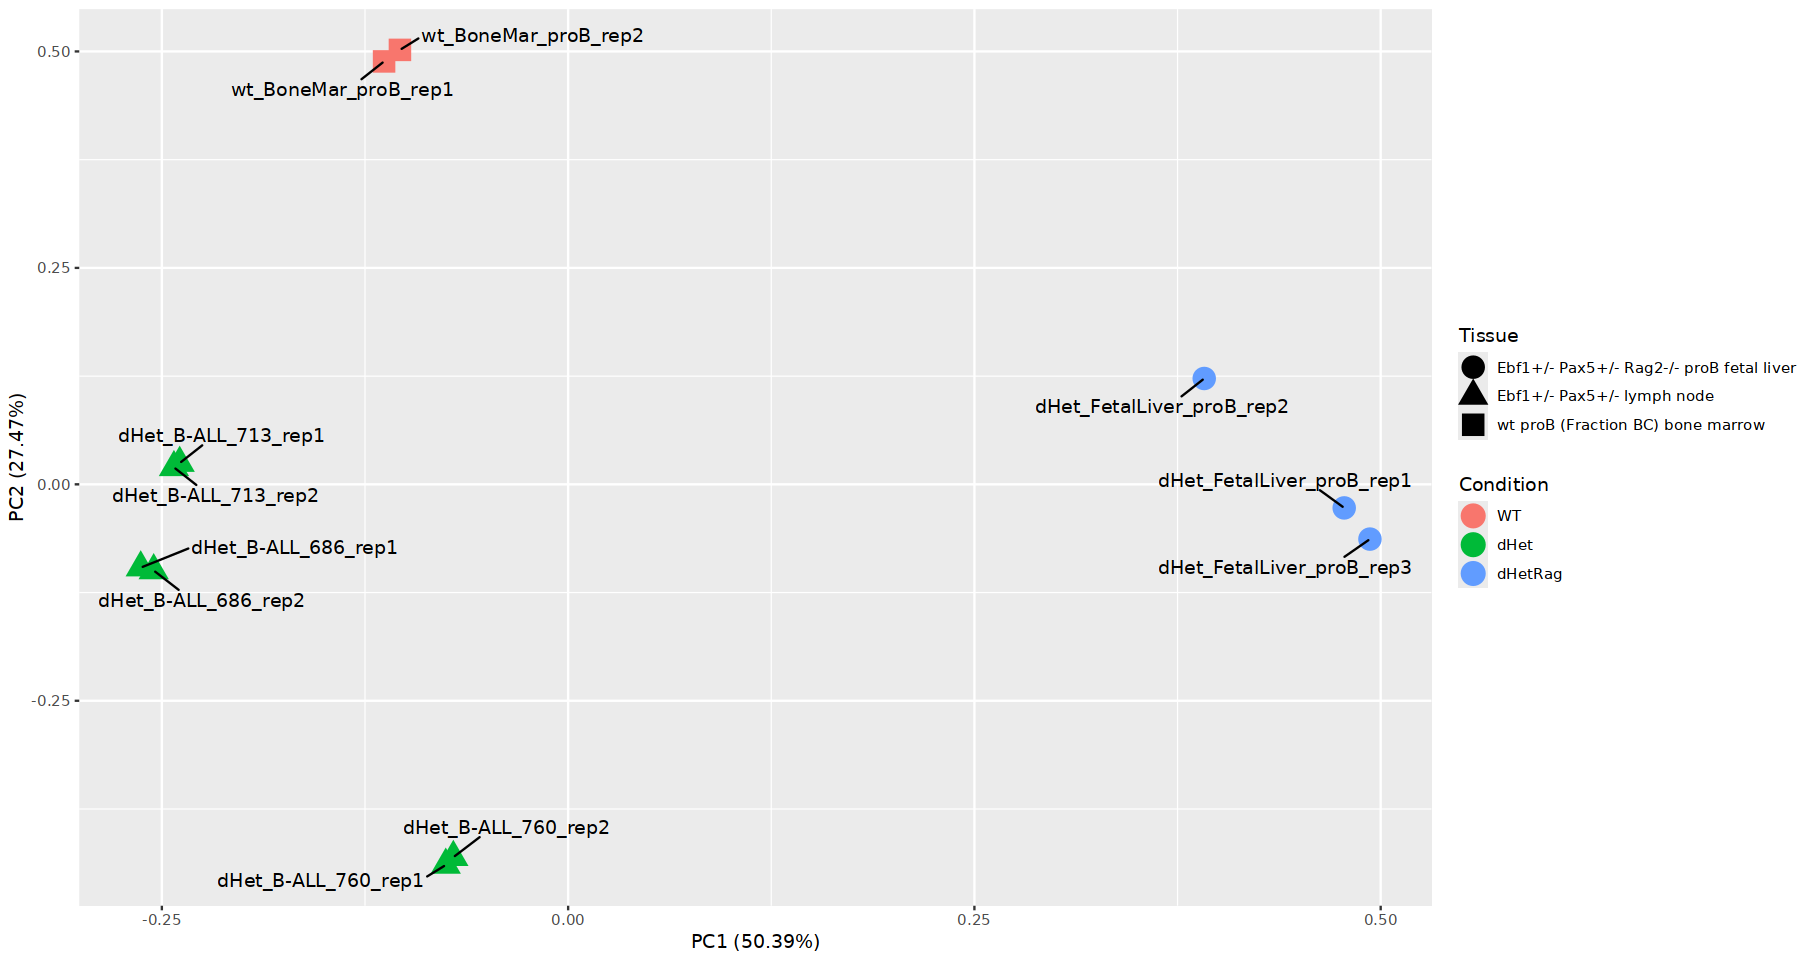

In [43]:
## Code cell 37 ##

autoplot(PCAdata2,
         data = samples, 
         colour = "Condition", 
         shape = "Tissue",
         size = 6) +
        geom_text_repel(aes(x = PC1, y = PC2, label = SampleName), box.padding = 0.8)


We can see that the portion of variance explained by PC1 and PC2 is higher, when we take into consideration only our top genes. This is indeed logical, as these genes are likely to be the most impacted by the change of conditions.   


* **Correlation circle**
 
The correlation circle plot is a very popular way for visualization of results from PCA, as it combines both the principal component scores and the loading vectors *(the variables)* that mostly contribute to the PC axes in a single display. Here, each vector represents a gene, and the arrow represents the influence of this gene on the PC: the longer the arrow, the stronger the influence.

- The orientation (direction) of the vector, with respect to the principal component space, in particular its angle with the principal component axes: the more parallel to a principal component axis is a vector, the more it contributes only to that PC.

- The length in the space: the longer the vector, the more variability of this variable is represented by the two displayed principal components; short vectors are thus better represented in other dimension.

- The angles between vectors of different variables show their correlation in this space: small angles represent high positive correlation, right angles represent lack of correlation, opposite angles represent high negative correlation.

The function `biplot` is used to draw correlation circles. It is also used to draw biplots (see explanations of what is a biplot with the FactoMiner package section 2.3).

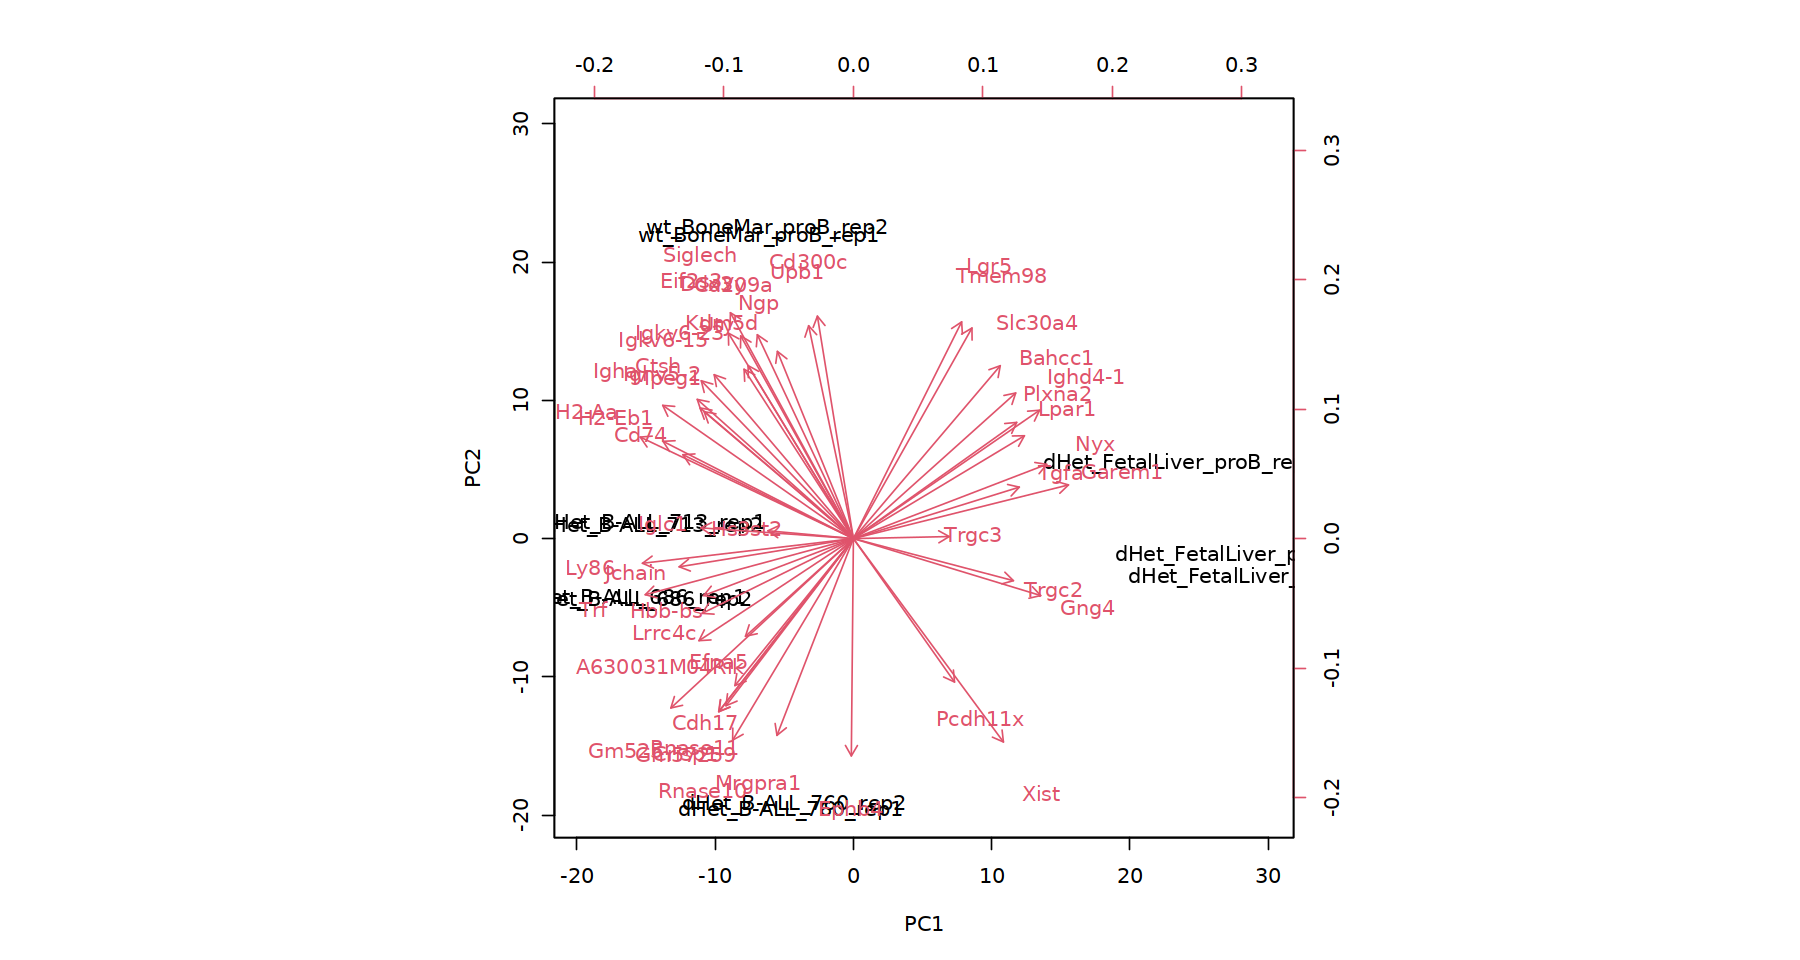

In [44]:
## Code cell 38 ##

biplot(PCAdata2,
       scale = 0)



Here, we can see that `Xist` points towards the bottom right, but its vector is longer towards the bottom than towards the right. Therefore, we can deduce that the variation of `Xist` expression in our dataset contributes more to the PC2 axis, that is to the difference of dHet cells (leukemic or not) compared to WT cells. 

---

### 2.3. PCA using FactoMineR package on the most variable genes
---



You can obtain more refined plots for PCA, scree plots, bi plots, correlation plots (and more) by using dedicated packages.    

One of the best and most popular is [FactoMineR](http://factominer.free.fr/index_fr.html), with its  companion package [factoextra](https://cran.r-project.org/web/packages/factoextra/index.html).    

You can find many tutorials, such as this one:    
http://www.sthda.com/english/wiki/wiki.php?id_contents=7851

Lets' have a look at a quick analysis with FactoMineR.

#### **2.3-a. Prepare input files for factominer**

- FactoMineR also needs the **variables *(i.e genes here)* in columns**. So again we have to start with the transposed version of the norm_counts, here with the top 50 variable genes. Let's put this transforsed dataframe in an object called `for_factominer`:

In [45]:
## Code cell 39 ##

for_factominer <- t(top50var [, 3:13])
str(for_factominer)
head(for_factominer)

 num [1:11, 1:50] 2.75 2.55 3.72 3.05 11.42 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:11] "dHet_B-ALL_686_rep1" "dHet_B-ALL_686_rep2" "dHet_B-ALL_713_rep1" "dHet_B-ALL_713_rep2" ...
  ..$ : chr [1:50] "Xist" "Uty" "Upb1" "Trgc3" ...


Xist      Uty       Upb1     Trgc3    Trgc2    Trf     
dHet_B-ALL_686_rep1  2.746673 10.771582 1.031205 1.464698 5.005345 14.73069
dHet_B-ALL_686_rep2  2.545051 10.080841 1.857411 1.647351 5.244513 14.58497
dHet_B-ALL_713_rep1  3.715644 10.574867 1.675849 7.281517 5.668985 10.45843
dHet_B-ALL_713_rep2  3.054969 10.067801 2.777745 7.128790 5.482718 10.39184
dHet_B-ALL_760_rep1 11.415092  3.090502 1.850854 1.641378 4.643928 14.61132
dHet_B-ALL_760_rep2 12.177744  3.303381 1.210811 1.662663 5.004666 14.30699
                    Tmem98   Tgfa     Slc30a4  Siglech  ... Efna5     Ddx3y    
dHet_B-ALL_686_rep1 2.902231 1.523685 4.384853 6.169718 ... 11.621924 11.972783
dHet_B-ALL_686_rep2 3.104425 1.705287 3.437919 5.846299 ... 11.457349 11.724160
dHet_B-ALL_713_rep1 9.351114 3.642599 4.914945 7.523350 ...  3.580569 11.745637
dHet_B-ALL_713_rep2 9.483373 2.087165 4.000648 7.653849 ...  3.524221 11.782772
dHet_B-ALL_760_rep1 3.097748 1.699343 3.283509 3.916801 ... 10.081548  3.521080
dHet_B-ALL_760_rep2 3.121560 1.720522 2.742862 3.524659 ...  9.746174  3.854028
                    Ctsh      Crisp1   Cdh17    Cd74     Cd300c    Cd209a  
dHet_B-ALL_686_rep1  8.820558 10.97353 14.07339 14.61456 1.4910604 3.232645
dHet_B-ALL_686_rep2  8.617554 10.88479 13.85948 14.56898 0.9805384 3.230504
dHet_B-ALL_713_rep1 11.066065 12.06047 15.40756 17.49267 1.0803741 7.903101
dHet_B-ALL_713_rep2 11.067955 12.12266 15.31890 17.43002 1.0423331 7.595531
dHet_B-ALL_760_rep1  6.172418 10.97048 12.34387 13.46964 0.9753613 2.055320
dHet_B-ALL_760_rep2  6.540871 11.02146 12.31372 13.31192 0.9937968 3.495257
                    Bahcc1   A630031M04Rik
dHet_B-ALL_686_rep1 3.047445 10.287479    
dHet_B-ALL_686_rep2 2.322300 10.201891    
dHet_B-ALL_713_rep1 2.442805 10.853948    
dHet_B-ALL_713_rep2 2.396635 10.614312    
dHet_B-ALL_760_rep1 2.316108  6.962324    
dHet_B-ALL_760_rep2 3.147213  6.922737

- We can add **qualitative variables** as additional columns. Here we add the columns of the `samples` dataframe after checking the samples are in the same order.

In [46]:
## Code cell 40 ##

row.names(for_factominer) == samples$SampleName
for_factominer <- data.frame(for_factominer, samples)
str(for_factominer)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

'data.frame':	11 obs. of  60 variables:
 $ Xist               : num  2.75 2.55 3.72 3.05 11.42 ...
 $ Uty                : num  10.77 10.08 10.57 10.07 3.09 ...
 $ Upb1               : num  1.03 1.86 1.68 2.78 1.85 ...
 $ Trgc3              : num  1.46 1.65 7.28 7.13 1.64 ...
 $ Trgc2              : num  5.01 5.24 5.67 5.48 4.64 ...
 $ Trf                : num  14.7 14.6 10.5 10.4 14.6 ...
 $ Tmem98             : num  2.9 3.1 9.35 9.48 3.1 ...
 $ Tgfa               : num  1.52 1.71 3.64 2.09 1.7 ...
 $ Slc30a4            : num  4.38 3.44 4.91 4 3.28 ...
 $ Siglech            : num  6.17 5.85 7.52 7.65 3.92 ...
 $ Rnase11            : num  8.96 8.85 10.66 10.64 9.81 ...
 $ Rnase10            : num  10.68 10.54 9.76 9.78 12.9 ...
 $ Plxna2             : num  3.78 3.43 3.58 3.52 2.35 ...
 $ Pcdh11x            : num  3.82 3.74 11.84 11.96 13.22 ...
 $ Nyx                : num  1.72 1.9 2.02 1.98 1.9 ...
 $ Ngp                : num  9.49 9.63 5.07 5.26 4.14 ...
 $ Mrgpra1            : num  

Our dataframe has now 60 columns: 50 with the norm counts data for the top 50 most variable genes, followed by 10 columns with sample metadata.

We may create new qualitative columns :
    
    - mouse ID (using abritrary increment values from 1 to 5 for the proB mice
    - B type: B-ALL versus proB

In [47]:
## Code cell 41 ##

for_factominer$mouseID <- c(rep("686", 2), rep("713", 2), rep("760", 2), 1:5)
for_factominer$B_type <- c(rep("B-ALL", 6), rep("proB", 5))

Unfortunatley, the sex was not provided as a metadata by the authors. We will use the level of expression of `Xist` as a surrogate to look at the sex.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.545   2.841   3.716   6.450  11.796  12.951 


female   male 
     4      7 

Xist      sex   
dHet_B-ALL_686_rep1        2.746673 male  
dHet_B-ALL_686_rep2        2.545051 male  
dHet_B-ALL_713_rep1        3.715644 male  
dHet_B-ALL_713_rep2        3.054969 male  
dHet_B-ALL_760_rep1       11.415092 female
dHet_B-ALL_760_rep2       12.177744 female
dHet_FetalLiver_proB_rep1 12.569900 female
dHet_FetalLiver_proB_rep2  2.733470 male  
dHet_FetalLiver_proB_rep3 12.950594 female
wt_BoneMar_proB_rep1       4.103681 male  
wt_BoneMar_proB_rep2       2.935180 male

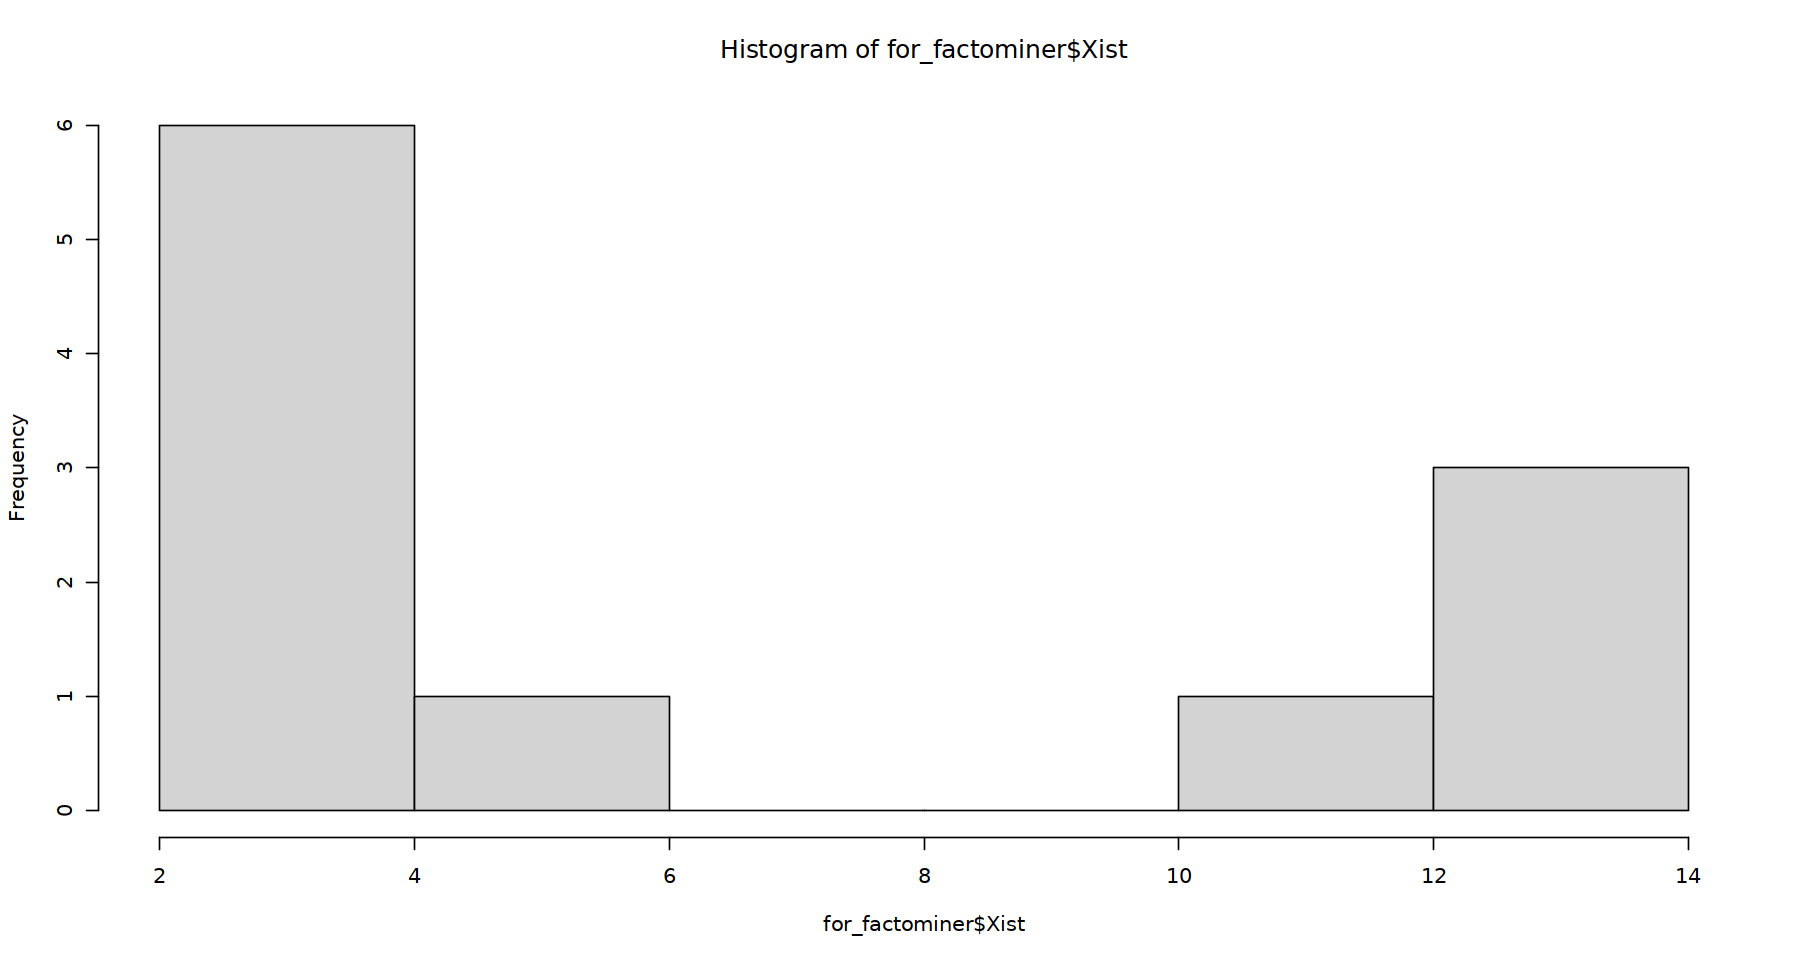

In [48]:
## Code cell 42 ##

summary(for_factominer$Xist)
hist(for_factominer$Xist)
for_factominer$sex <- ifelse(for_factominer$Xist < 6, "male", "female")
table(for_factominer$sex)
for_factominer[, c("Xist", "sex")]

- add **quantitative variables** as additional columns

Should you have some quantitative variables, include them as additional columns. Here, as we have no quantitative data in the metadata, let's choose arbitrary one. We will take the level of expression of the first and second differentially expressed genes, "Sos1" and "Gm2629" that are not among the top 50 variable genes, as seen above.

In [49]:
## Code cell 43 ##

for_factominer$Sos1 <- unlist(subset(norm_counts, gene_name == "Sos1")[,3:13])
for_factominer$Gm2629 <- unlist(subset(norm_counts, gene_name == "Gm2629")[,3:13])
head(for_factominer)
str(for_factominer)

Xist      Uty       Upb1     Trgc3    Trgc2    Trf     
dHet_B-ALL_686_rep1  2.746673 10.771582 1.031205 1.464698 5.005345 14.73069
dHet_B-ALL_686_rep2  2.545051 10.080841 1.857411 1.647351 5.244513 14.58497
dHet_B-ALL_713_rep1  3.715644 10.574867 1.675849 7.281517 5.668985 10.45843
dHet_B-ALL_713_rep2  3.054969 10.067801 2.777745 7.128790 5.482718 10.39184
dHet_B-ALL_760_rep1 11.415092  3.090502 1.850854 1.641378 4.643928 14.61132
dHet_B-ALL_760_rep2 12.177744  3.303381 1.210811 1.662663 5.004666 14.30699
                    Tmem98   Tgfa     Slc30a4  Siglech  ... Sample.Name
dHet_B-ALL_686_rep1 2.902231 1.523685 4.384853 6.169718 ... GSM4805160 
dHet_B-ALL_686_rep2 3.104425 1.705287 3.437919 5.846299 ... GSM4805161 
dHet_B-ALL_713_rep1 9.351114 3.642599 4.914945 7.523350 ... GSM4805162 
dHet_B-ALL_713_rep2 9.483373 2.087165 4.000648 7.653849 ... GSM4805163 
dHet_B-ALL_760_rep1 3.097748 1.699343 3.283509 3.916801 ... GSM4805164 
dHet_B-ALL_760_rep2 3.121560 1.720522 2.742862 3.524659 ... GSM4805165 
                    source_name                                                                         
dHet_B-ALL_686_rep1 Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate1
dHet_B-ALL_686_rep2 Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate2
dHet_B-ALL_713_rep1 Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate1
dHet_B-ALL_713_rep2 Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate2
dHet_B-ALL_760_rep1 Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\\,Replicate1
dHet_B-ALL_760_rep2 Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\\,Replicate2
                    SRA.Study Strain   Tissue                     mouseID
dHet_B-ALL_686_rep1 SRP285633 C57BL/6J Ebf1+/- Pax5+/- lymph node 686    
dHet_B-ALL_686_rep2 SRP285633 C57BL/6J Ebf1+/- Pax5+/- lymph node 686    
dHet_B-ALL_713_rep1 SRP285633 C57BL/6J Ebf1+/- Pax5+/- lymph node 713    
dHet_B-ALL_713_rep2 SRP285633 C57BL/6J Ebf1+/- Pax5+/- lymph node 713    
dHet_B-ALL_760_rep1 SRP285633 C57BL/6J Ebf1+/- Pax5+/- lymph node 760    
dHet_B-ALL_760_rep2 SRP285633 C57BL/6J Ebf1+/- Pax5+/- lymph node 760    
                    B_type sex    Sos1     Gm2629  
dHet_B-ALL_686_rep1 B-ALL  male   14.06867 11.76586
dHet_B-ALL_686_rep2 B-ALL  male   13.74346 11.68668
dHet_B-ALL_713_rep1 B-ALL  male   14.35053 12.26564
dHet_B-ALL_713_rep2 B-ALL  male   14.18419 12.29360
dHet_B-ALL_760_rep1 B-ALL  female 13.98768 12.07318
dHet_B-ALL_760_rep2 B-ALL  female 13.82228 12.37285

'data.frame':	11 obs. of  65 variables:
 $ Xist               : num  2.75 2.55 3.72 3.05 11.42 ...
 $ Uty                : num  10.77 10.08 10.57 10.07 3.09 ...
 $ Upb1               : num  1.03 1.86 1.68 2.78 1.85 ...
 $ Trgc3              : num  1.46 1.65 7.28 7.13 1.64 ...
 $ Trgc2              : num  5.01 5.24 5.67 5.48 4.64 ...
 $ Trf                : num  14.7 14.6 10.5 10.4 14.6 ...
 $ Tmem98             : num  2.9 3.1 9.35 9.48 3.1 ...
 $ Tgfa               : num  1.52 1.71 3.64 2.09 1.7 ...
 $ Slc30a4            : num  4.38 3.44 4.91 4 3.28 ...
 $ Siglech            : num  6.17 5.85 7.52 7.65 3.92 ...
 $ Rnase11            : num  8.96 8.85 10.66 10.64 9.81 ...
 $ Rnase10            : num  10.68 10.54 9.76 9.78 12.9 ...
 $ Plxna2             : num  3.78 3.43 3.58 3.52 2.35 ...
 $ Pcdh11x            : num  3.82 3.74 11.84 11.96 13.22 ...
 $ Nyx                : num  1.72 1.9 2.02 1.98 1.9 ...
 $ Ngp                : num  9.49 9.63 5.07 5.26 4.14 ...
 $ Mrgpra1            : num  

#### **2.3-b. Run PCA and store results**

The `PCA()` function of FactoMineR creates an object of type `list` including all PCA results.

In [50]:
## Code cell 44 ##

# Use PCA() of FactoMineR
#?PCA
PCAres <- FactoMineR::PCA(for_factominer,
                          quali.sup = 51:(ncol(for_factominer)-2), # specify the index of the qulatitative colums
                          quanti.sup = (ncol(for_factominer)-1):ncol(for_factominer),
                                                                graph = FALSE)
#str(PCAres) # longue structure!
print(class(PCAres))
names(PCAres)

[1] "PCA"  "list"


[1] "eig"        "var"        "ind"        "svd"        "quanti.sup"
[6] "quali.sup"  "call"

#### **2.3-c. Visual analysis of the first two eigen vectors**


The first two axes explain most of the interia of the scatter plot. Let's visualize the graph by plotting each mouse along these two axes.

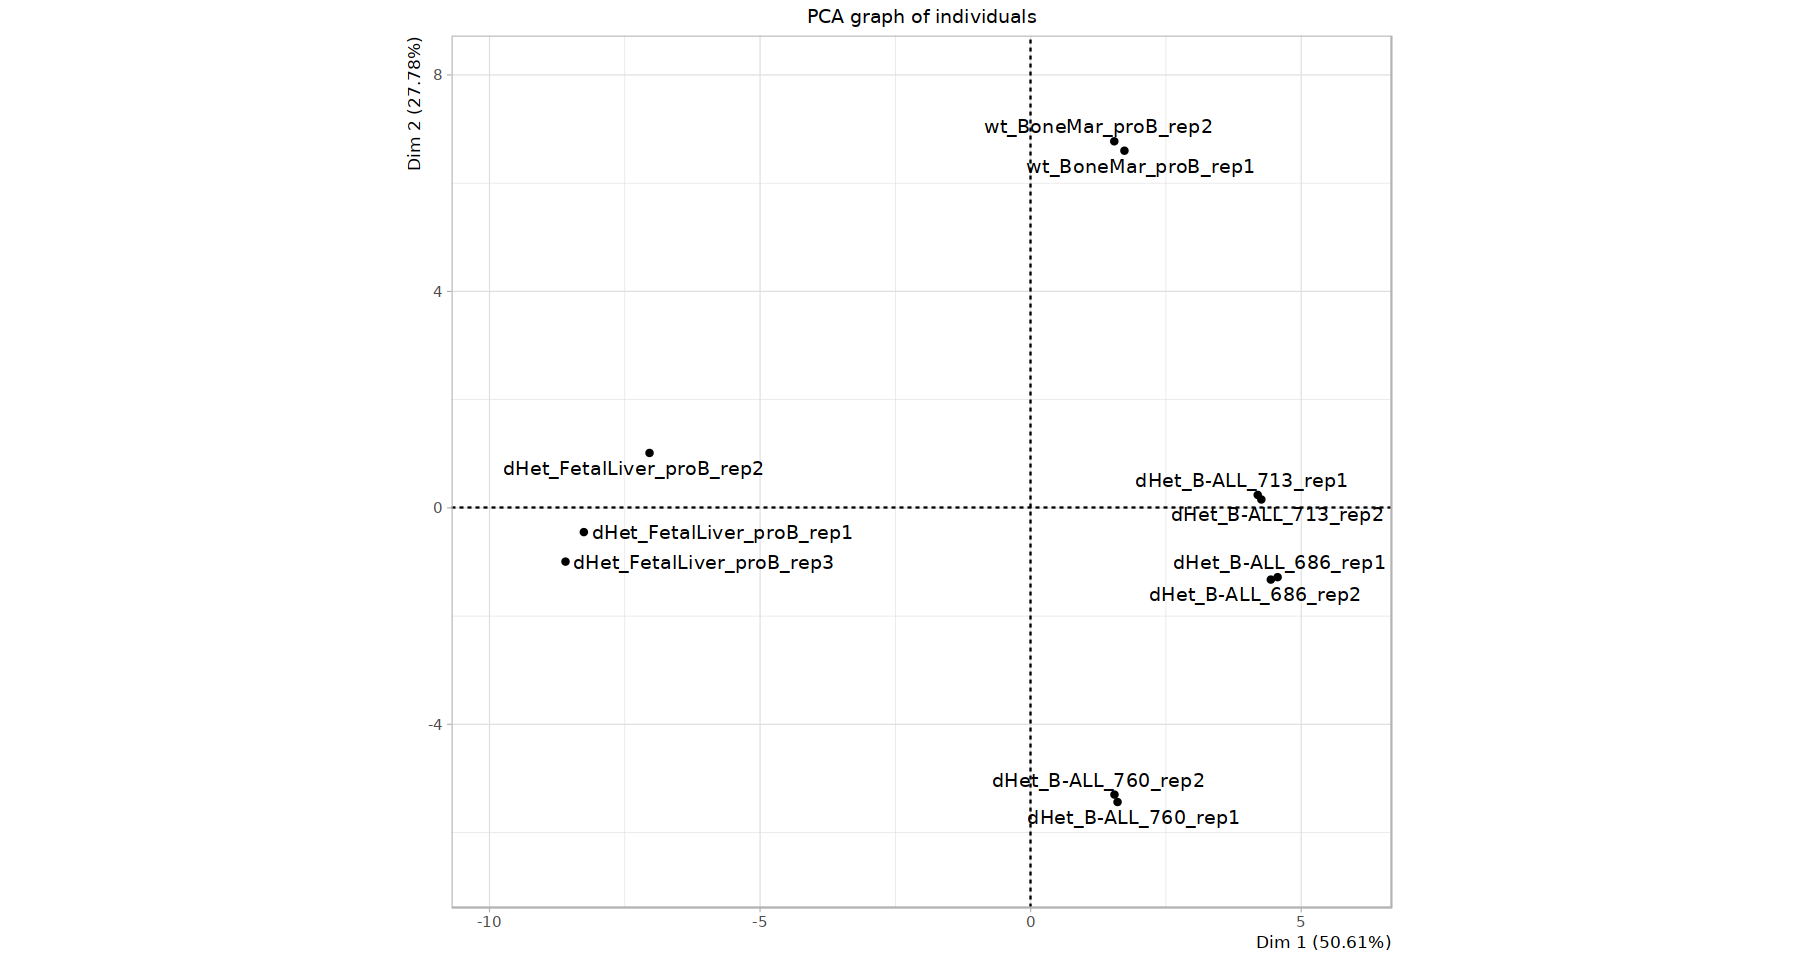

In [51]:
## Code cell 45 ##

# Creates graphs with the samples (called "individuals in factominer) according to each axsis :

FactoMineR::plot.PCA(PCAres, choix = "ind", autoLab = "yes", invisible = "quali", cex = 1)

Note that the contribution of each axis to the inertia is displayed in %.

Let's label the dots using some qualitative metadata:

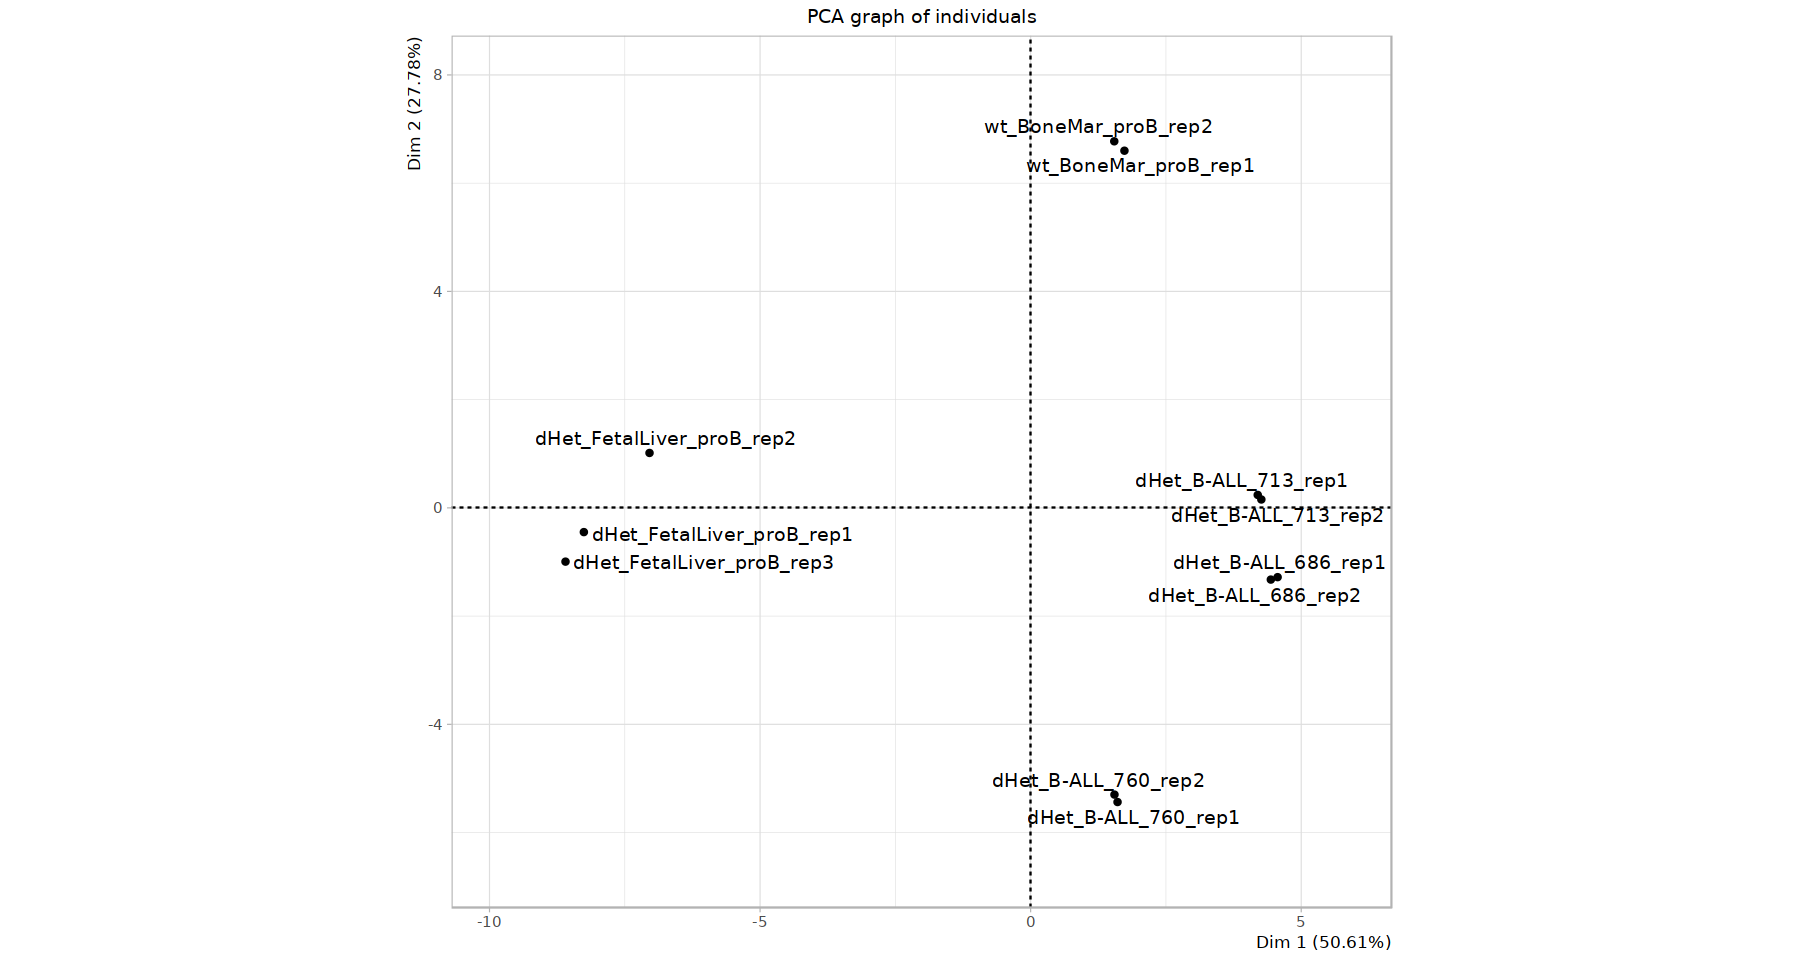

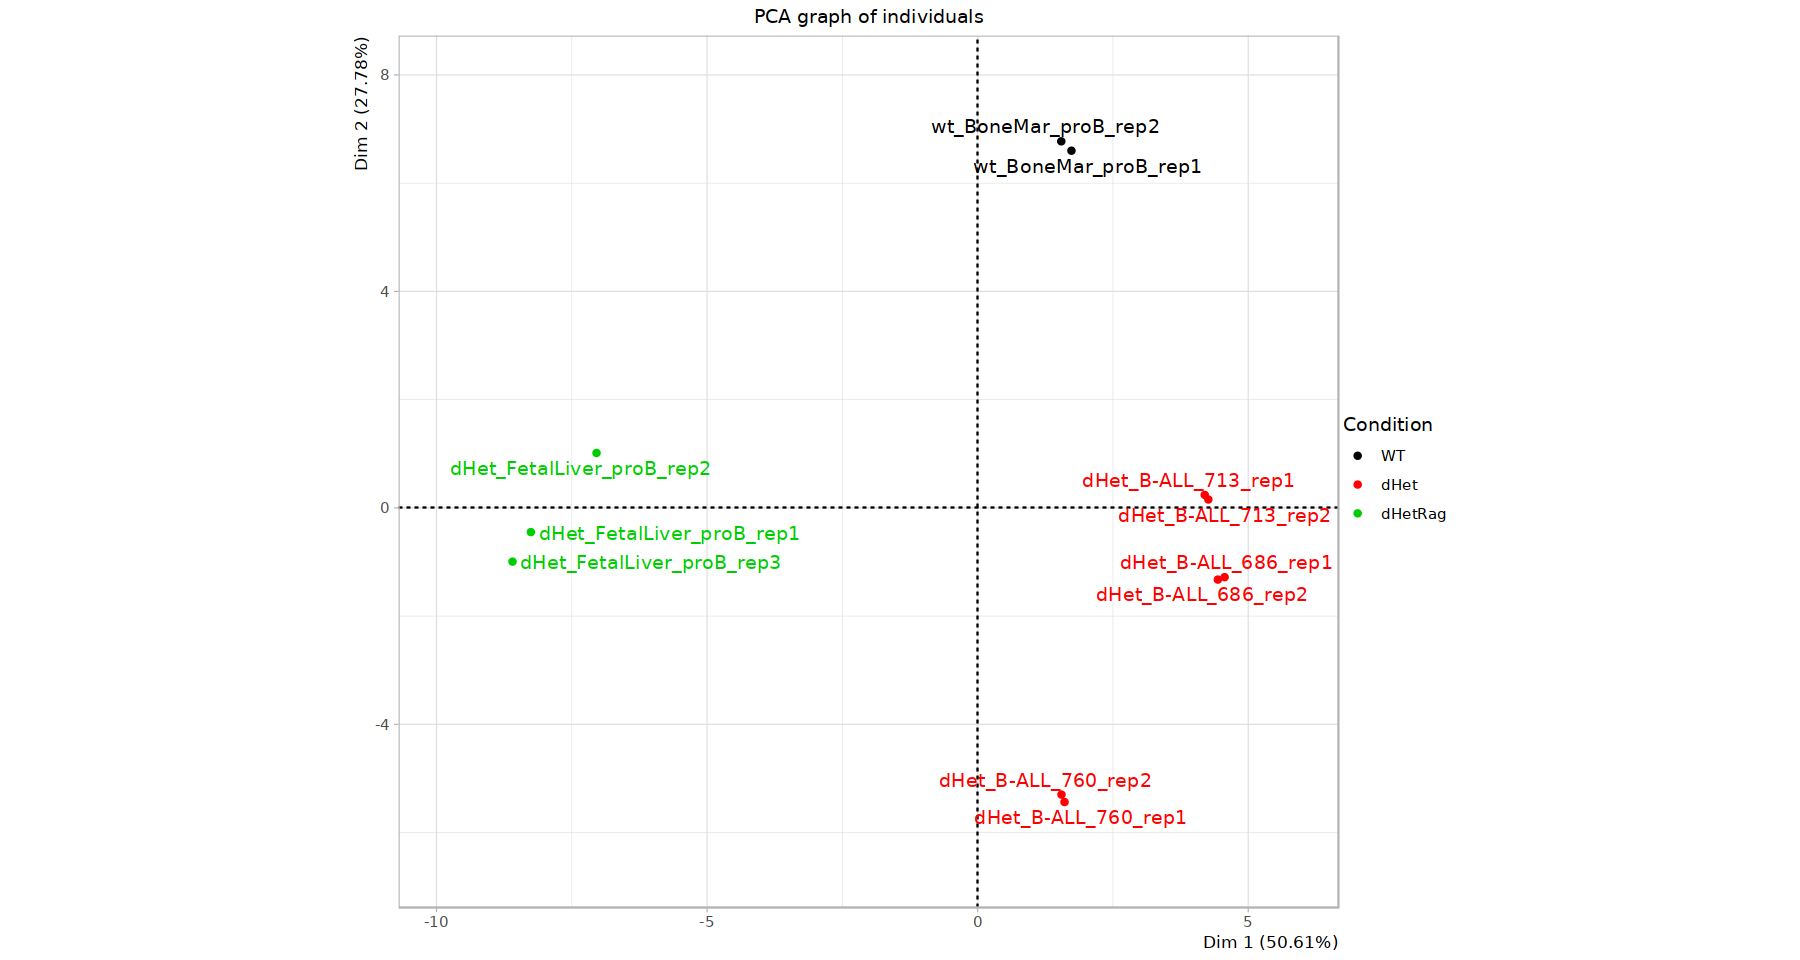

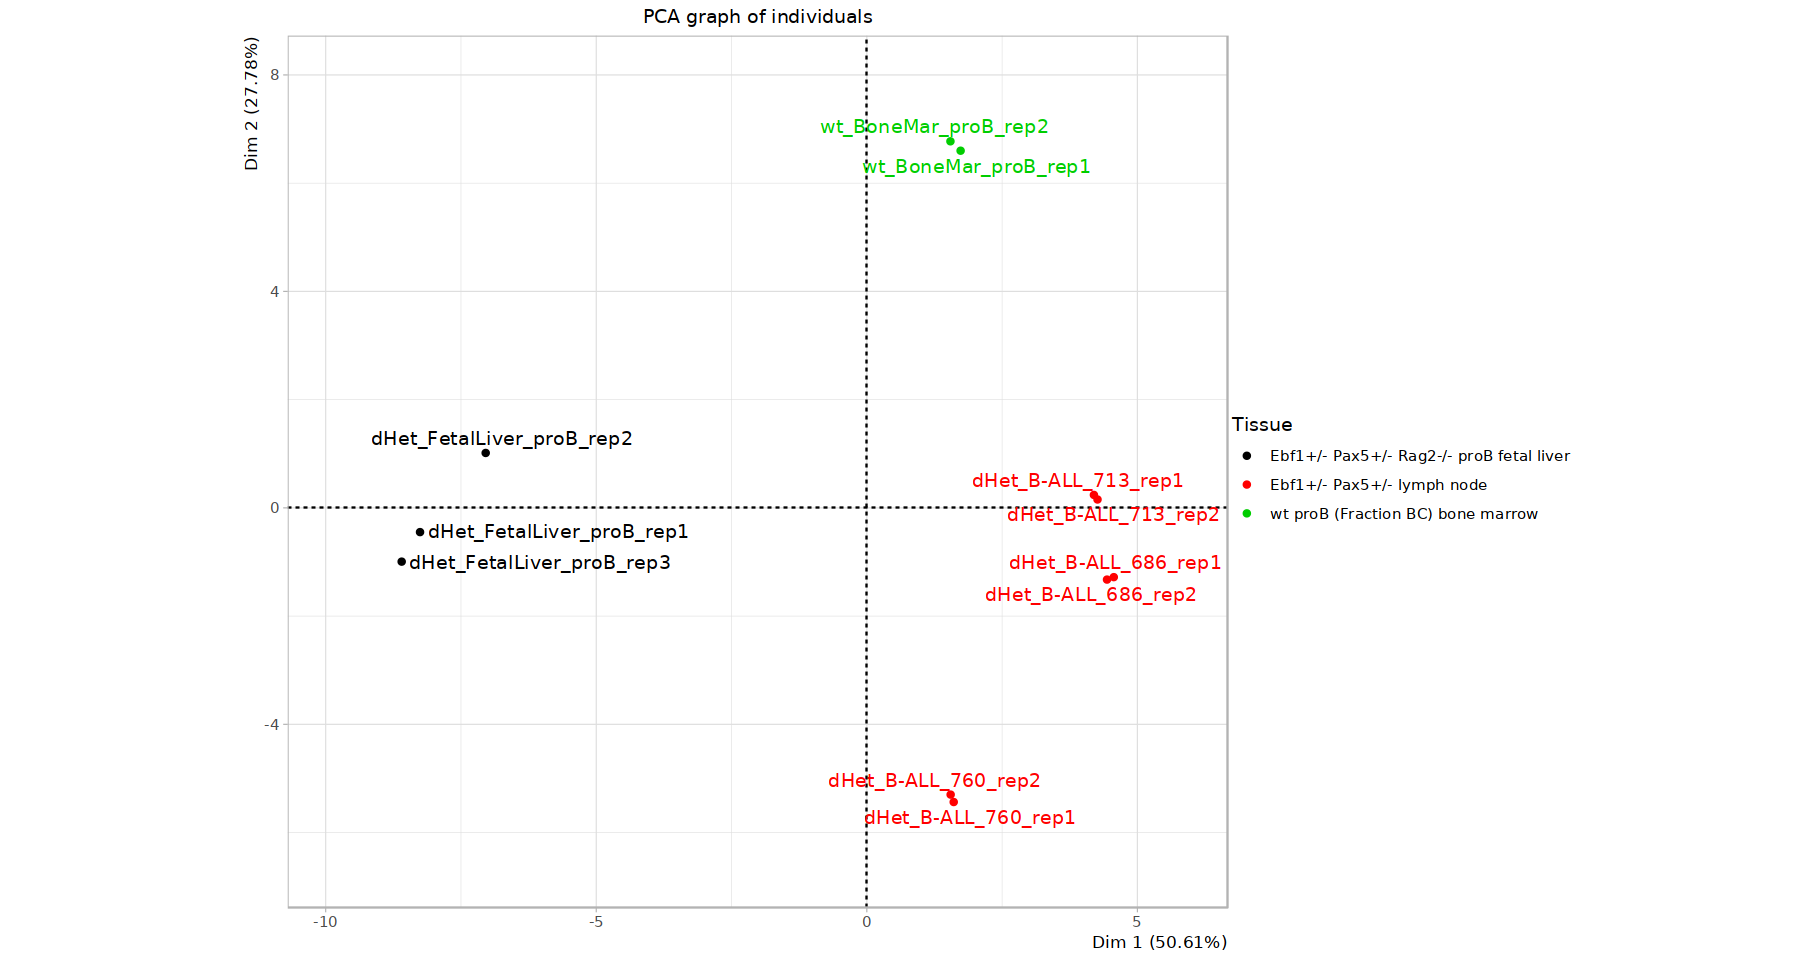

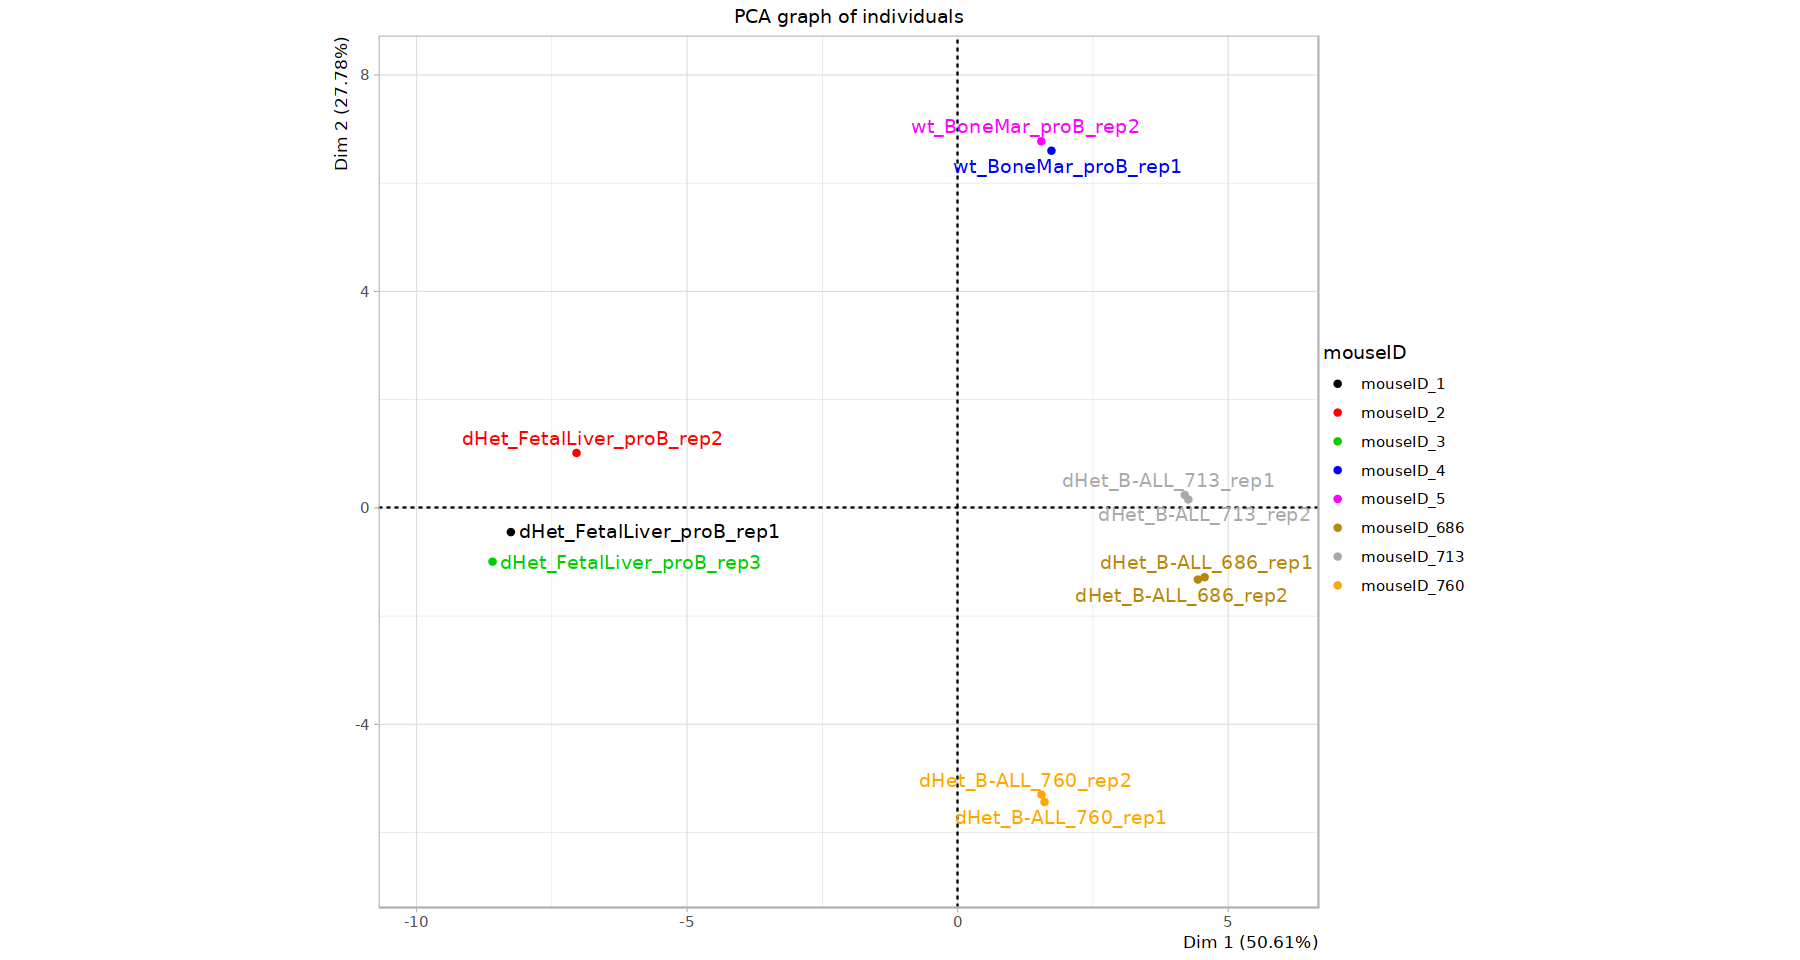

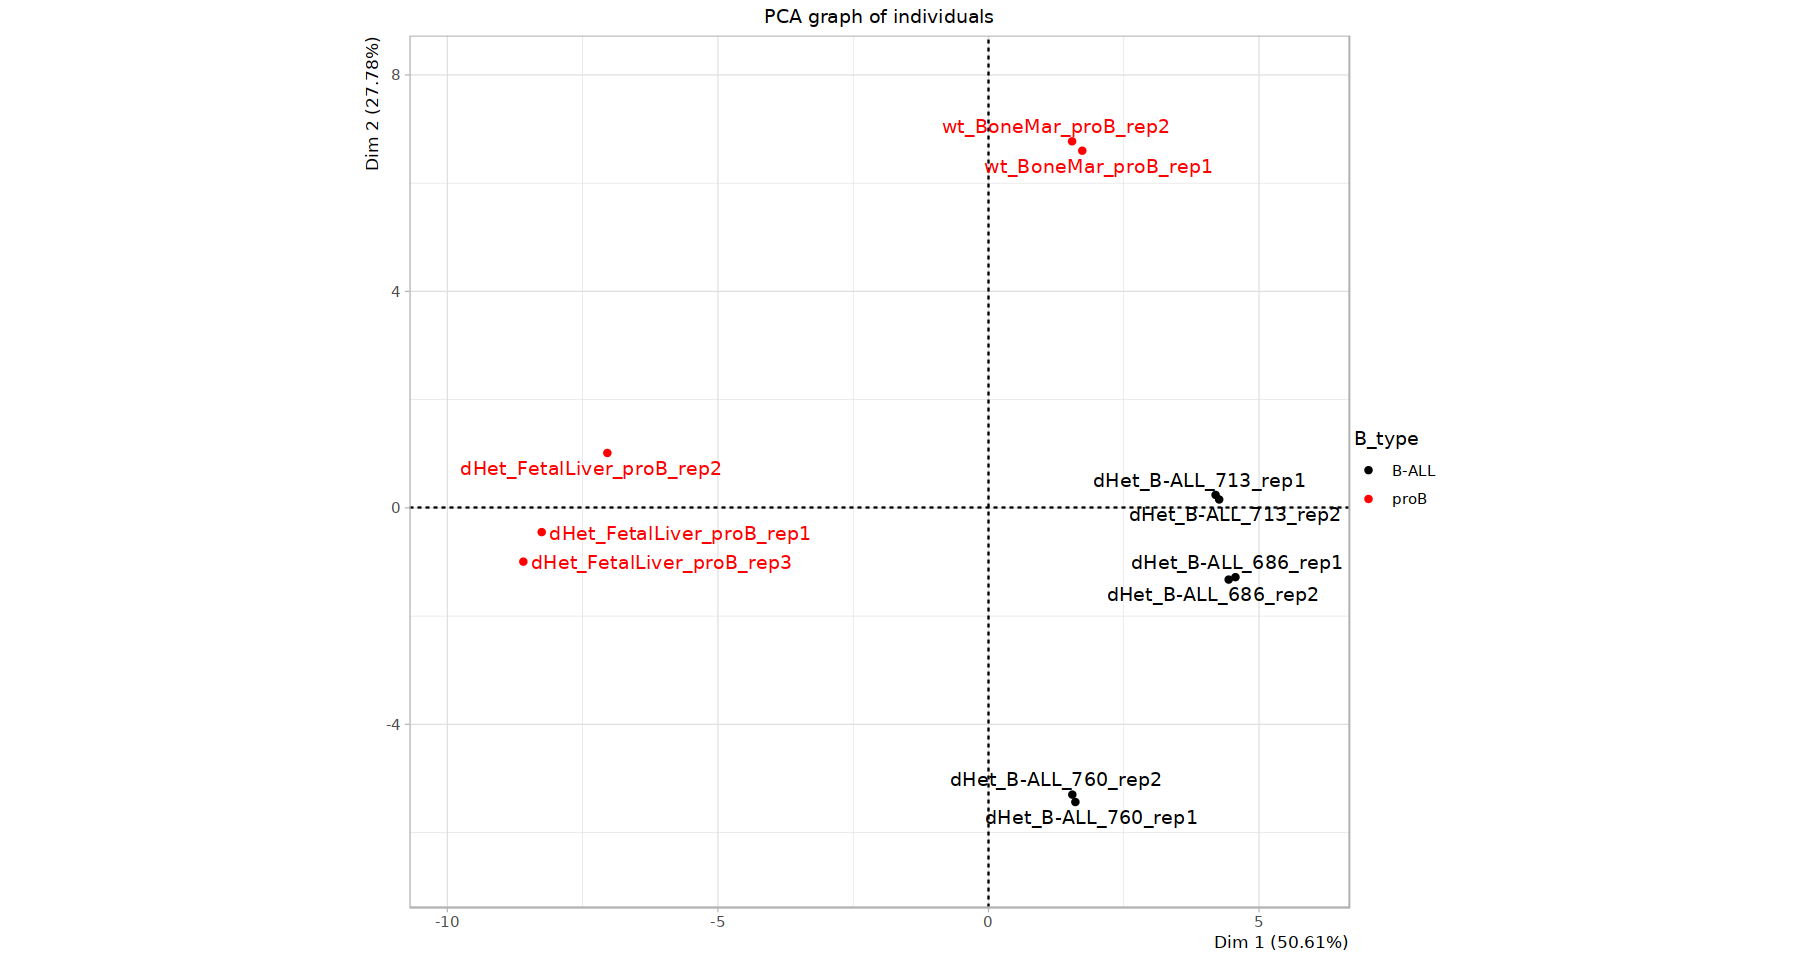

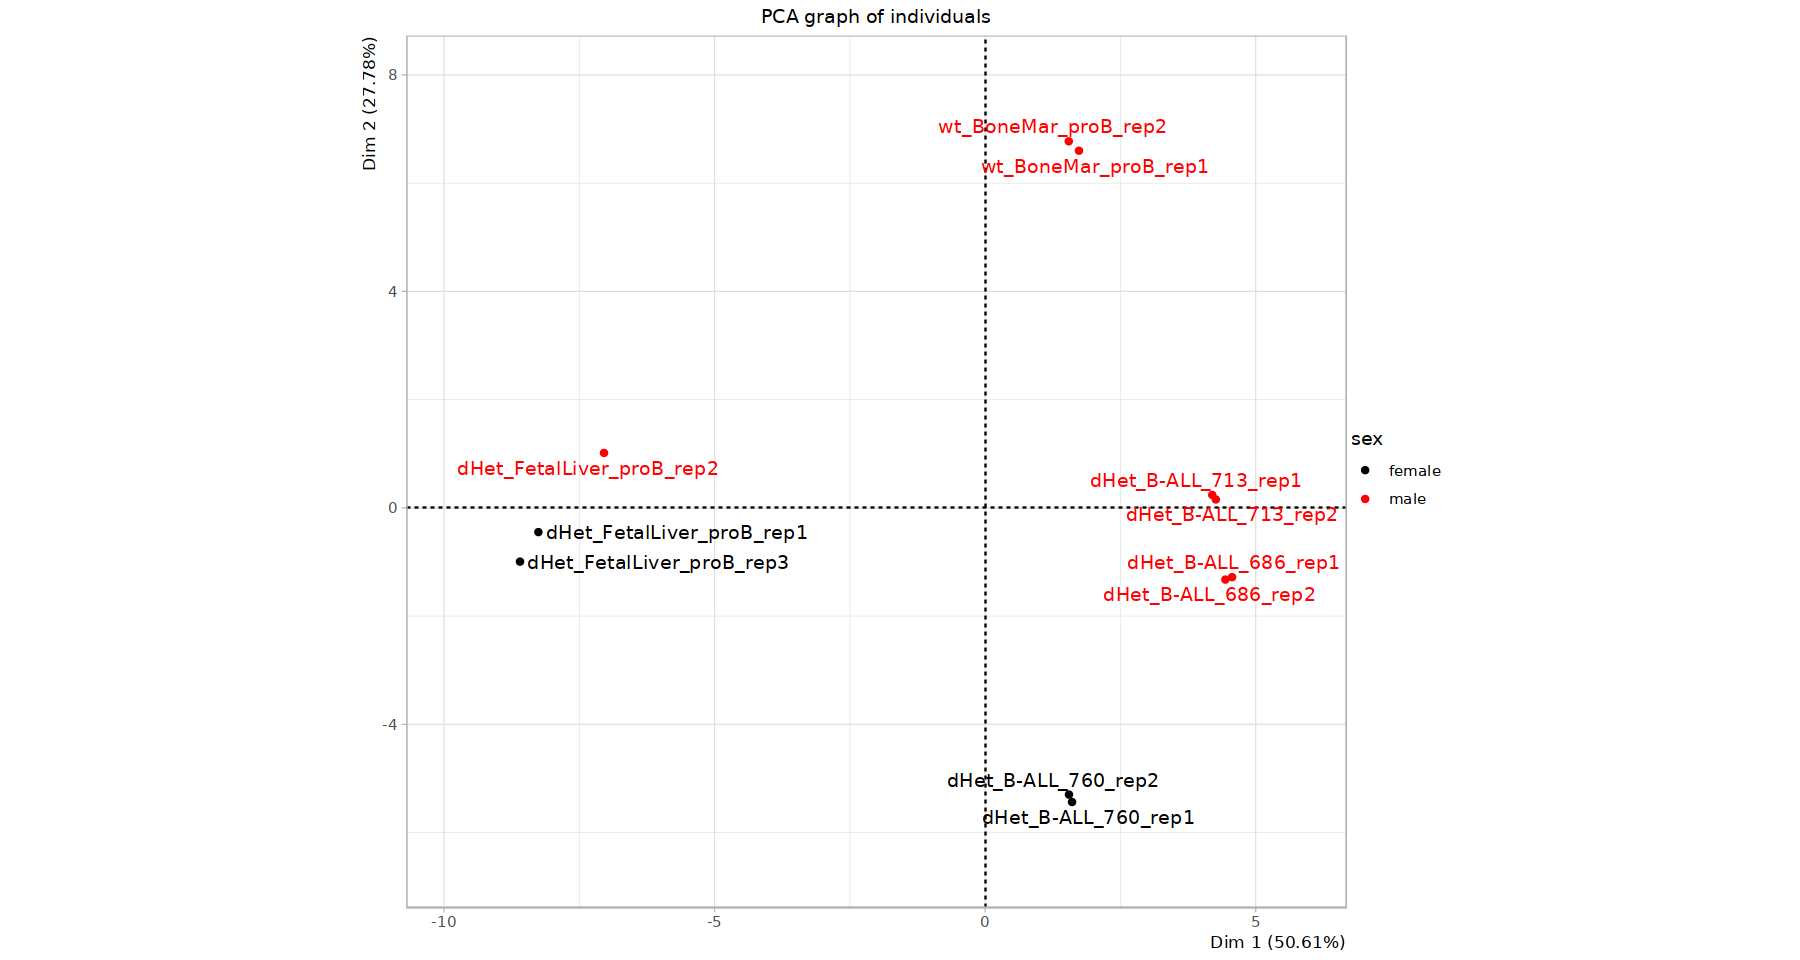

In [52]:
## Code cell 46 ##

# Same graph adding colors for qualitative variables
# save in pdf if wanted

#pdf("PCA_individus.pdf")

FactoMineR::plot.PCA(PCAres, choix = "ind", autoLab = "yes", invisible = "quali", cex = 1)
FactoMineR::plot.PCA(PCAres, choix = "ind", autoLab = "yes", invisible = "quali", habillage = "Condition", cex = 1)
FactoMineR::plot.PCA(PCAres, choix = "ind", autoLab = "yes", invisible = "quali", habillage = "Tissue", cex = 1)
FactoMineR::plot.PCA(PCAres, choix = "ind", autoLab = "yes", invisible = "quali", habillage = "mouseID" , cex = 1)
FactoMineR::plot.PCA(PCAres, choix = "ind", autoLab = "yes", invisible = "quali", habillage = "B_type" , cex = 1)
FactoMineR::plot.PCA(PCAres, choix = "ind", autoLab = "yes", invisible = "quali", habillage = "sex", cex = 1)
#dev.off()

To look at other axes:

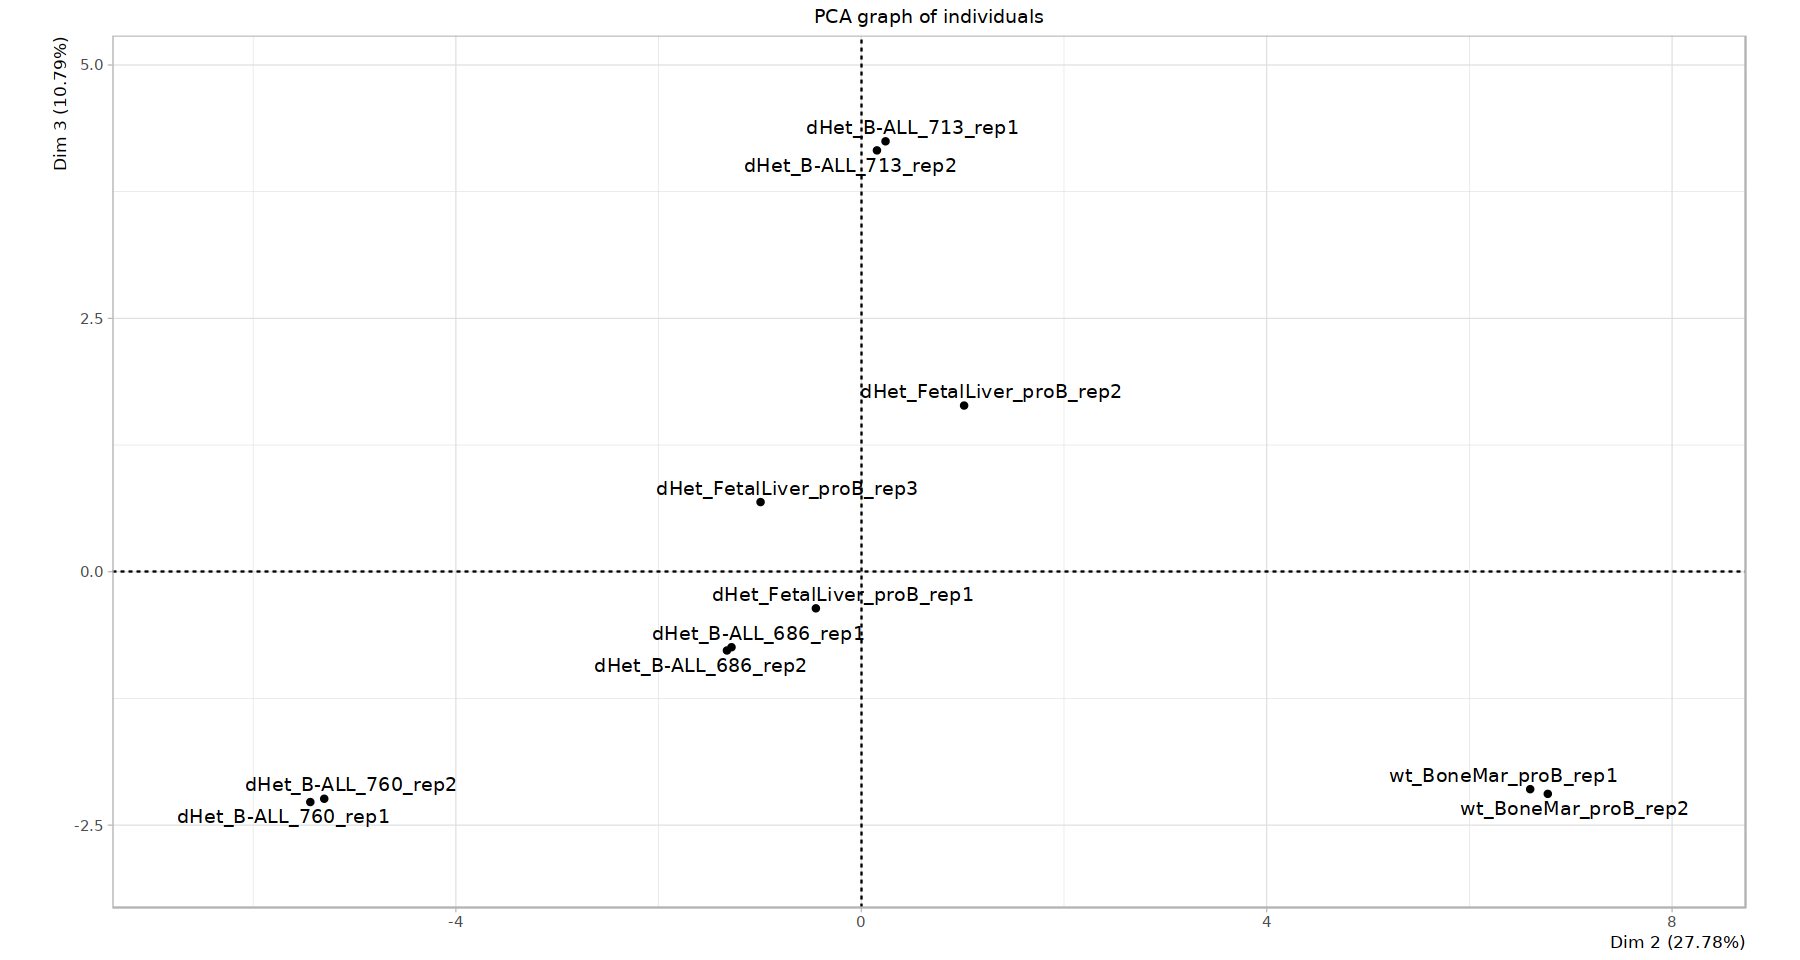

In [53]:
## Code cell 47 ##

FactoMineR::plot.PCA(PCAres, axes = c(2,3), choix = "ind", autoLab = "yes", invisible = "quali", cex = 1)

#### **2.3-d. PCA quality**

- The **inertia explained by each component** is stored in `PCAres$eig`.

In [54]:
## Code cell 48 ##

PCAres$eig

# only for first five:
PCAres$eig[1:5]

eigenvalue  percentage of variance cumulative percentage of variance
comp 1  25.30339926 50.60679852             50.60680                        
comp 2  13.88775801 27.77551602             78.38231                        
comp 3   5.39589602 10.79179205             89.17411                        
comp 4   3.53878834  7.07757668             96.25168                        
comp 5   1.18805121  2.37610242             98.62779                        
comp 6   0.51815281  1.03630563             99.66409                        
comp 7   0.09548910  0.19097820             99.85507                        
comp 8   0.03590327  0.07180653             99.92688                        
comp 9   0.02273870  0.04547740             99.97235                        
comp 10  0.01382327  0.02764654            100.00000

[1] 25.303399 13.887758  5.395896  3.538788  1.188051

- **scree plots**: We draw the standard scree plot and a cumulative one with r base commands:

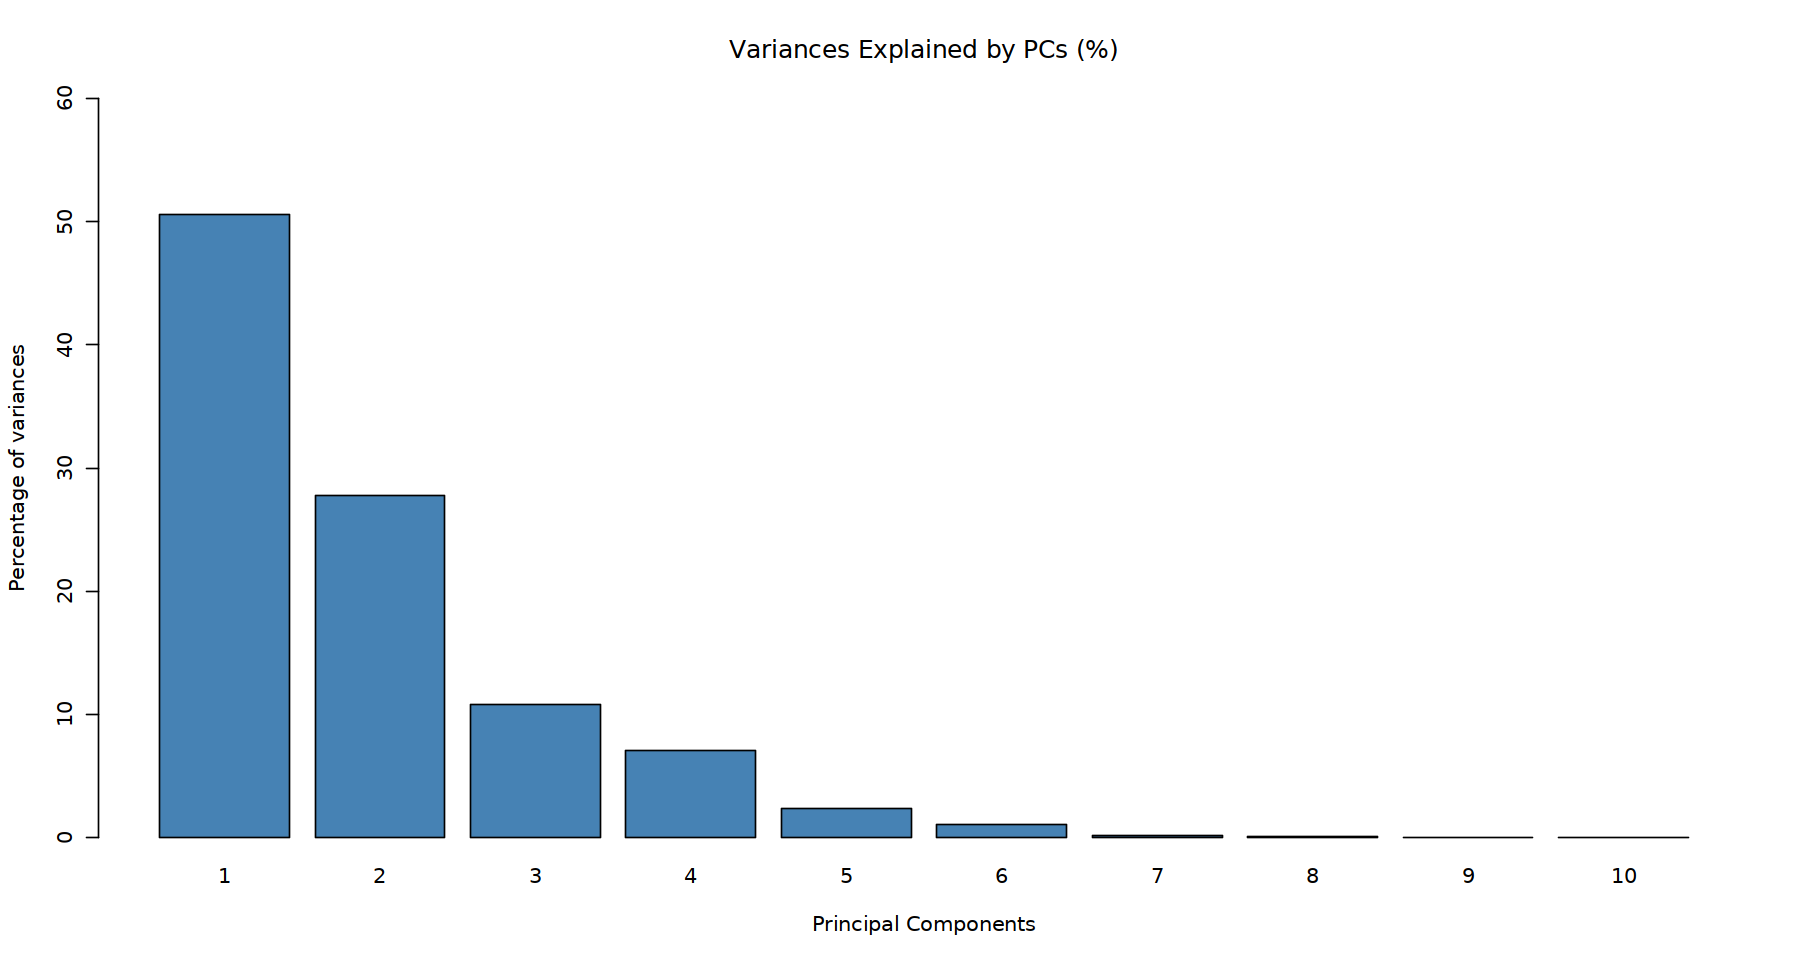

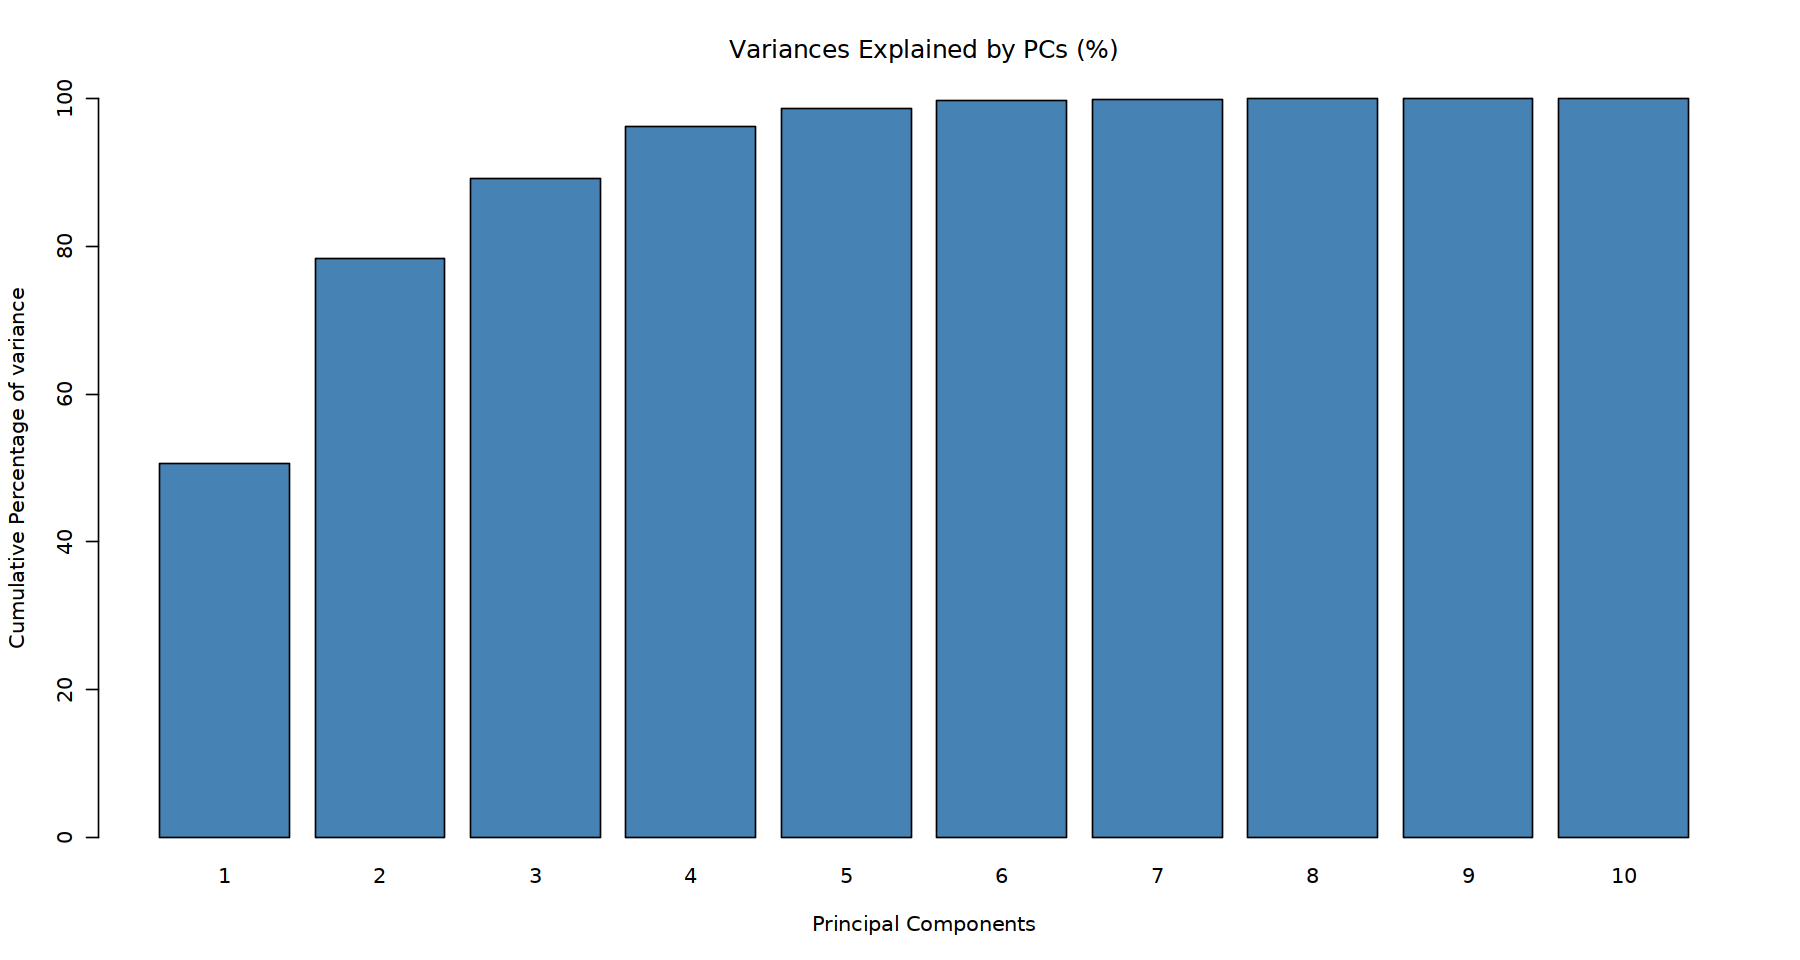

In [58]:
## Code cell 49 ##

# Graphic Inertia and dimensions

#pdf("PCA_inertia.pdf")
eig.val <- PCAres$eig
barplot(eig.val[, 2], 
        names.arg = 1:nrow(eig.val), 
        main = "Variances Explained by PCs (%)",
        xlab = "Principal Components",
        ylab = "Percentage of variances",
        ylim = c(0,60),
        col ="steelblue")

barplot(eig.val[, 3], 
        names.arg = 1:nrow(eig.val), 
        main = "Variances Explained by PCs (%)",
        xlab = "Principal Components",
        ylab = "Cumulative Percentage of variance",
        ylim = c(0,100),
        col ="steelblue")

#dev.off()

Using the `factoextra` package on factominer results allows to draw a nicer scree plots: 

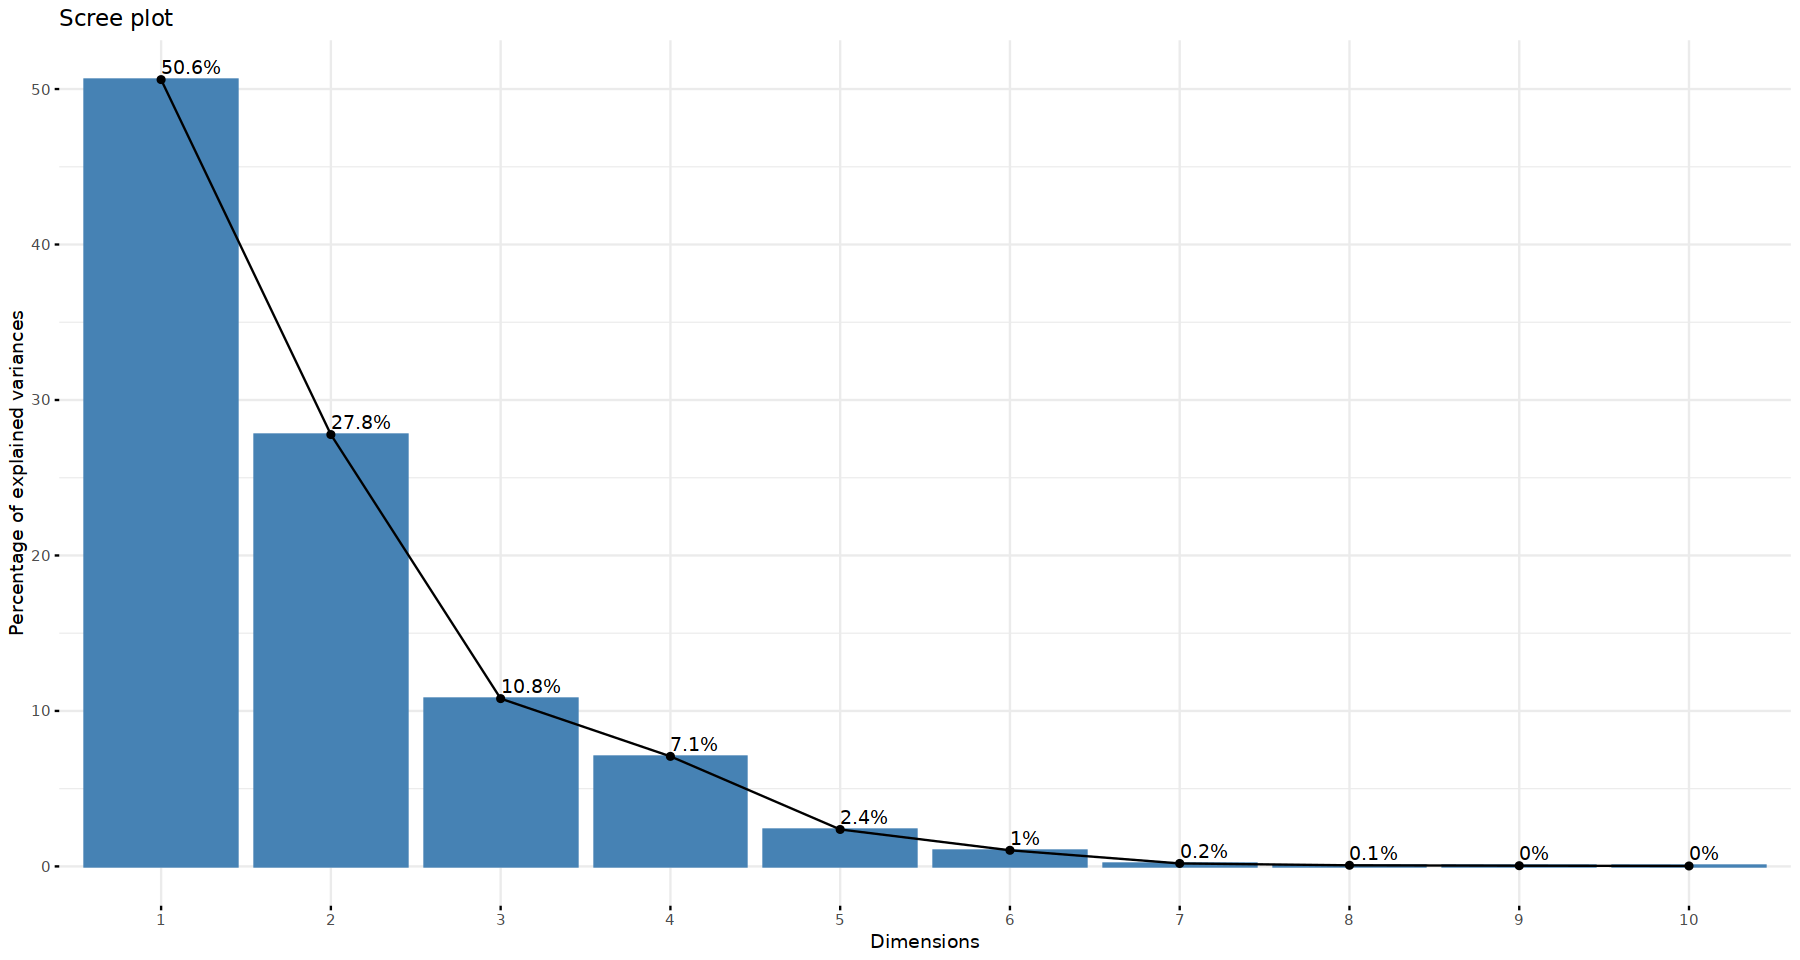

In [56]:
## Code cell 50 ##

# diagramme des éboulis avec 10 composantes par défaut
factoextra::fviz_eig(PCAres, addlabels = TRUE)

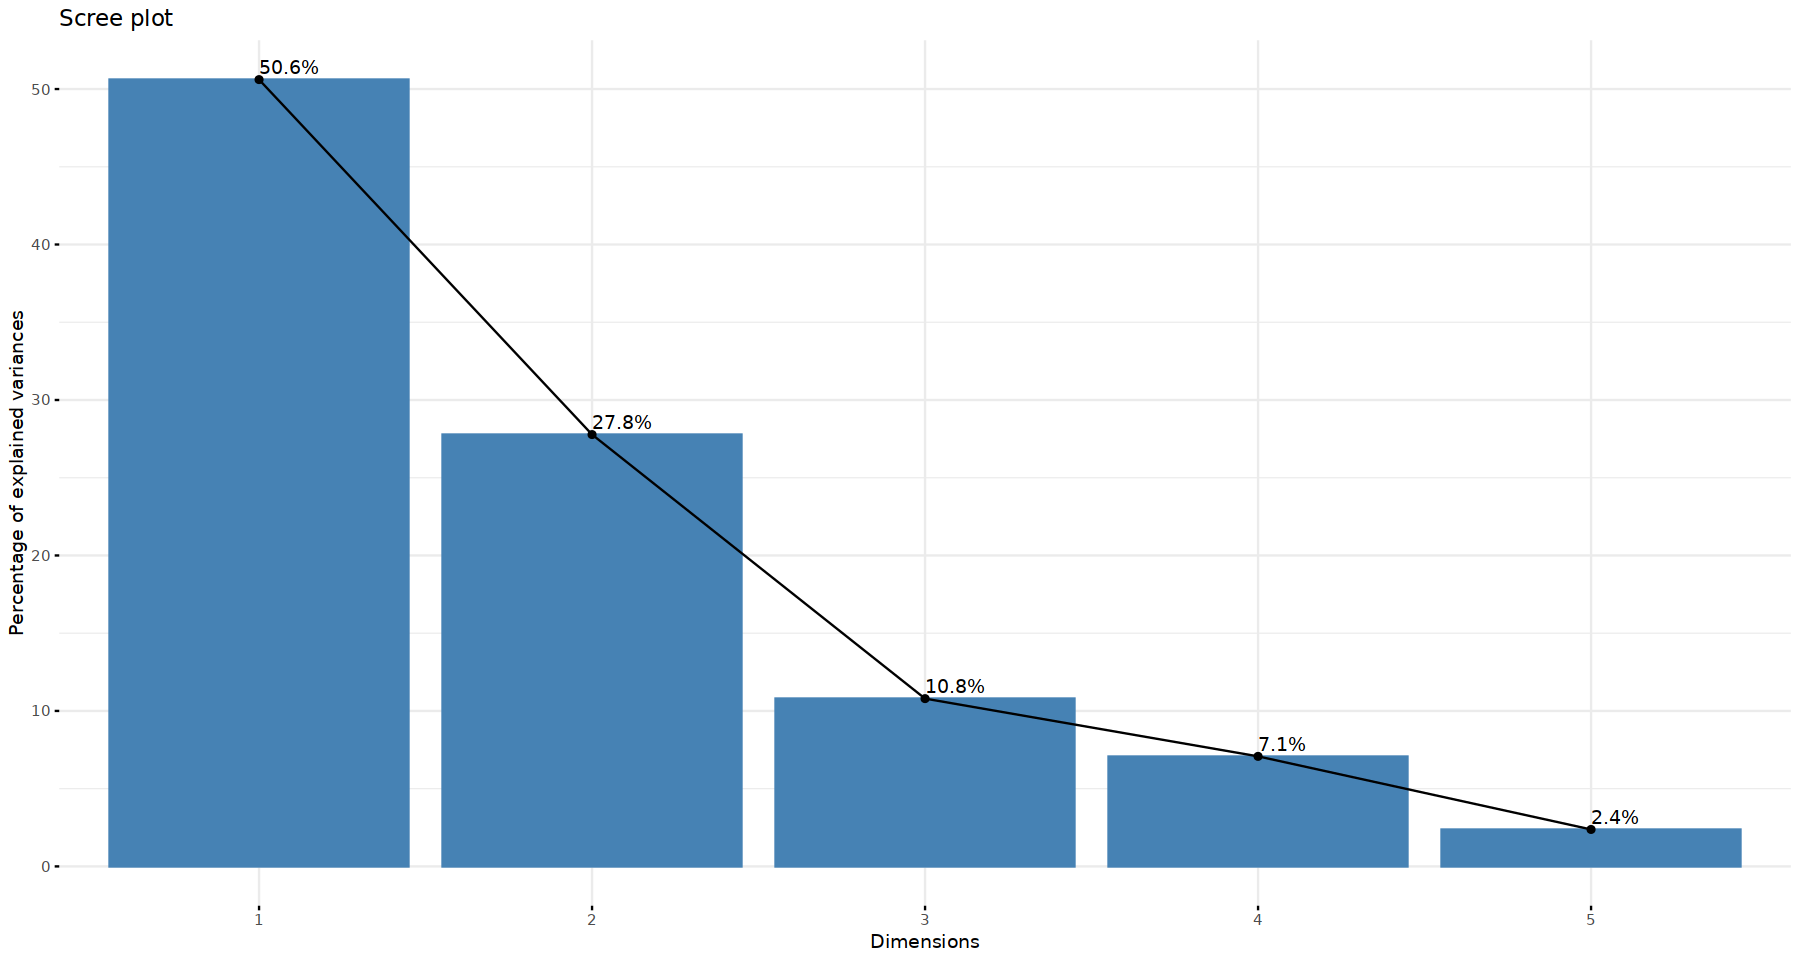

In [57]:
## Code cell 51 ##

# idem same with only 5 components:
factoextra::fviz_eig(PCAres, addlabels = TRUE, ncp = 5)

#### **2.3-e. Analysis of correlations between PCA variables and metadata**




In addition to visually look at each component, it is possible to test the correlation between each component and the metadata.

- Correlation between each component and **qualitative metadata:**

In [59]:
## Code cell 52 ##

round(PCAres$quali.sup$eta2, 2)

Dim.1 Dim.2 Dim.3 Dim.4 Dim.5
SampleID            1.00  1.00  1.00  1.00  1.00 
SampleName          1.00  1.00  1.00  1.00  1.00 
Condition           0.96  0.77  0.20  0.07  0.00 
Genotype            0.96  0.77  0.20  0.07  0.00 
GEO_Accession..exp. 1.00  1.00  1.00  1.00  1.00 
Sample.Name         1.00  1.00  1.00  1.00  1.00 
source_name         1.00  1.00  1.00  1.00  1.00 
SRA.Study           0.00  0.00  0.00  0.00  0.00 
Strain              0.00  0.00  0.00  0.00  0.00 
Tissue              0.96  0.77  0.20  0.07  0.00 
mouseID             1.00  1.00  1.00  1.00  0.99 
B_type              0.56  0.40  0.03  0.00  0.00 
sex                 0.26  0.38  0.12  0.19  0.05

- Correlation between each component and **quantitative metadata:**

In [60]:
## Code cell 53 ##

round(PCAres$quanti.sup$cor,2)

Dim.1 Dim.2 Dim.3 Dim.4 Dim.5
Sos1   0.75  -0.62  0.24 -0.02  0.03
Gm2629 0.97  -0.14 -0.08  0.18 -0.05

- graphical **representation of correlations with qualitative metadata**:

In particular, use the argument `axes` to specify the dimensions of interest like in the example below.

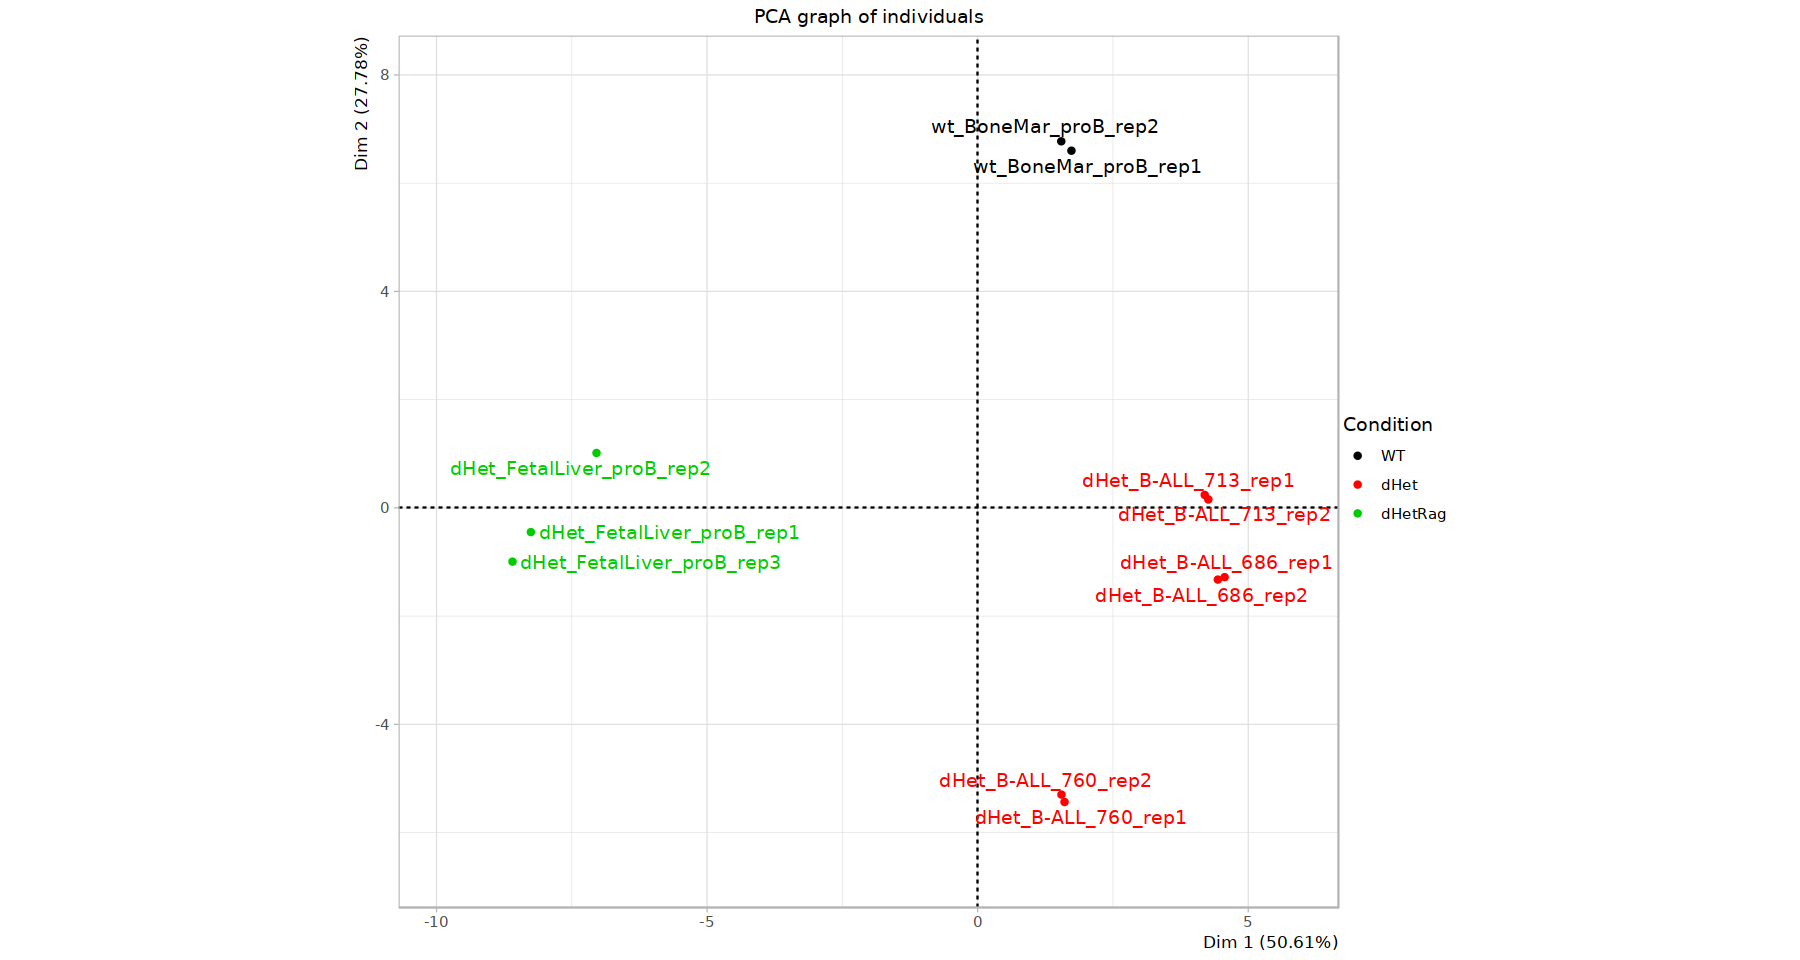

In [61]:
## Code cell 54 ##

#pdf("nom_fichier.pdf")
# les composantes par défaut sont les 1 et 2
# vous pouvez les modifier via l'argument "axes"

FactoMineR::plot.PCA(PCAres, choix = "ind", autoLab = "yes", invisible = "quali", cex = 1,
                     habillage = "Condition", axes = c(1,2))

#dev.off()

The package `factoextra` allows to color points and to add ***circles*** or ***ellipses*** around the groups of points sharing some qualitative characteristics. A large dot is plotted at the barycentre.
 
We can thus visualize points per conditions. Note that there are too few points for the WT and dHetRag to draw an ellipse.


Too few points to calculate an ellipse
Too few points to calculate an ellipse


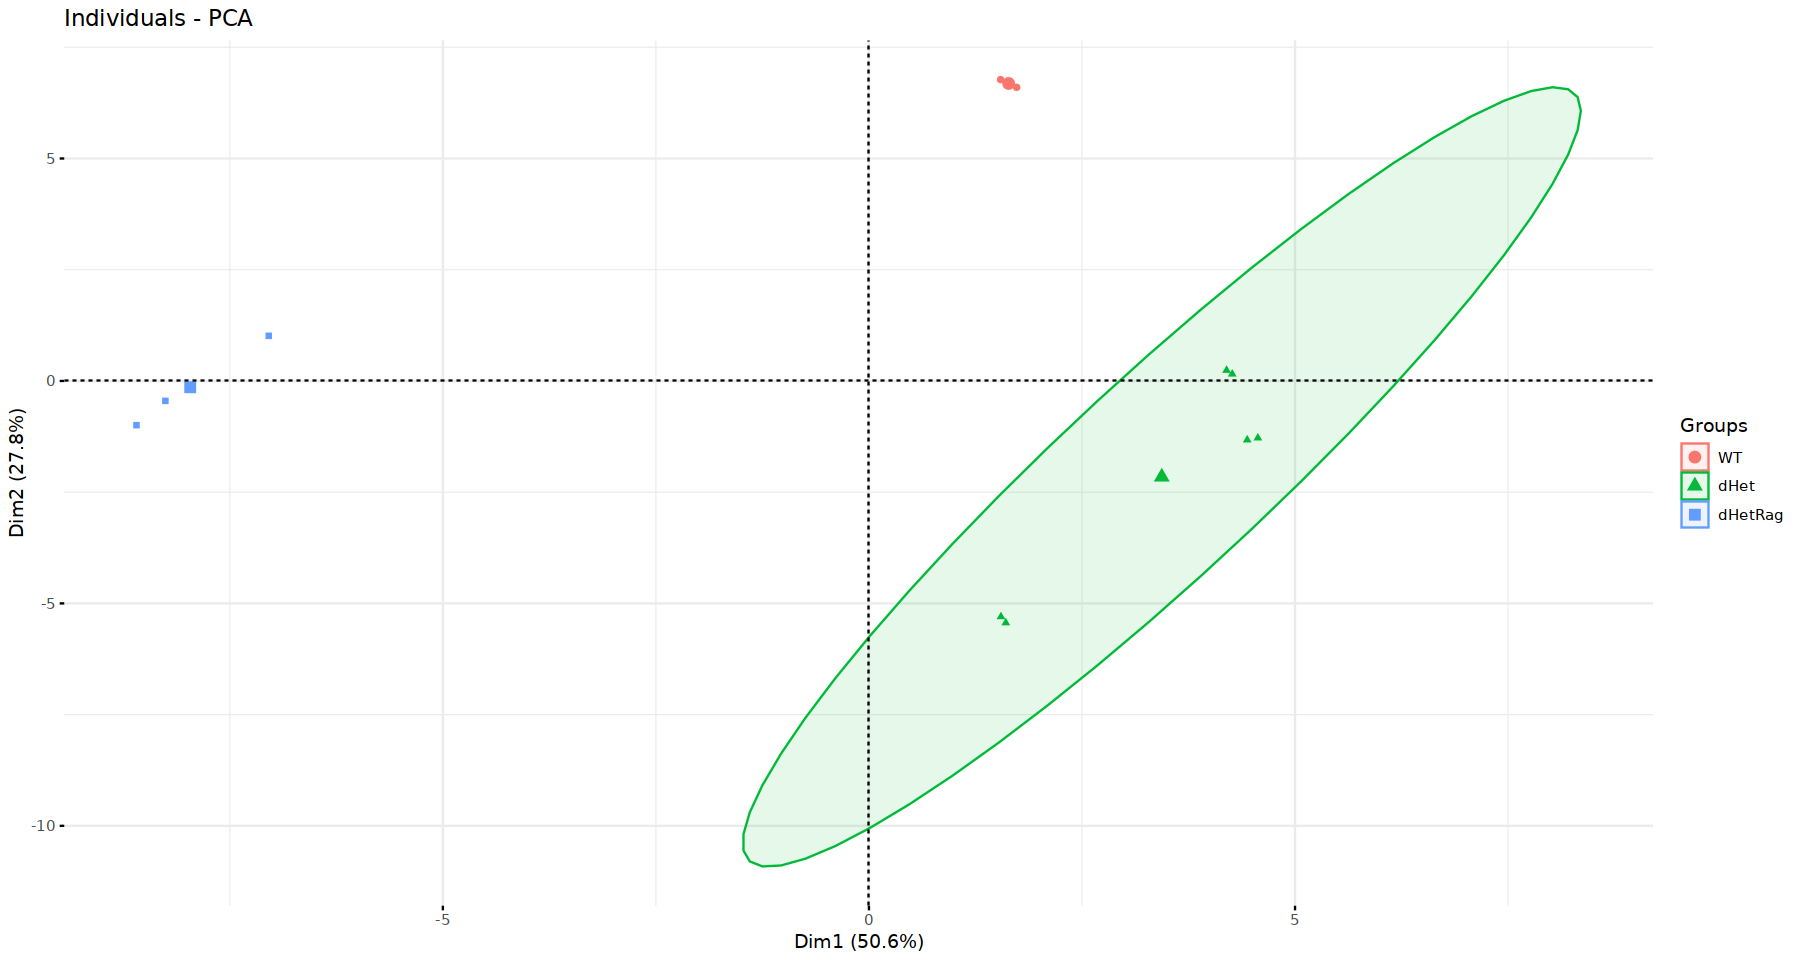

In [62]:
## Code cell 55 ##

factoextra::fviz_pca_ind(PCAres, label = "none",
                         habillage = as.factor(PCAres$call$quali.sup$quali.sup$Condition),
             addEllipses = TRUE, ellipse.level = 0.95)

We look now at the sex on dim1 and dim2, then dim2 and dim3:

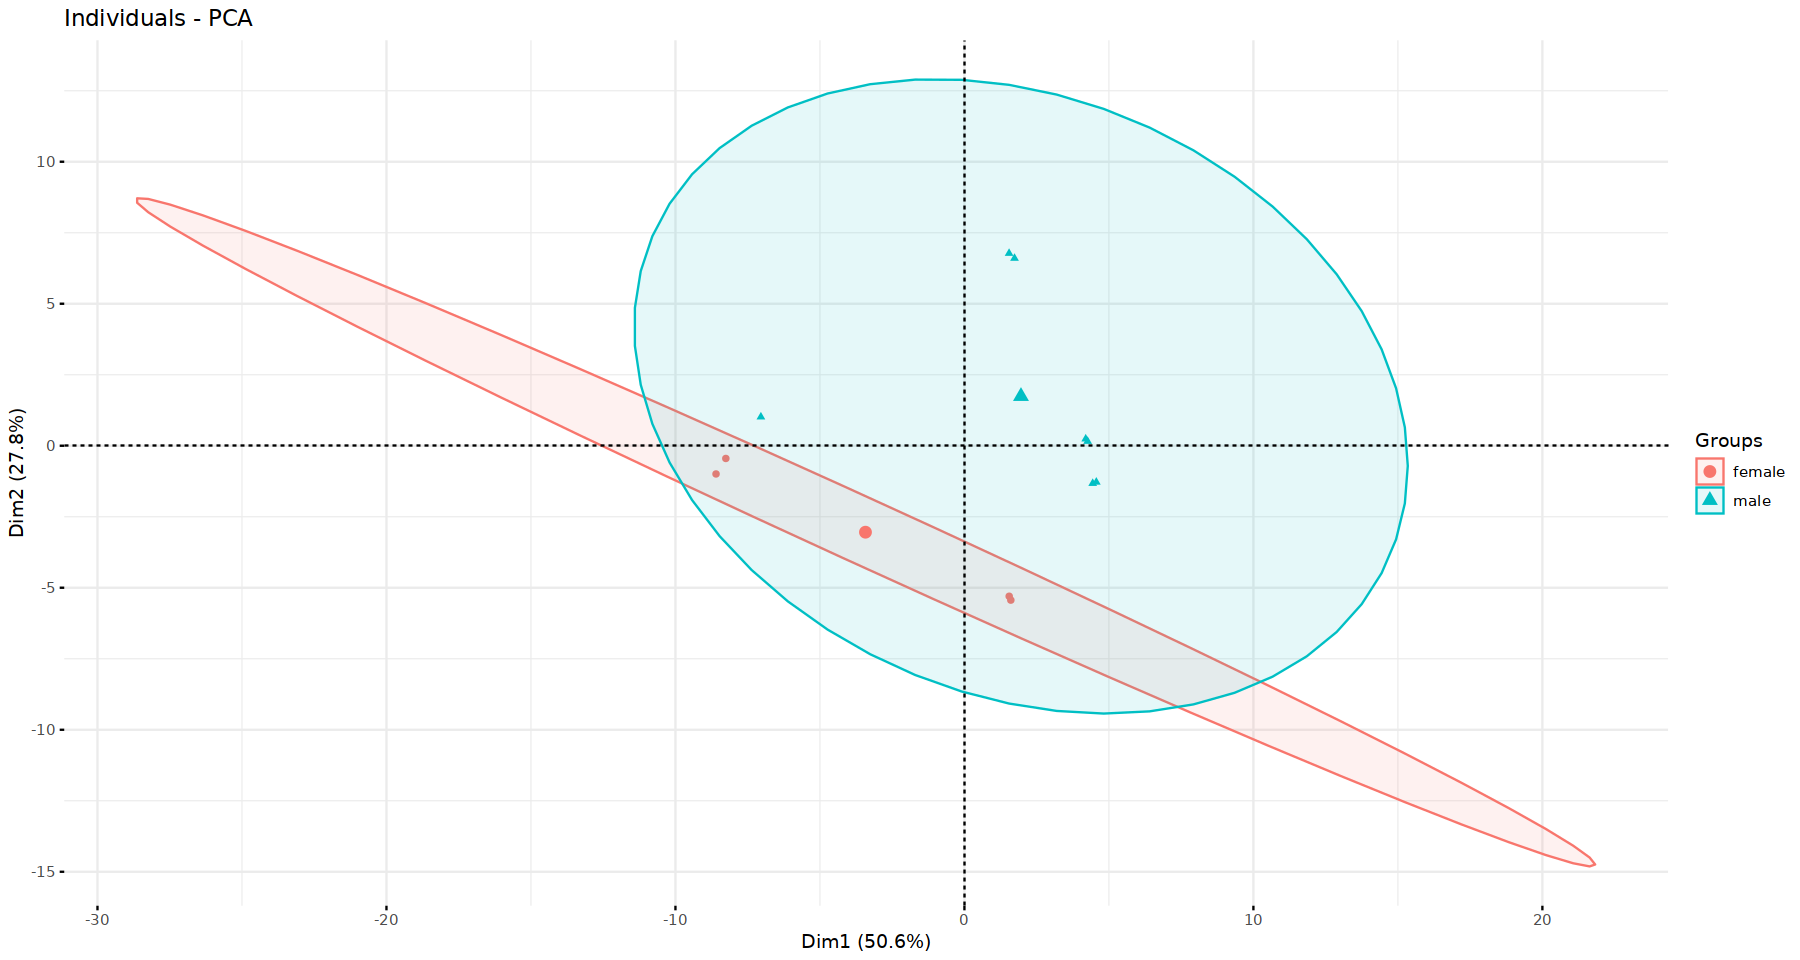

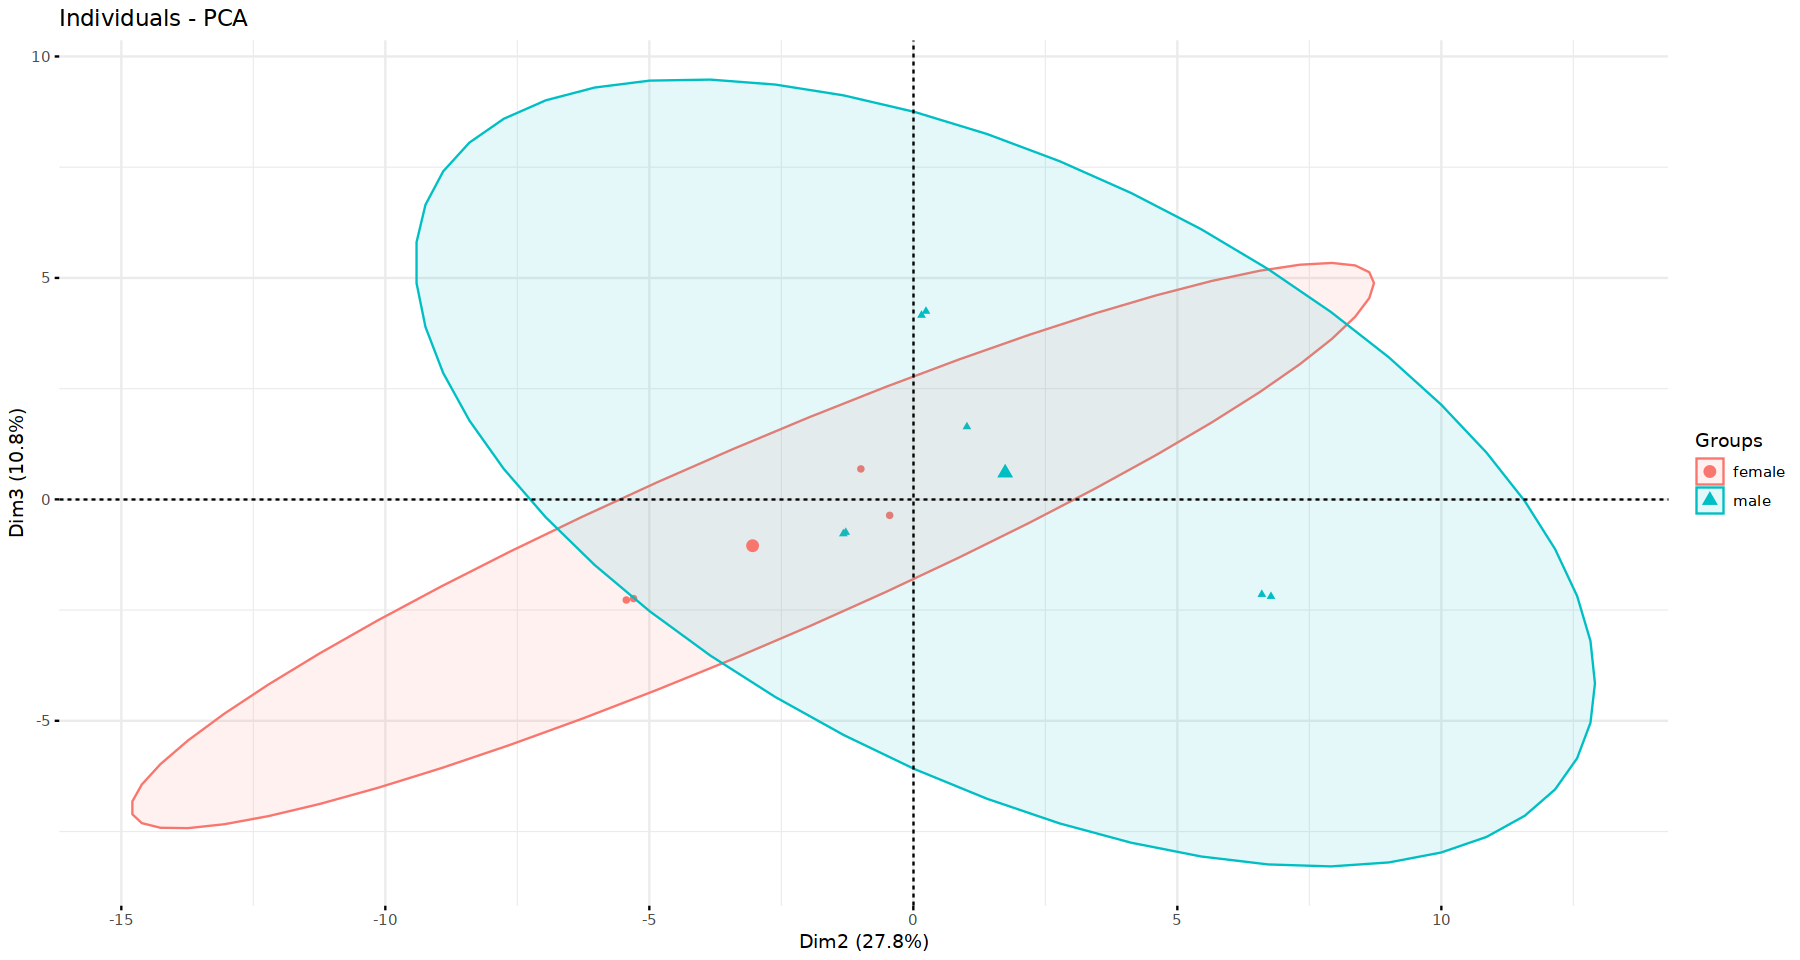

In [63]:
## Code cell 56 ##

factoextra::fviz_pca_ind(PCAres, label = "none",
                         habillage = as.factor(PCAres$call$quali.sup$quali.sup$sex),
             addEllipses = TRUE, ellipse.level = 0.95)

factoextra::fviz_pca_ind(PCAres, label = "none",
                         habillage = as.factor(PCAres$call$quali.sup$quali.sup$sex),
             addEllipses = TRUE, ellipse.level = 0.95, axes = c(2,3))

or here with the tissue :

Too few points to calculate an ellipse
Too few points to calculate an ellipse


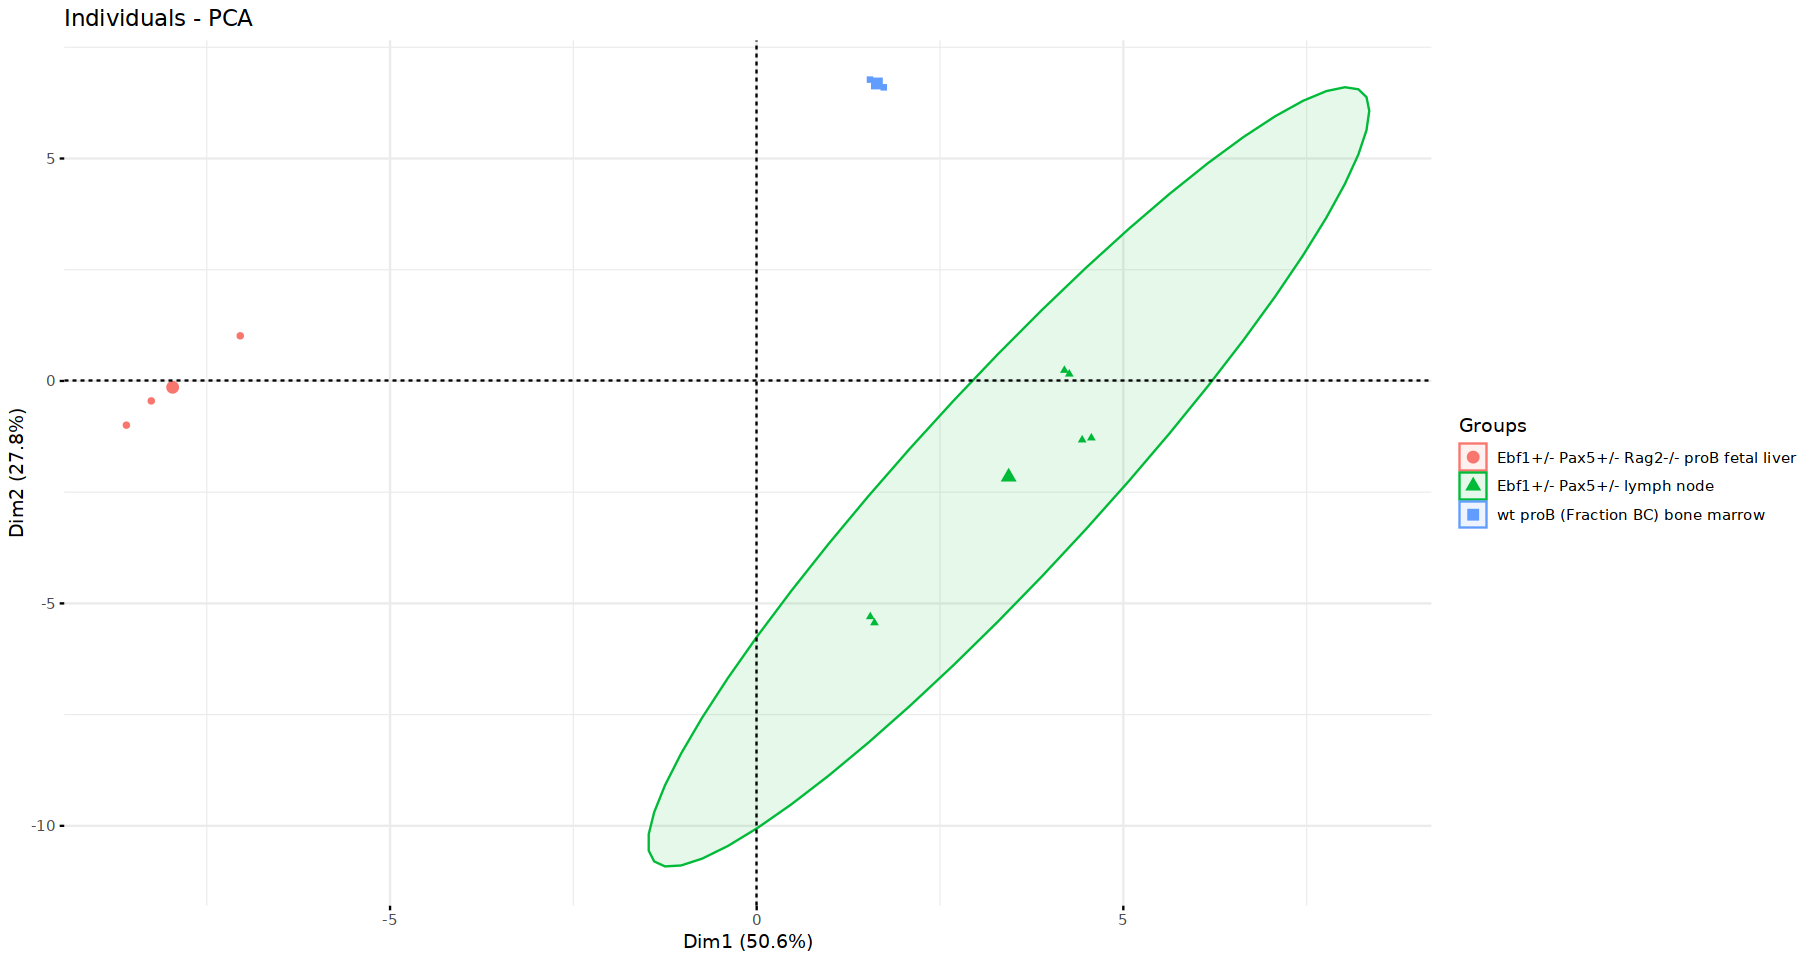

In [64]:
## Code cell 57 ##

factoextra::fviz_pca_ind(PCAres, label = "none",
                         habillage = as.factor(PCAres$call$quali.sup$quali.sup$Tissue),
             addEllipses = TRUE, ellipse.level = 0.95)

- graphical **representation of correlations with quantitative metadata**:

One can also use a quantitative variable to color the points with a ***gradient***.

Let'st give it a go with Sos1 gene and Gm2629 genes:

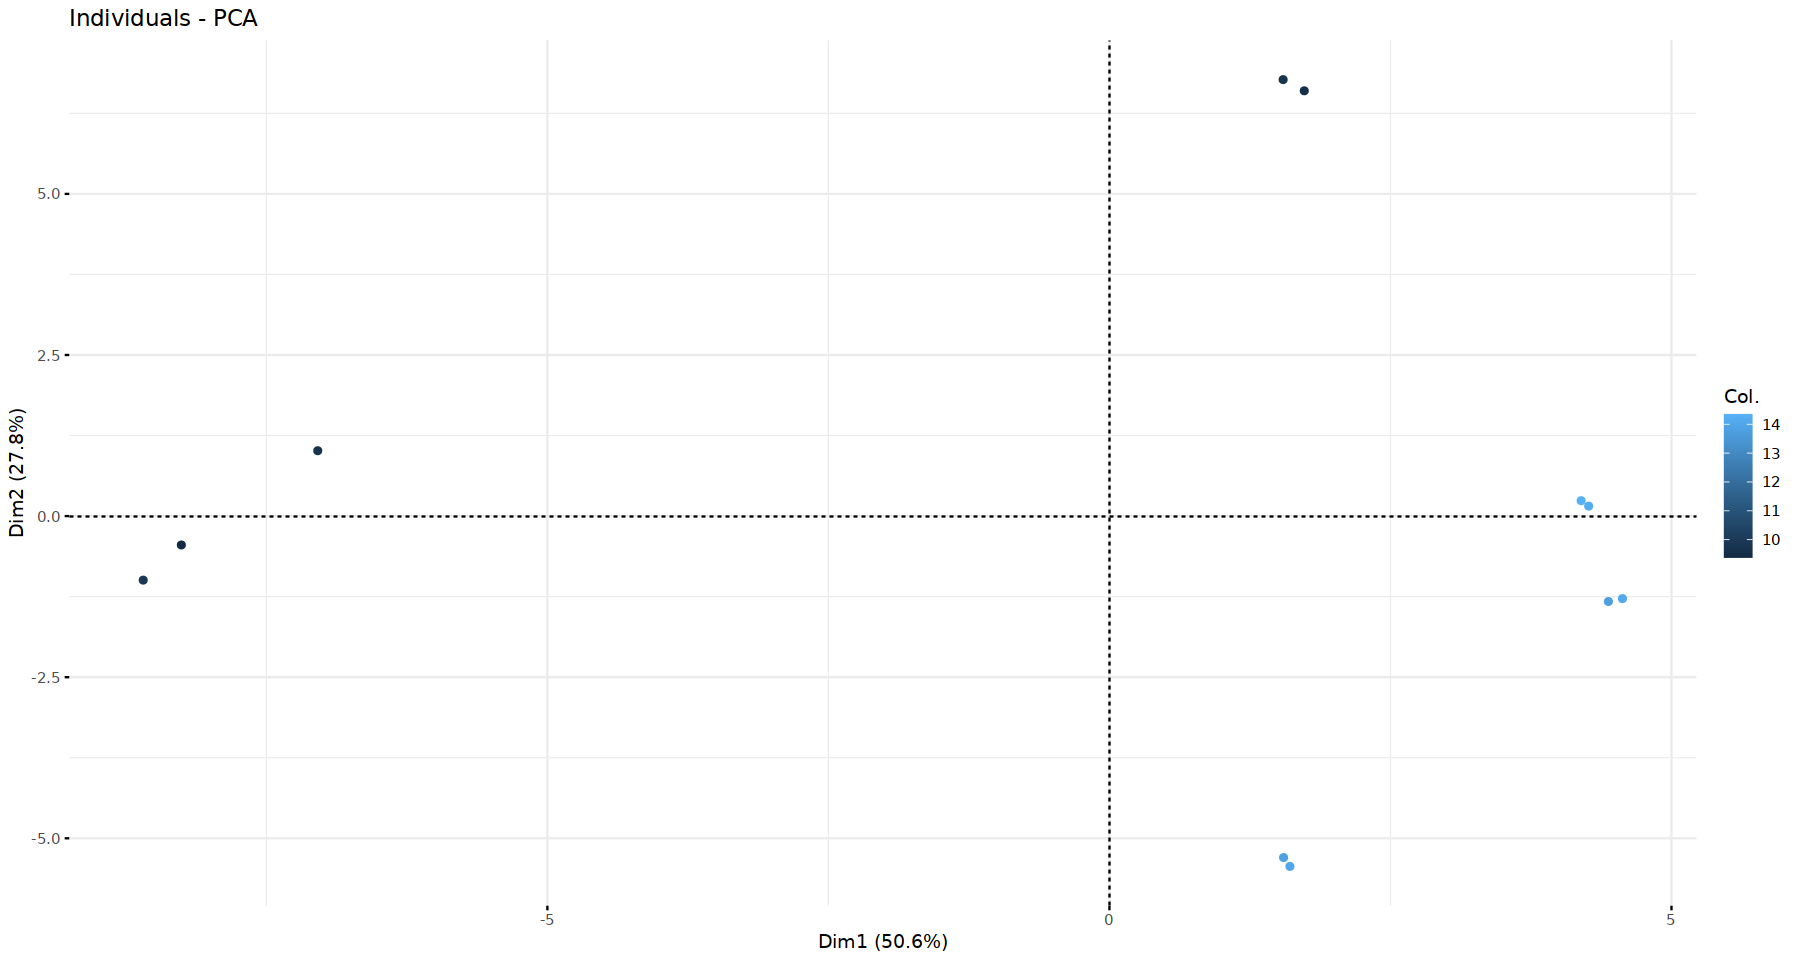

In [67]:
## Code cell 58 ##

factoextra::fviz_pca_ind(PCAres, label="none",
                         col.ind = as.numeric(PCAres$call$quanti.sup$Sos1))

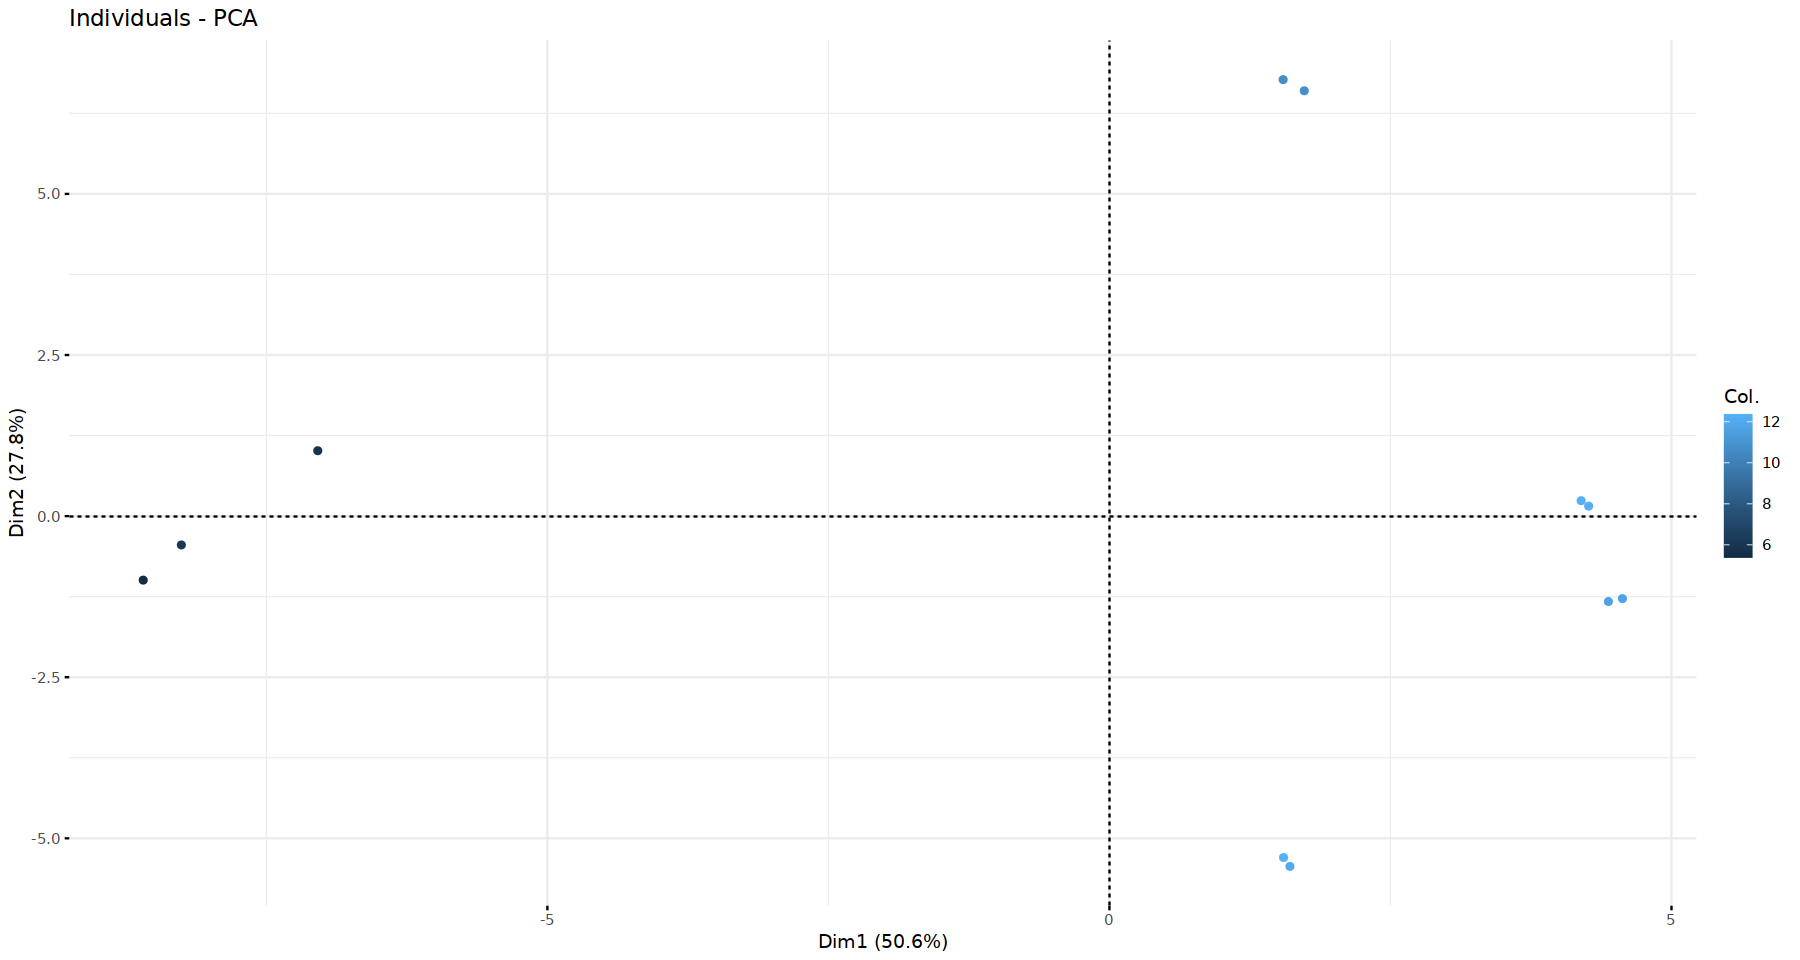

In [68]:
## Code cell 59 ##

factoextra::fviz_pca_ind(PCAres, label="none",
                         col.ind = as.numeric(PCAres$call$quanti.sup$Gm2629))

That's a good way to know which variable (*here gene*) best contributes to the inertia described by one componant/axis.

#### **2.3-f. Analysis of correlations between observations/conditions, variables and the PCA components**

- **Contribution of one observation *(here a mouse condition)* to the different PCA components:**

This is used to know which condition contributes the most to one axis. Below is a code to detect the top 30 genes contributing to axis 1.

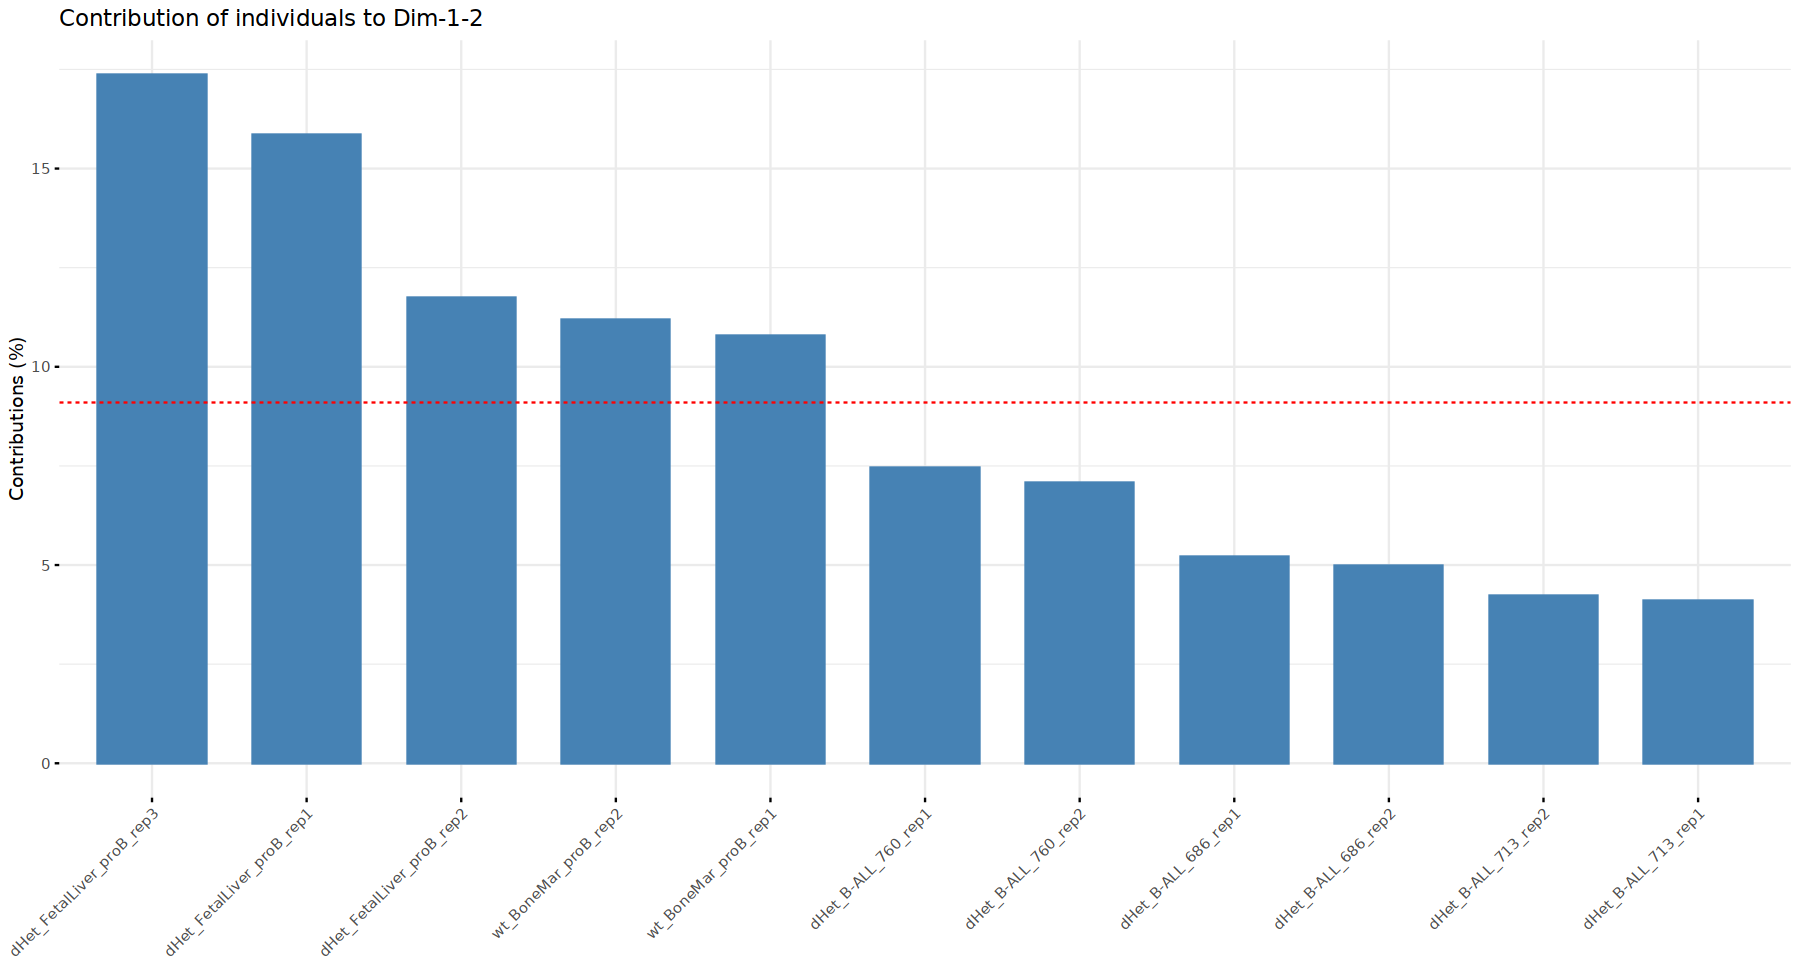

In [71]:
## Code cell 60 ##

factoextra::fviz_contrib(PCAres, choice = "ind", axes = 1:2, top = 30)

- **Contribution of each variable used for the PCA *(levels of expression)* to PCA components** :

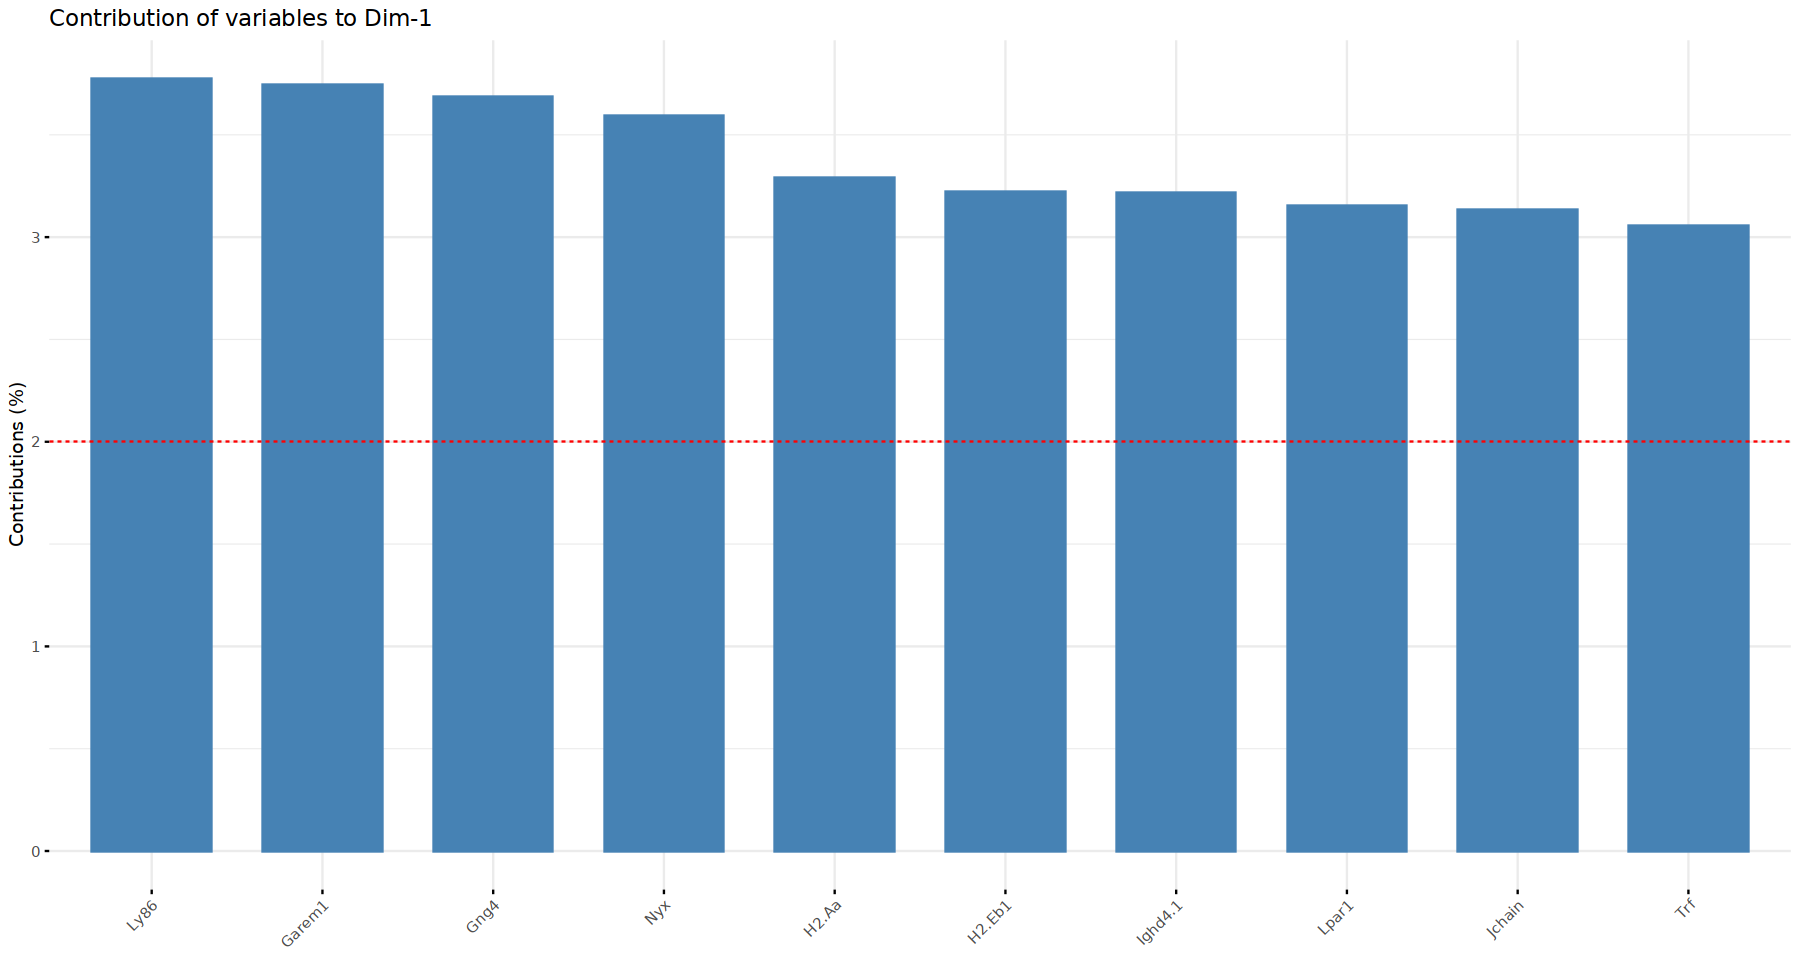

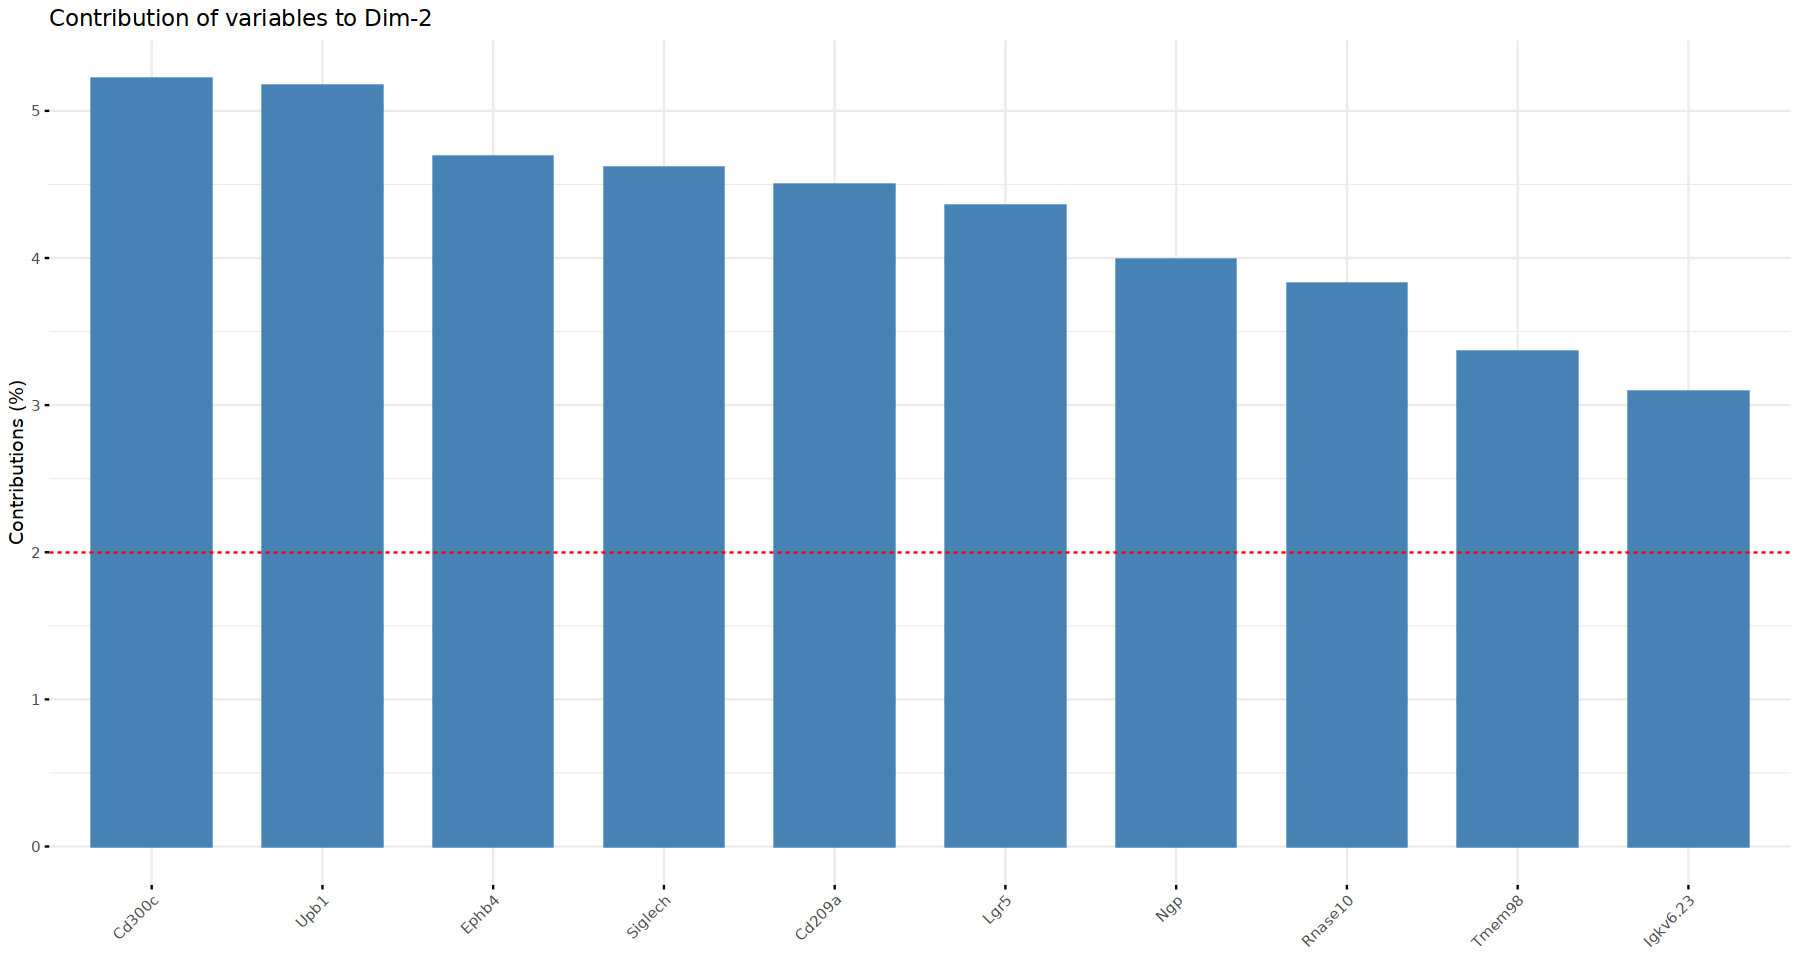

In [72]:
## Code cell 61 ##

# Contributions to axis one of the top 10 genes contributing to it :
factoextra::fviz_contrib(PCAres, choice = "var", axes = 1, top = 10)

# Contributions to second axis:
factoextra::fviz_contrib(PCAres, choice = "var", axes = 2, top = 10)

- **Correlation between quantitative variables used for the PCA and the PCA components**

In our example, a gene that strongly contributes to a PCA axis will have its level of expression correlated with it. If the contribution is expressed in % and is positive, the correlation can be either positive or negative.

- **positive correlation** *(0 < rho < 1)*: observations *(here conditions)* with high values for the considered component have also a high level of the quantitative variable *(here gene expression)*.

- **negative correlation** *(-1 < rho <0)*: observations high values for the considered component have a small level for the quantitative variable.
 
The __correlation circle__ shows the correlation between the quantitative variables *(here gene levels)* and the PCA eigen vectors. Each transcript is represented with an arrow. The end of the arrow indicates the correlation coefficient between the transcript and the two displayed components.

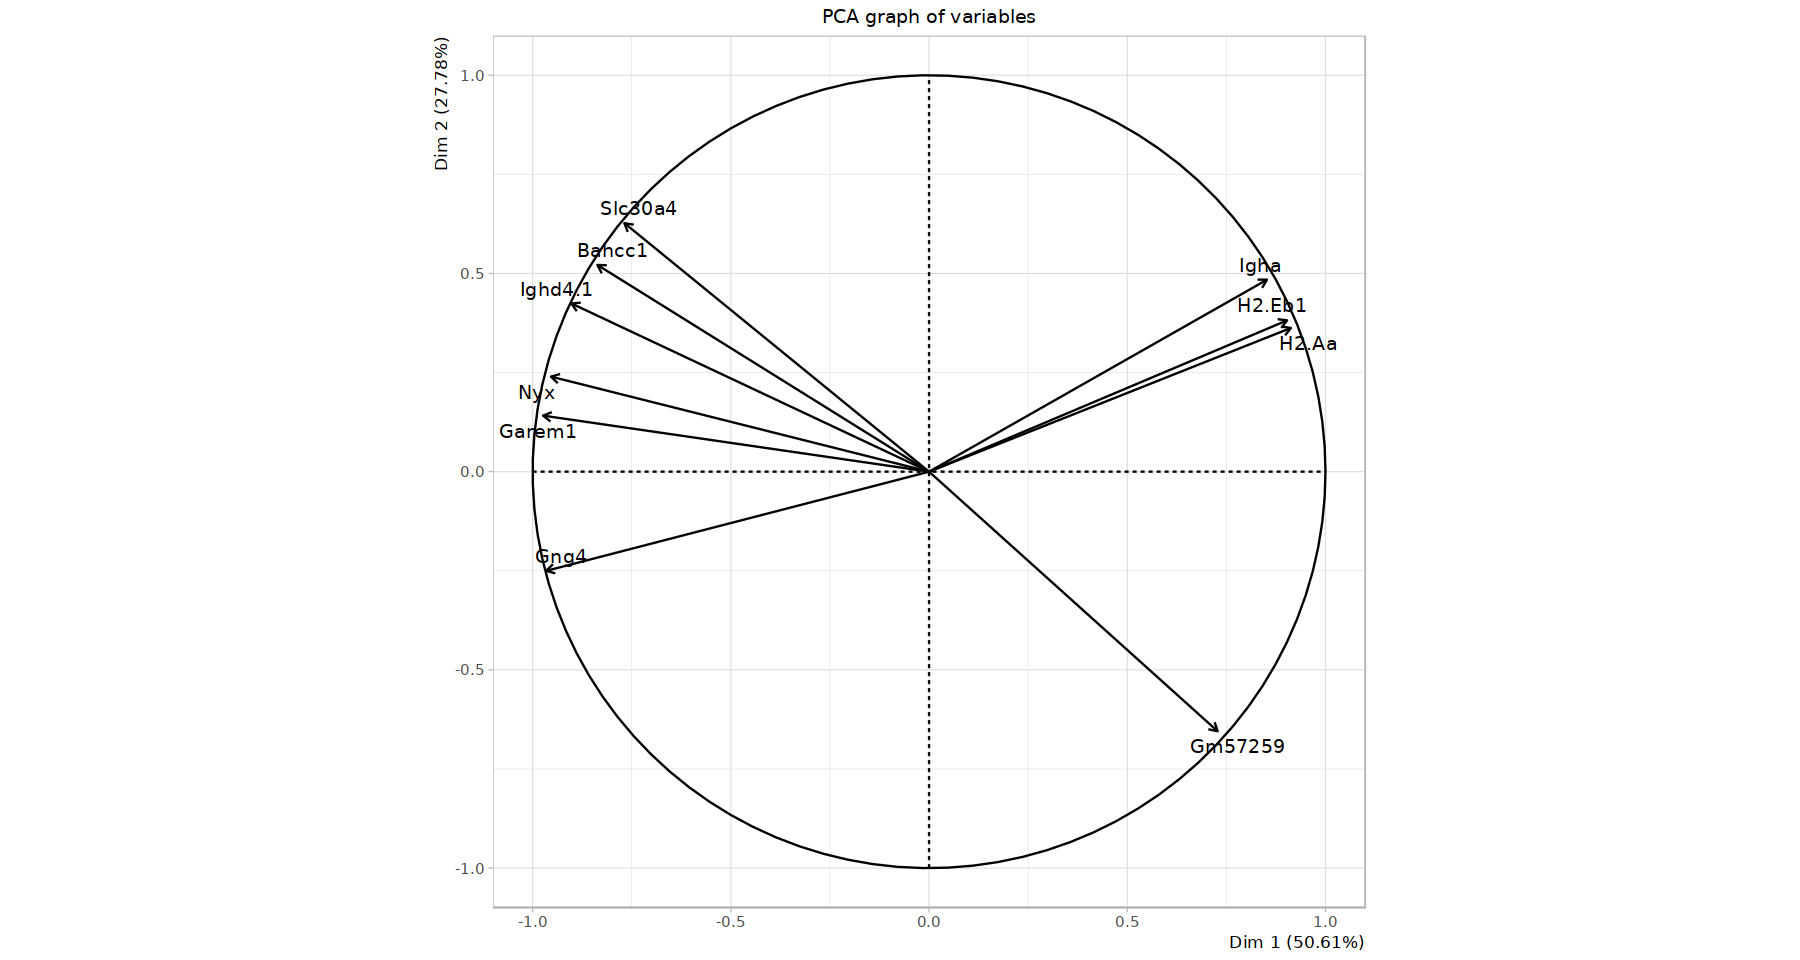

In [73]:
## Code cell 62 ##

# Correlation circle
# with the argument "contrib 10" you display the top 10 genes with the best correlations with axes 1 and 2

#pdf(file = "PCA_diab_contrib30.pdf")
FactoMineR::plot.PCA(PCAres, choix = "var", cex = 1, select = "contrib 10", unselect = 1)
#dev.off()

Same plot, using `factoextra`:

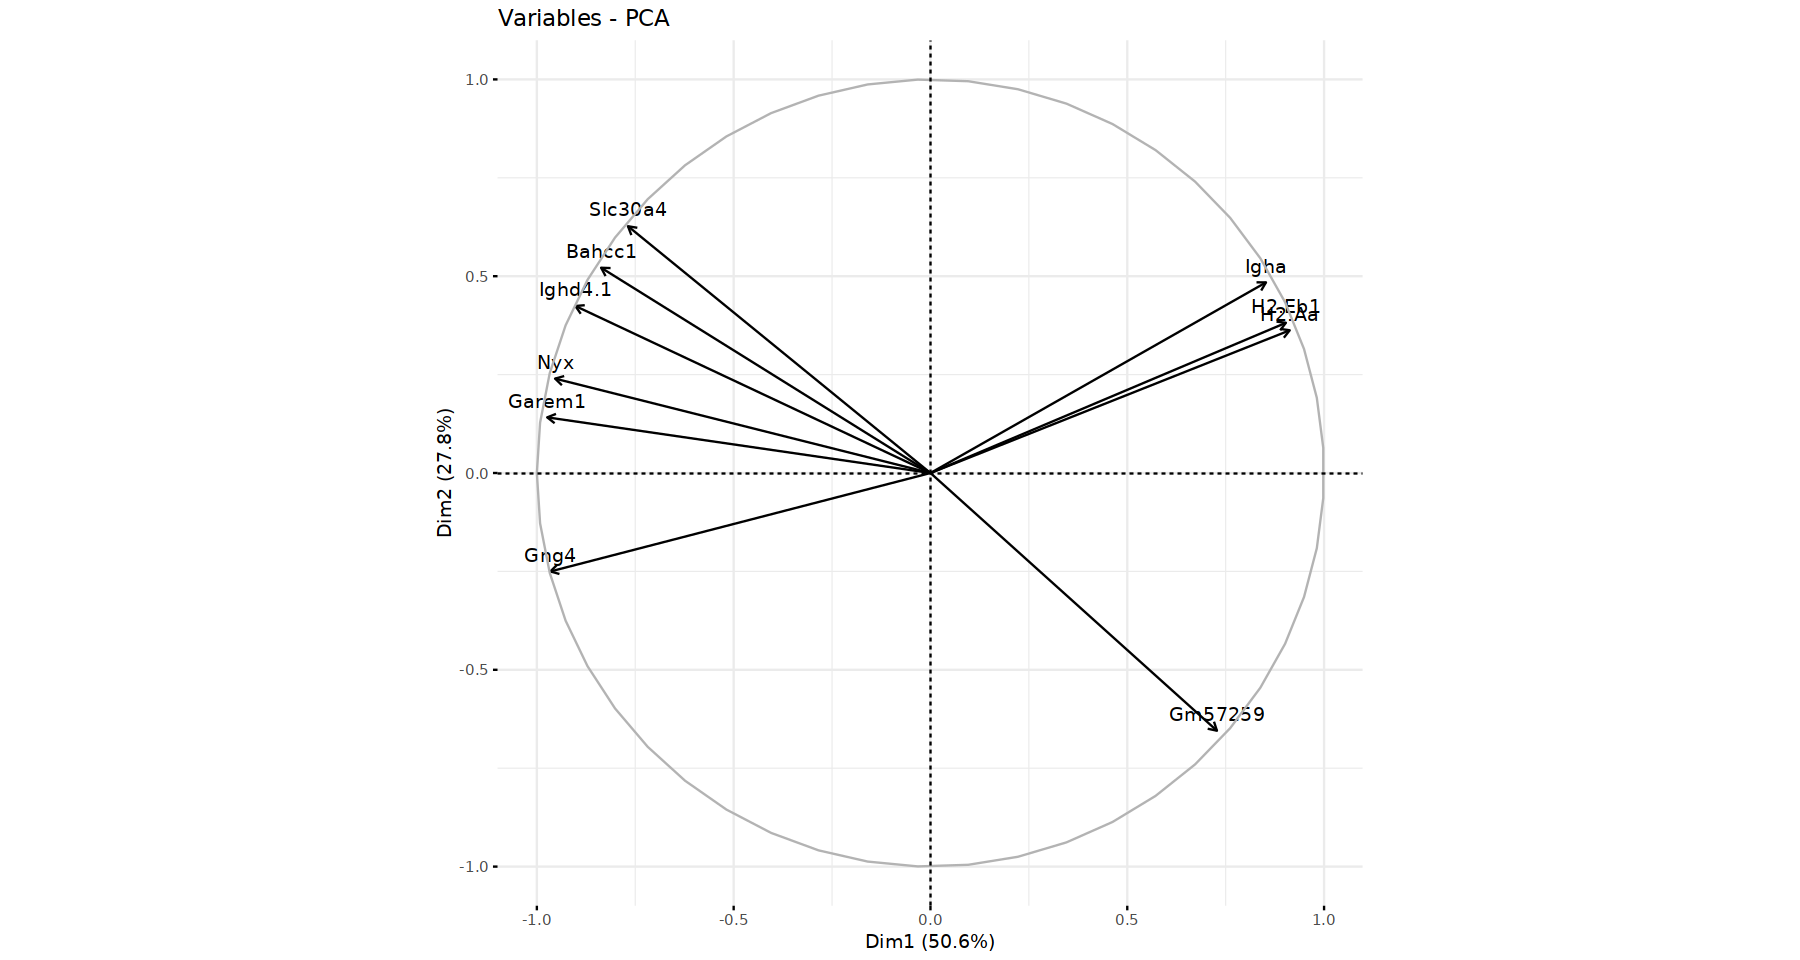

In [74]:
## Code cell 63 ##

factoextra::fviz_pca_var(PCAres, select.var = list(contrib = 10))

One can decide to put a threshold on the level of correlation.

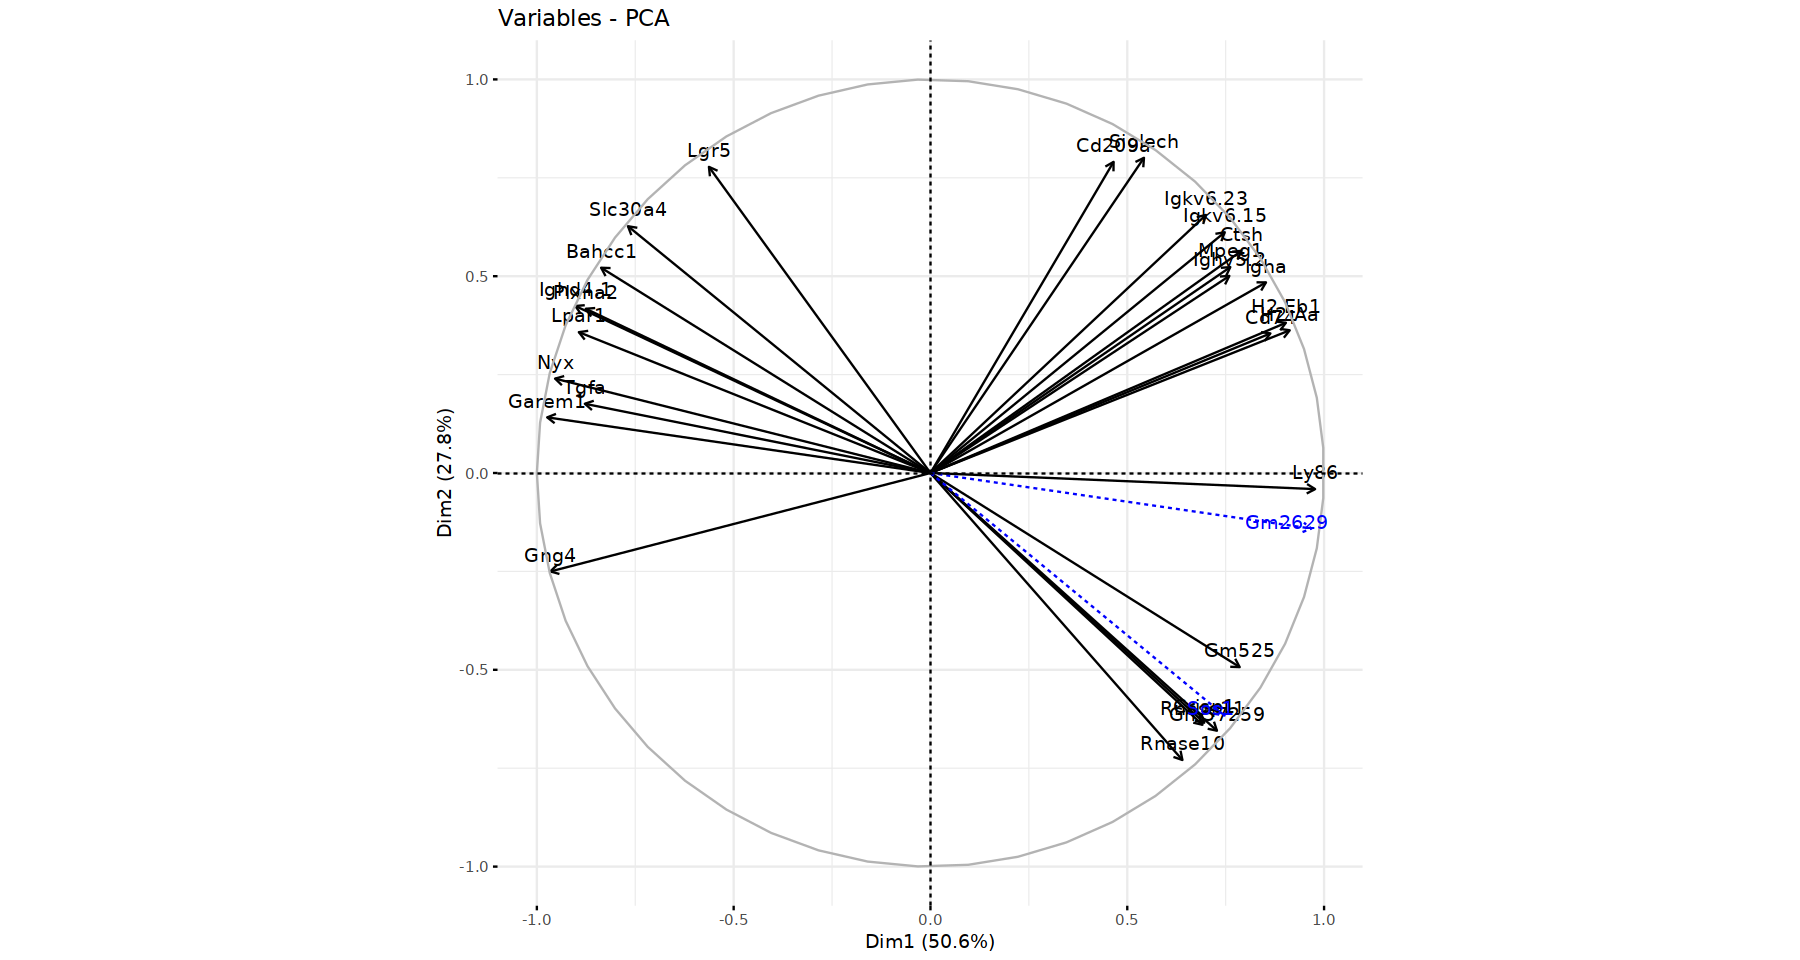

In [75]:
## Code cell 64 ##

factoextra::fviz_pca_var(PCAres, select.var = list(cos2 = 0.8))

- **Biplots of observations and variables**

A biplot allows to display simultaneoulsy the scatter plot (PCA plot) of observations (with the best labelling) and the variables mostly contributing to the displayed axes.   


<div class="alert alert-block alert-warning"><b>Warning:</b><br> Do not try to display too many variables, otherwise the plot would not be meaningful.</div>

Here we choose to display the top 10 variables and observations colored according to the condition on the first and second PCA axes : 

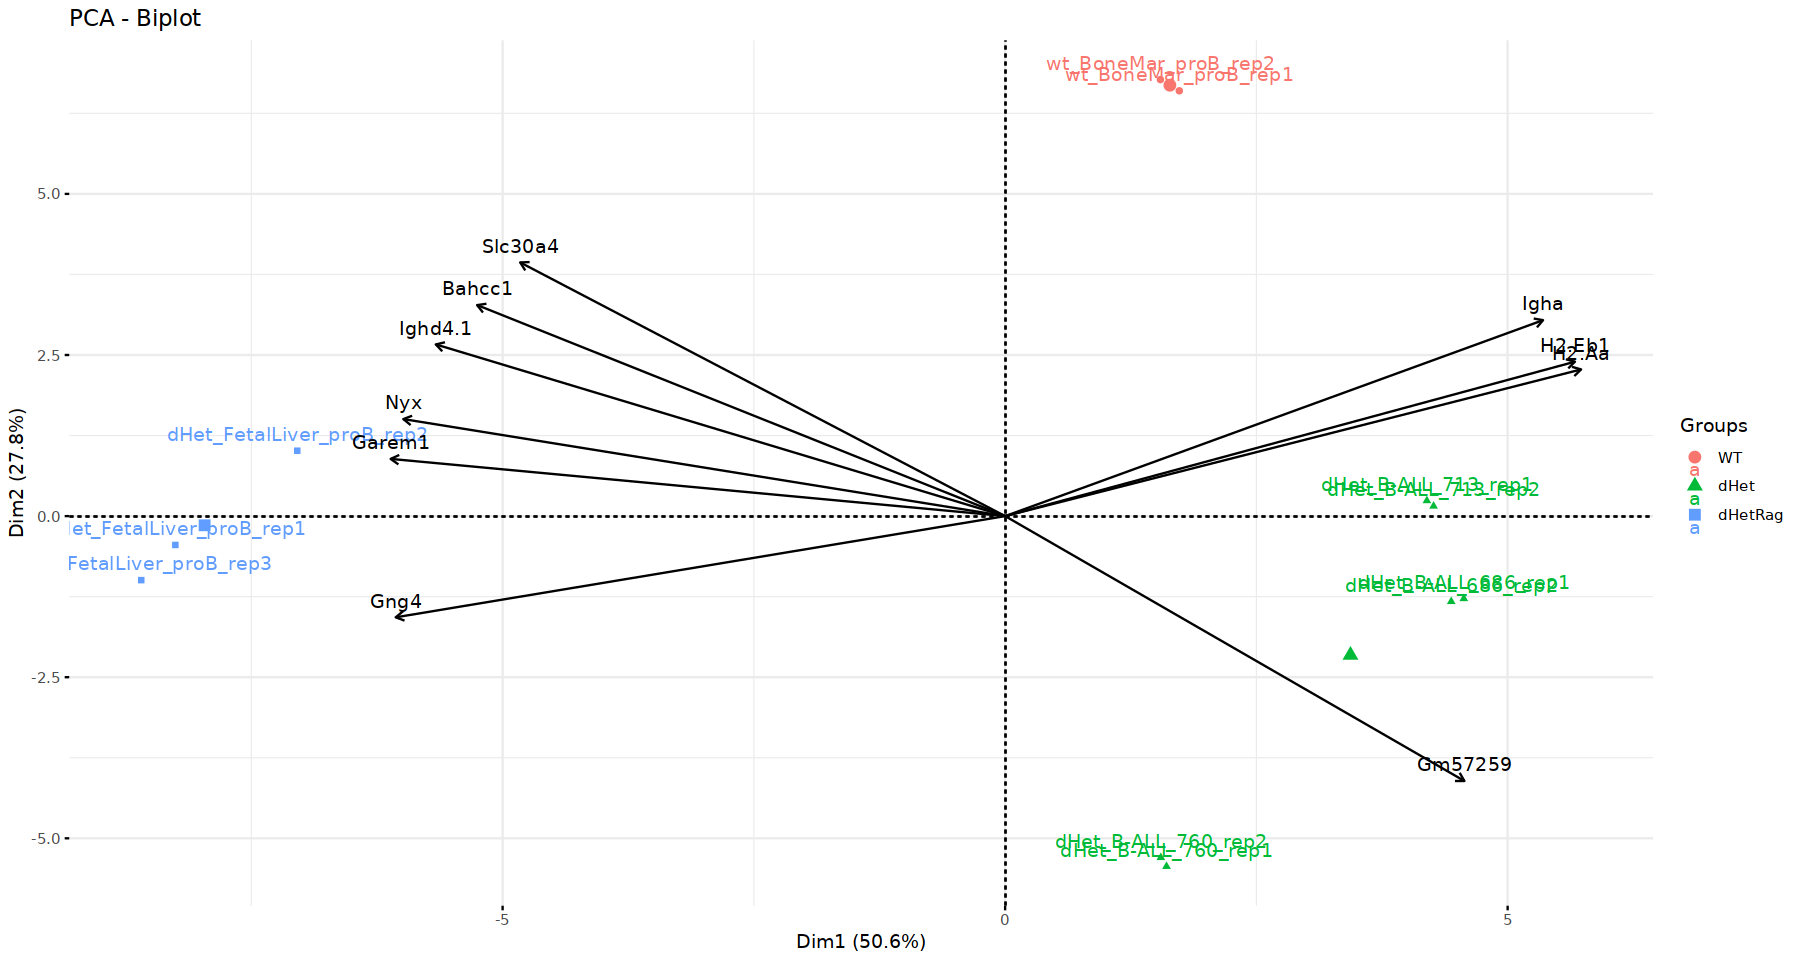

In [76]:
## Code cell 65 ##

factoextra::fviz_pca_biplot(PCAres, select.var = list(contrib = 10),
                            col.var = "black",
                            habillage = as.factor(PCAres$call$quali.sup$quali.sup$Condition))

- **Correlation of a specific variable with specific axes:**

Finally, we can compute the correlation of one transcript level with positions on a given axis.

In [77]:
## Code cell 66 ##

# Lignes de codes pour calculer les coefficients de corrélation entre le niveau des transcrits et la position des échantillons sur les axes
cor.test(for_factominer$Xist, PCAres$ind$coord[,1])
cor.test(for_factominer$Xist, PCAres$ind$coord[,2])


	Pearson's product-moment correlation

data:  for_factominer$Xist and PCAres$ind$coord[, 1]
t = -1.9332, df = 9, p-value = 0.08524
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.86158459  0.08622718
sample estimates:
       cor 
-0.5416658 



	Pearson's product-moment correlation

data:  for_factominer$Xist and PCAres$ind$coord[, 2]
t = -1.9977, df = 9, p-value = 0.07684
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.86614760  0.06835021
sample estimates:
       cor 
-0.5542499 


---  
---

## 3 - Clustering and Heatmaps 
---

### 3.1 - Hierarchical clustering   
---

As we did before normalisation, we will look at the grouping of our samples using a Hierarchical Clustering.    
This  representation is used to cluster the samples based on dissimilarity indexes *(see lecture 12, here we will use the Ward distance)*. More information can be found with `?hclust` (or in the Contextual Help panel on the right, that can be opened via the Help menu).

Hierarchical clustering is performed in two steps: calculate the distance matrix and apply clustering. 

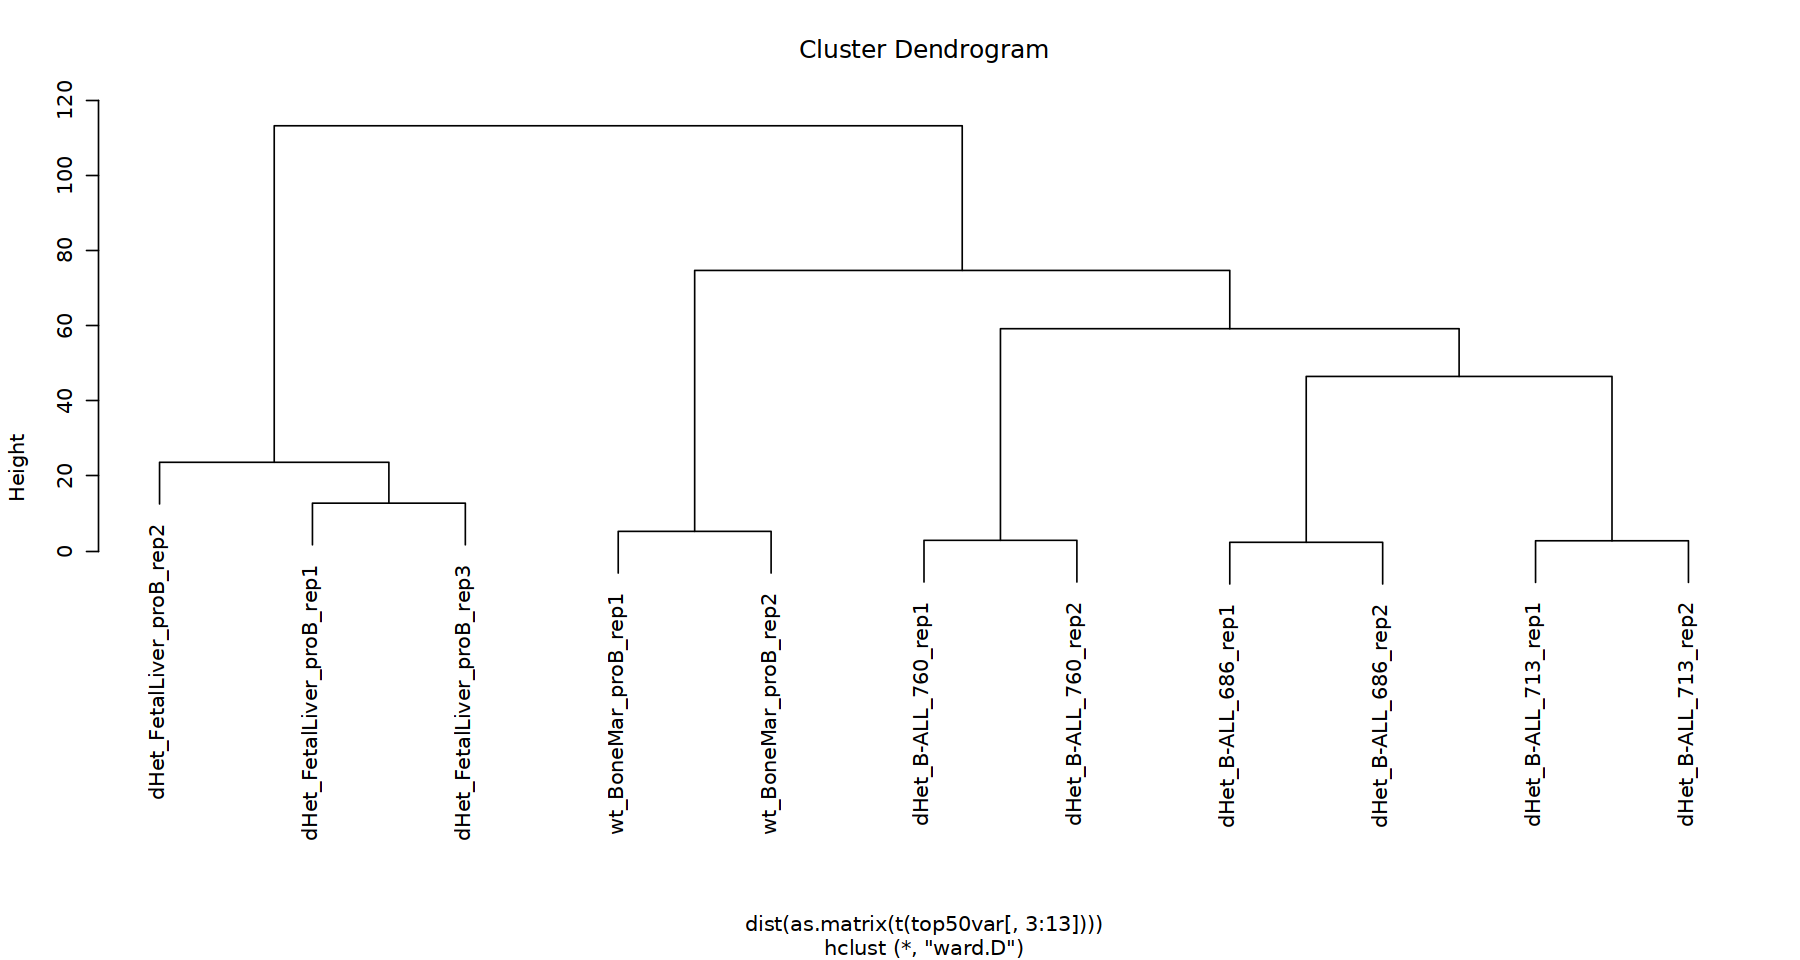

In [78]:
## Code cell 67 ##
   
clusters <- hclust(dist(as.matrix(t(top50var[ ,3:13]))), method = "ward.D" )
plot(clusters)

rm(clusters)    


We can see that replicates from the same mouse cluster together, as expected. What is less expected is the grouping together of leukemic cells with WT ones! You could test other methods and see that this clustering is robust.

### 3.2 - Simple heatmaps   
---

Another way of looking at  expression data is a heatmap, that shows the level of expression of genes as colors, usually organised with samples in columns, and genes as rows.   

A simple and efficient way of plotting such a display is the function `heatmap()`, that gives a combined output combining a heatmap and dendrograms grouping samples and genes, as in hierarchical clustering:

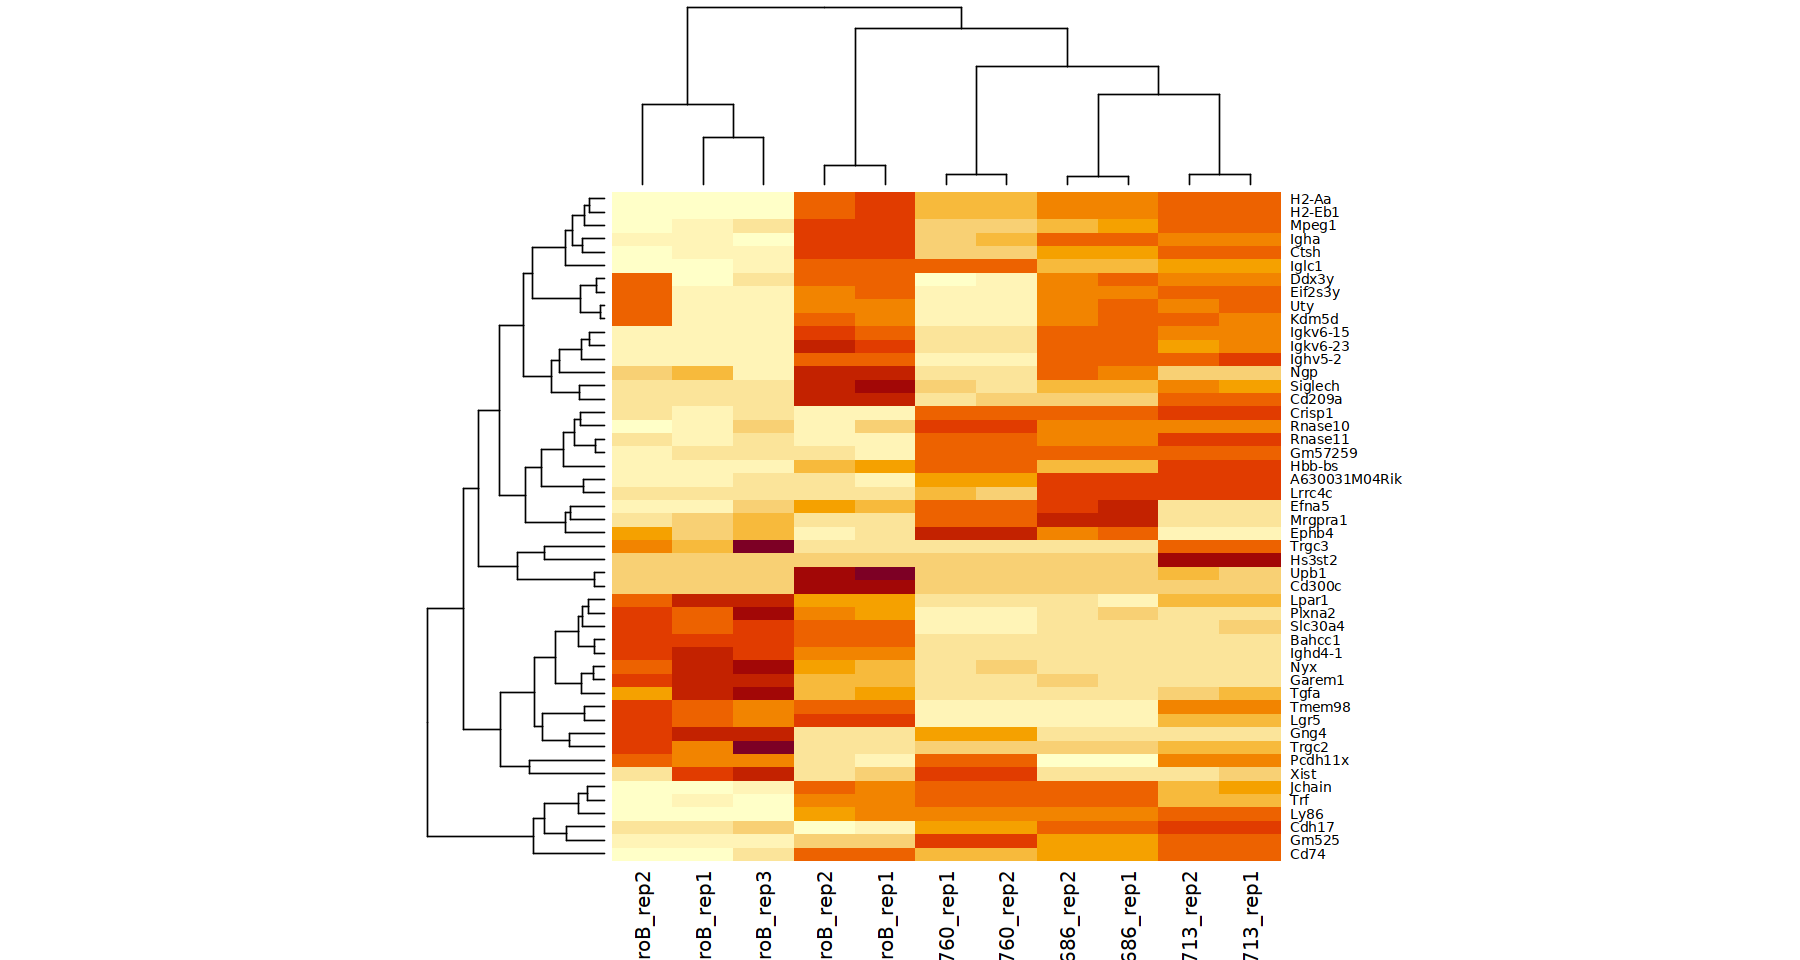

In [79]:
## Code cell 68 ##

heatmap(as.matrix(top50var[,c(3:13)])) 

### 3.2 - Enhanced heatmaps with `ComplexHeatmap`
---

There are two main packages to draw enhanced heatmaps:
- [pheatmap](https://cran.r-project.org/web/packages/pheatmap/index.html): a CRAN packages.
- [ComplexHeatmap](https://jokergoo.github.io/ComplexHeatmap-reference/book/) on GitHub but also available in Bioconductor, the second generation of pheatmap.

`ComplexHeatmap` is the most flexible tool to draw heatmaps with a lot of options, notably to add annotations.  
Below is presented a quick example on ComplexHeatmap usage.

- To use ComplexHeatmap, the dataset must be a **matrix** with samples in columns and genes in rows. We thus transpose our matrix `top50var`.

- In addition, we use the function `scale()` to **center our data with a Z score**. Centering the values will provide a heatmap with a more neutral color for middle values, thus enabling a better visualisation of variations.

In [80]:
## Code cell 69 ##

t_top50var <- t(apply(top50var[,c(3:13)], 1, scale))

- Then you select a **distance** for the similarity between samples. It can be a pre-defined character which is in (`euclidean`, `maximum`, `manhattan`, `canberra`, `binary`, `minkowski`, `pearson`, `spearman`, `kendall`). Default is `euclidean`.    
It can also be a function. In R the function to compute distances is `dist()`. The correlation distance is defined as 1 - cor(x, y, method). [See there](https://jokergoo.github.io/ComplexHeatmap-reference/book/a-single-heatmap.html#distance-methods) for further details.

- You can also select the **clustering method** by `clustering_method_rows` and `clustering_method_columns`. Possible methods are those supported in `hclust()` function: `ward.D`, `ward.D2`, `single`, `complete`, `average` (= UPGMA), `mcquitty` (= WPGMA), `median` (= WPGMC) or `centroid` (= UPGMC).

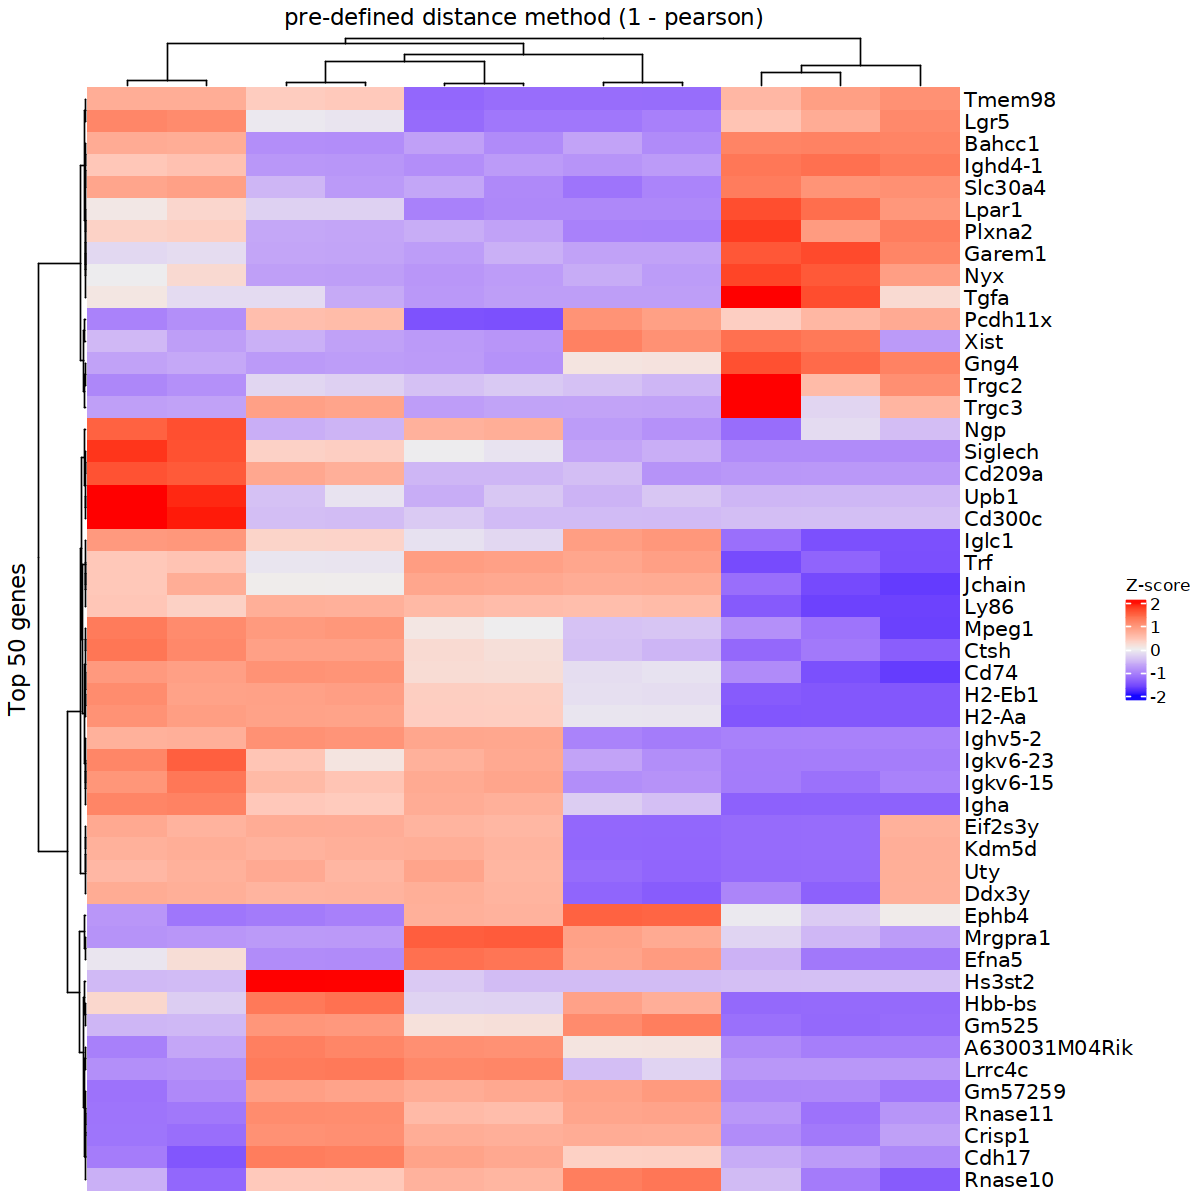

In [81]:
## Code cell 70 ##

# we change the dimension of the output for better rendering
options(repr.plot.width = 10, repr.plot.height = 10)

ComplexHeatmap::Heatmap(t_top50var,
                        name = "Z-score",
                        clustering_distance_rows = "pearson",
                        column_title = "pre-defined distance method (1 - pearson)", row_title = "Top 50 genes",
                        clustering_method_rows = "ward.D")

- One nice usage of ComplexHeatmap is the possibility to add custom **annotations**: `ha` for "heatmap annotation" is the object name used in ComplexHeatmap tutorial.

- You can add annotations on samples, either quantitative annotations with the function `anno_points()` or `anno_barplot()` or qualitative annotations from a dataframe. The `col` argument is used to specify the colors of the different categorical values. For the quantitative values, you can add points or boxplots for example.   

Many beautiful examples can be found in the [Complex Heatmap manual](https://jokergoo.github.io/ComplexHeatmap-reference/book/), and a nice progressive tutorial is available [here](https://www.datanovia.com/en/lessons/heatmap-in-r-static-and-interactive-visualization/). 

---  
---

## 4 - Correlograms
---

Gene co-expression correlations provide a robust methodology for predicting gene function, as genes sharing a biological process or a common implication in pathways are often co-regulated.  This is particularly helpful to provide clues to the functions and roles of lncRNA genes, on the basis of the *"guilty by association"* method: if lncRNA genes cluster with genes with known functions, they are likely to participate to the same biological process.    

We want to see if the top variant genes identified above have a correlated expression in a pair-wise manner, that is if two genes share a similar pattern of expression across samples.

A Pearson or Spearman correlation is performed between continuous variables with the `cor()`  function, resulting in a correlation coefficient between each pair of genes. This correlation is displayed in a scatter plot with the function `plot()`.

<div class="alert alert-block alert-info"><b><u>What are correlograms?</u></b><br>
<br>When we want to study pairwise correlation between several variables (here genes are the variables), the <code>cor()</code> function can also be applied on a matrix of data. <b><br>
<i>A correlogram is the pairwise graphical representation of the matrix of correlation coefficients</i></b>. Such a correlogram helps highlighting the most correlated variables. Some R packages will also allow to display the pvalues or to reorder variables according to their degree of correlation.

You have arleady used heatmaps in session 1 to look at similar patterns of expression among a set of genes, such as the DE genes. Among distances that could be used to cluster genes in a heatmap, we could have used the Pearson distance = (1-r). In a correlogram, we rather display the <b><i>correlation coefficient ranging from -1 to 1</i></b>.
</div>


###  4.1 - With R native functions
---

- with the `heatmap` function   
which is also able to display a correlogramme.

We will have first to transpose the matrix of data with the `t()` function to have each gene name as a variable.

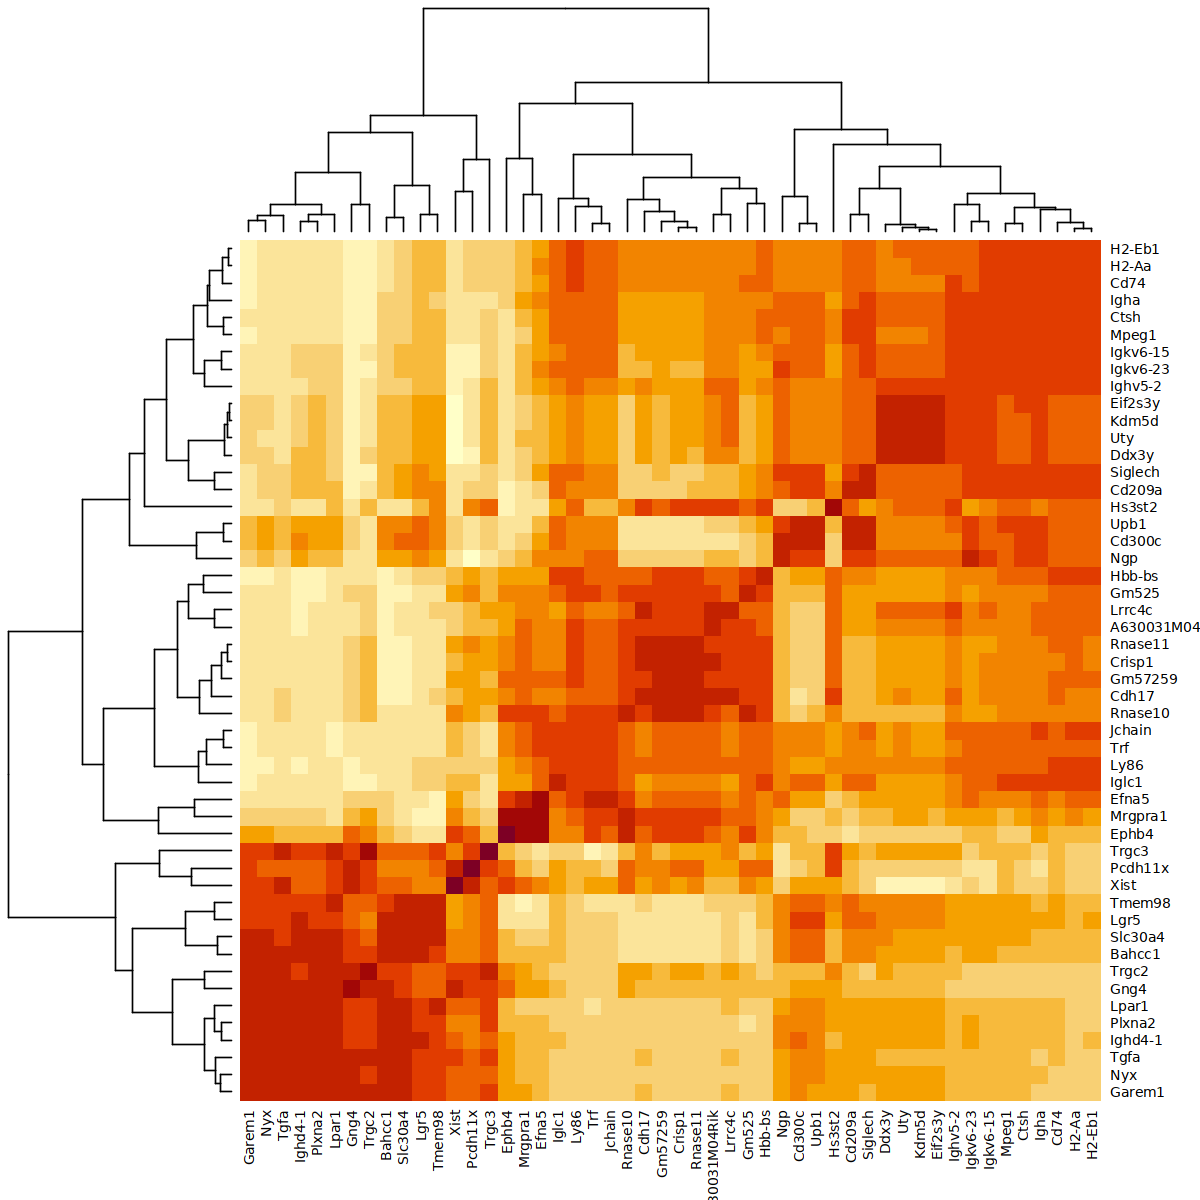

In [82]:
## Code cell 71 ##

heatmap(cor(t(top50var[,c(3:13)])))

### 4.2 - With the `corrplot` package
---


The `corrplot`package is particularly efficient for customizing correlograms. https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html   
It allows for many improvements of the rendering.

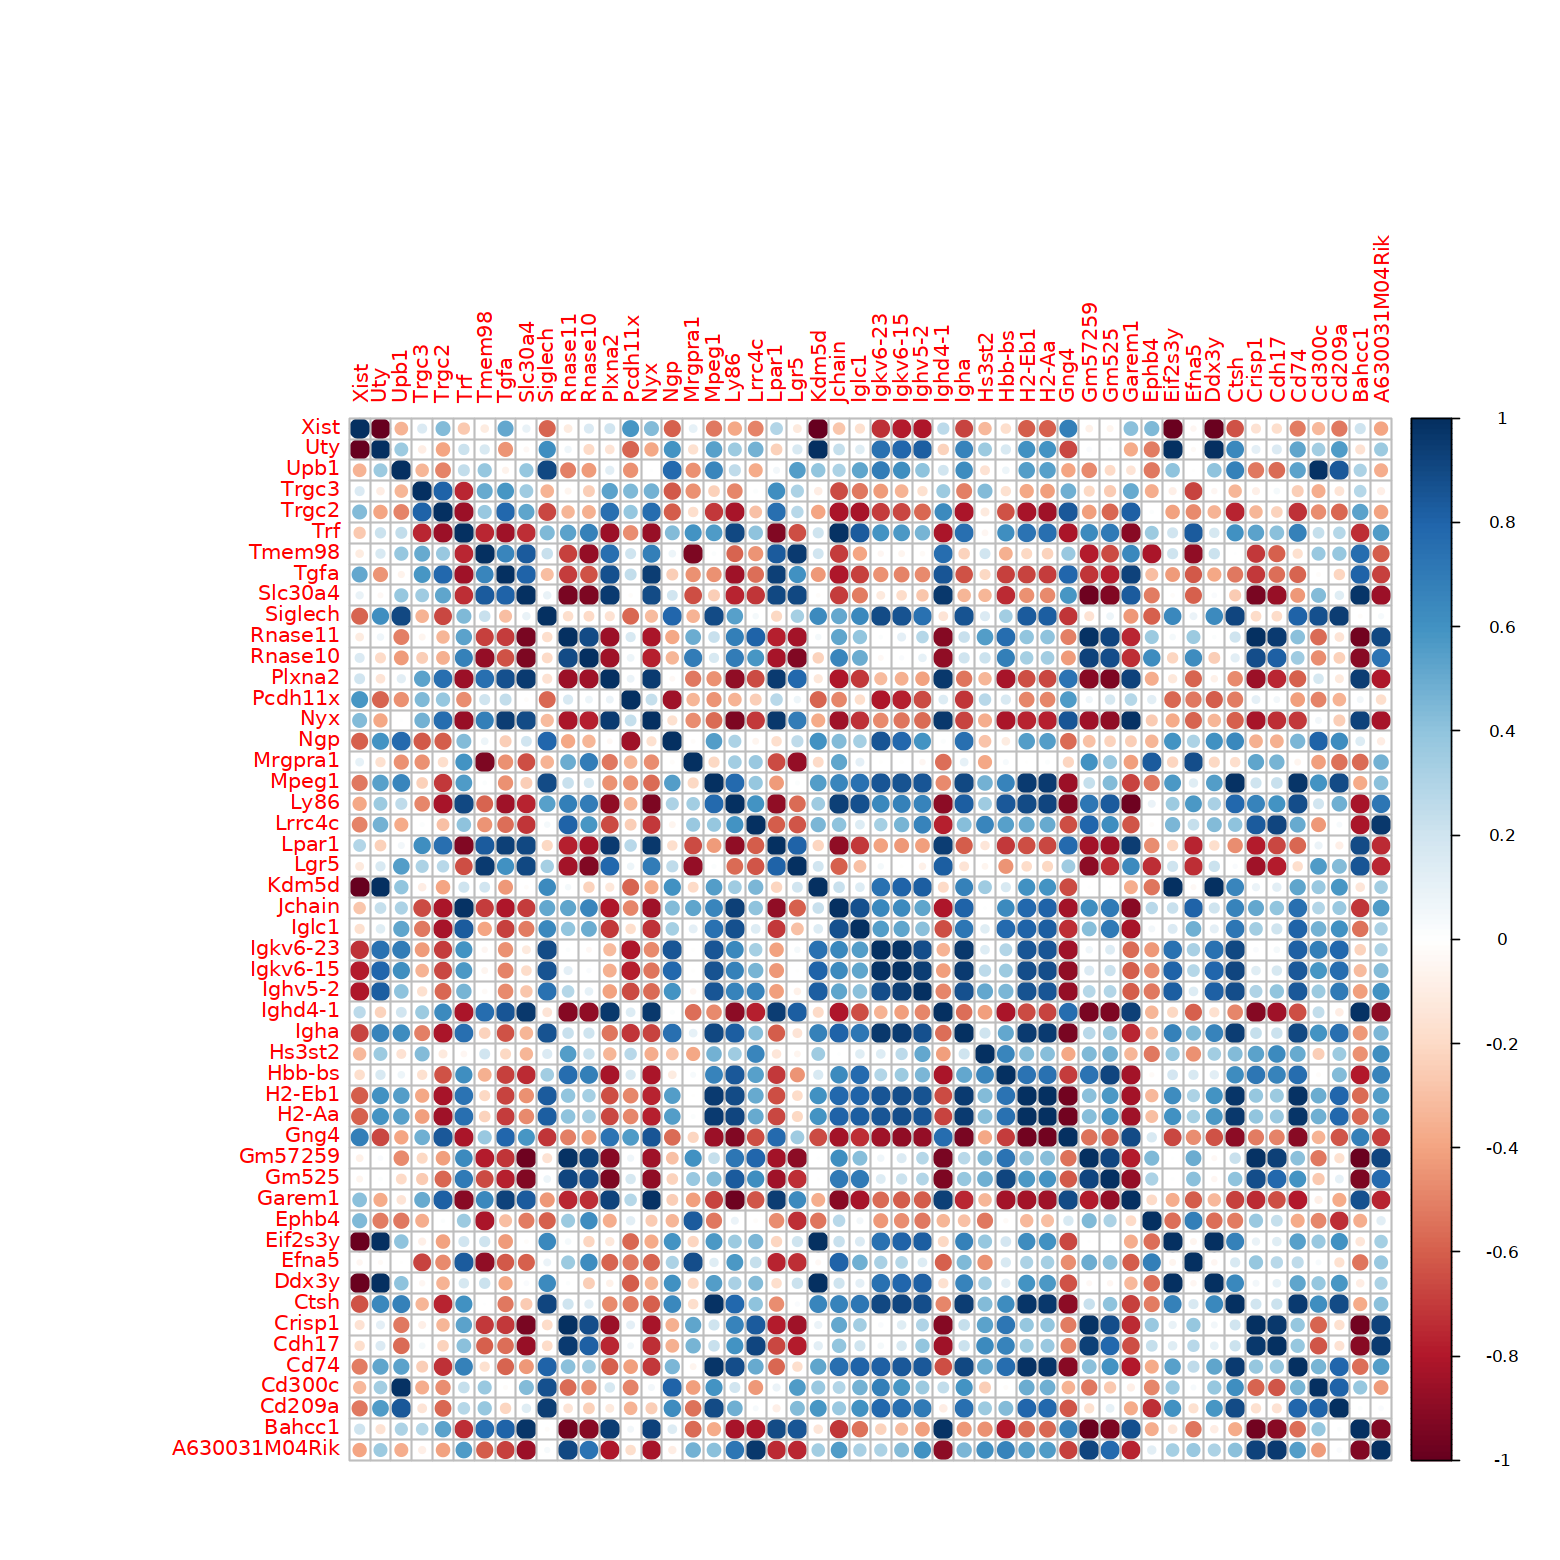

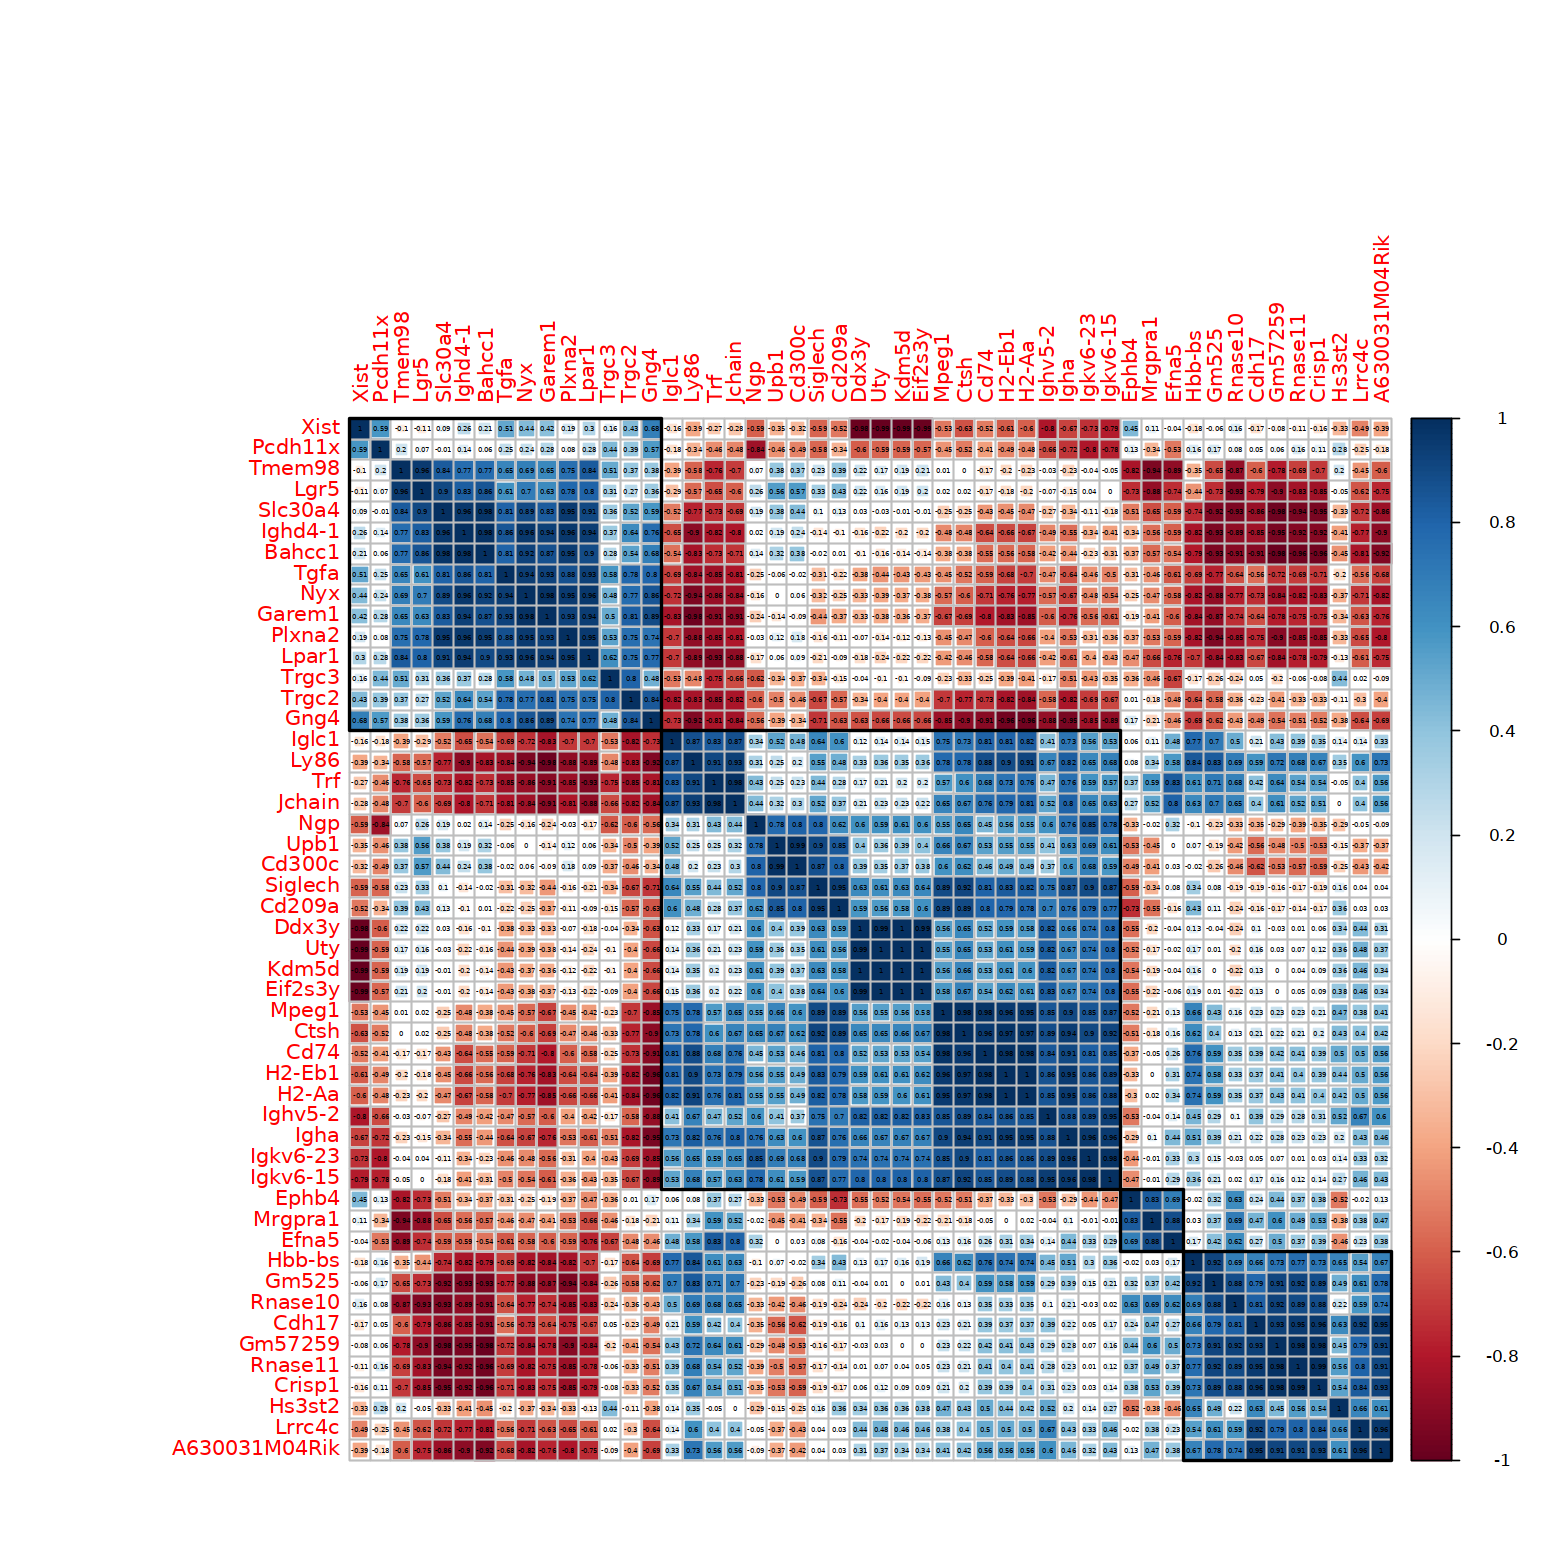

In [83]:
## Code cell 72 ##

options(repr.plot.width = 13, repr.plot.height = 13)

# A first "simple" plot
corrplot(cor(t(top50var[,c(3:13)])))

# method = "square" is the default 
# hclust clusterises the genes, grouping together the most correlated ones
# rectangles around clusters and correlation coefficients are also added
corrplot(cor(t(top50var[,c(3:13)])),
         method = "square",
         order = 'hclust',
         addrect = 4,
         addCoef.col = 'black',
         number.cex = 0.3)

By definition a correlation matrix is symmetrical.   
We can add arguments to the `corrplot()` function in order to display only one half of the matrix (here, the upper one). We can also change the shape of the  representation of each pair-wise correlation.</span>

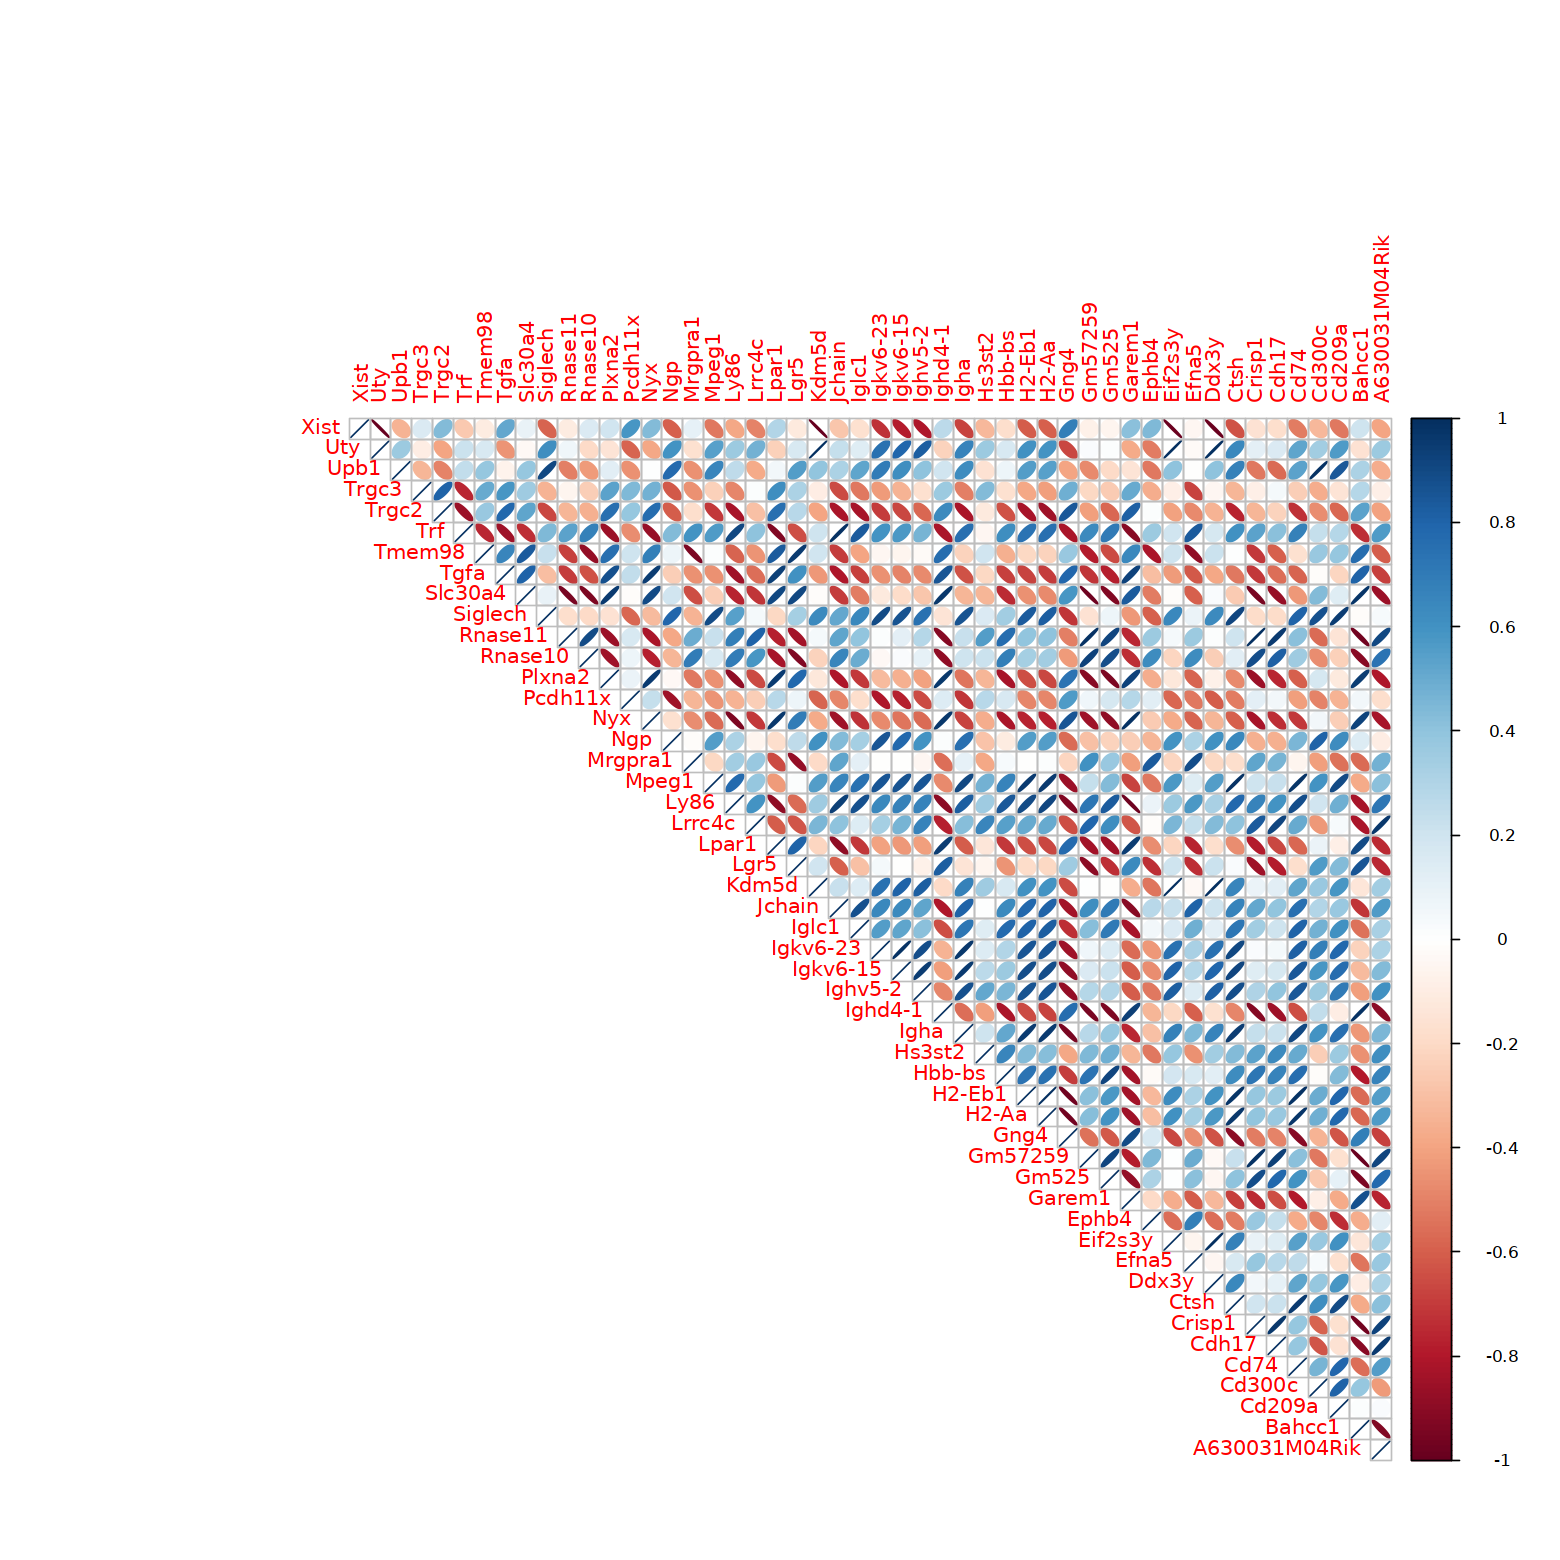

In [84]:
## Code cell 73 ##

# type = 'upper' will show only the upper half of the matrix
corrplot(cor(t(top50var[,c(3:13)])),
        method = 'ellipse',
        type = 'upper',
        insig = 'blank')

___
---
## 5 - Saving our results for later use: RData file
---
 

We can save all the R objects created in this session in a single R object.   
This will help us to reload our results without having to run the same commands.   

In [ ]:
## Code cell 74 ##

print(ls())

In [85]:
## Code cell 74 ##

head(res2_dHet_dHetRag_sig_ranked_annot)

ensemblID             baseMean   log2FoldChange lfcSE     stat     
1 ENSMUSG00000117613.3   3233.1884  7.619955      0.3028339  25.16216
2 ENSMUSG00000024241.8  11366.4220  5.028573      0.2069752  24.29553
3 ENSMUSG00000070348.6  10921.8577  7.178419      0.3479313  20.63172
4 ENSMUSG00000021423.7   5928.3809 11.566314      0.5908234  19.57660
5 ENSMUSG00000040591.19   507.8156 -4.017643      0.2057676 -19.52514
6 ENSMUSG00000025232.9   3409.0435  2.658209      0.1368027  19.43097
  pvalue        padj          chr   annotation start     end       strand
1 1.040198e-139 2.289997e-135 chr18 HAVANA      15327780  15409293 +     
2 2.185695e-130 2.405904e-126 chr17 HAVANA      80701180  80787882 -     
3  1.424977e-94  1.045695e-90 chr7  HAVANA     144483668 144493662 -     
4  2.448278e-85  1.347471e-81 chr13 HAVANA      37529184  37603012 +     
5  6.712754e-85  2.955626e-81 chr2  HAVANA      91105413  91275049 -     
6  4.223195e-84  1.549561e-80 chr9  HAVANA      59446823  59472392 +     
  gene_type      gene_name level    mgi_id      havana_gene          rank_DE
1 lncRNA         Gm2629     level 2 MGI:3780797 OTTMUSG00000072880.1 1      
2 protein_coding Sos1       level 2 MGI:98354   OTTMUSG00000072682.1 2      
3 protein_coding Ccnd1      level 2 MGI:88313   OTTMUSG00000026018.2 3      
4 protein_coding Ly86       level 2 MGI:1321404 OTTMUSG00000068199.1 4      
5 protein_coding Cstpp1     level 2 MGI:1915079  tag ncRNA_host"     5      
6 protein_coding Hexa       level 2 MGI:96073   OTTMUSG00000063295.1 6

We keep only the relevant objects:

In [86]:
## Code cell 75 ##

rm(PCAdata, PCAdata2, t_top50var)

and we save all our info in a single RData object in our output folder:

In [87]:
## Code cell 76 ##

ls()
save.image(file=paste0(deseq2folder,"deseq2-final.RData"))

[1] "PCAres"                             "conditionColor"                    
 [3] "deseq2folder"                       "downGenes"                         
 [5] "dup_genes"                          "eig.val"                           
 [7] "for_factominer"                     "gencode"                           
 [9] "gohome"                             "myfolder"                          
[11] "norm_counts"                        "res2_dHet_dHetRag_sig_ranked_annot"
[13] "samples"                            "session_parameters"                
[15] "top50DE"                            "top50var"                          
[17] "upGenes"                            "var_genes"

---
___

Now we go on with the analysis of enrichments of gene lists of interest.  
  
**=> Step 11: Overrepresentation and enrichment analysis** 

The jupyter notebook used for the last session will be *Pipe_11-R-ORA-GSEA.ipynb*     


In [88]:
## Code cell 77 ##   

myfolder

file.copy("/shared/projects/2413_rnaseq_cea/pipeline/Pipe_11-R-ORA-GSEA.ipynb", myfolder)


[1] "/shared/ifbstor1/projects/2413_rnaseq_cea/scaburet"

[1] FALSE

**Save executed notebook**

To end the session, save your executed notebook in your `run_notebooks` folder. Adjust the name with yours and reformat as code cell to run it.

In [89]:
## Code cell 78 ##   

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste0(myfolder,"/run_notebooks"), recursive = TRUE, showWarnings = FALSE)

runfolder <- paste0(myfolder,"/run_notebooks")
       
file.copy(paste0(myfolder, "/Pipe_10-R-Normcounts-exploratory-analysis-II.ipynb"), paste0(runfolder, "/Pipe_10-R4-Normcounts-exploratory-analysis-II-run-run.ipynb"))


[1] TRUE

<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to visualize normalised expression data.<br>
Don't forget to save you notebook and export a copy as an <b>html</b> file as well <br>
- Open "File" in the Menu<br>
- Select "Export Notebook As"<br>
- Export notebook as HTML<br>
- You can then open it in your browser even without being connected to the server! 
</div>

---
---

## Useful commands
<div class="alert alert-block alert-info"> 
    
- <kbd>CTRL</kbd>+<kbd>S</kbd> : save notebook<br>    
- <kbd>CTRL</kbd>+<kbd>ENTER</kbd> : Run Cell<br>  
- <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> : Run Cell and Select Next<br>   
- <kbd>ALT</kbd>+<kbd>ENTER</kbd> : Run Cell and Insert Below<br>   
- <kbd>ESC</kbd>+<kbd>y</kbd> : Change to *Code* Cell Type<br>  
- <kbd>ESC</kbd>+<kbd>m</kbd> : Change to *Markdown* Cell Type<br> 
- <kbd>ESC</kbd>+<kbd>r</kbd> : Change to *Raw* Cell Type<br>    
- <kbd>ESC</kbd>+<kbd>a</kbd> : Create Cell Above<br> 
- <kbd>ESC</kbd>+<kbd>b</kbd> : Create Cell Below<br> 

<em>  
To make nice html reports with markdown: <a href="https://dillinger.io/" title="dillinger.io">html visualization tool 1</a> or <a href="https://stackedit.io/app#" title="stackedit.io">html visualization tool 2</a>, <a href="https://www.tablesgenerator.com/markdown_tables" title="tablesgenerator.com">to draw nice tables</a>, and the <a href="https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd" title="Ultimate guide">Ultimate guide</a>. <br>
Further reading on JupyterLab notebooks: <a href="https://jupyterlab.readthedocs.io/en/latest/user/notebook.html" title="Jupyter Lab">Jupyter Lab documentation</a>.<br>   
</em>    
 
</div>

Bénédicte Noblet - 05-07 2021   
Sandrine Caburet et Claire Vandiedonck - 02-06 2023   
with adaptations from https://bioinformatics-core-shared-training.github.io/RNAseq_November_2020_remote/html/02_Preprocessing_Data.html   
and https://rpubs.com/adoughan/778146  
Maj 22/06/2024 par @SCaburet   